## 使用LightGBM进行分类预测

### 1.导入库

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split # 划分数据集
from sklearn.ensemble import RandomForestClassifier  # 随机森林
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV  # 网格划分
from sklearn.metrics import accuracy_score,recall_score,log_loss # 模型评估
import joblib # 模型保存

### 2.读取数据与预处理

In [34]:
data = pd.read_csv('openpose_train_data.csv')
data

,Unnamed: 0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,a9,a10,a11,a12,a13,a14,a15,a16,a17,label
0,img_100026.jpg,127.137721,24.738634,18.973666,61.773781,NaN,64.621978,157.035028,142.618372,63.780875,...,-4.055314,NaN,3.185424,0.382155,1.004067,-1.479100,-2.483167,2.341270,2.019520,0
1,img_10003.jpg,80.049984,18.973666,26.832816,53.665631,NaN,50.911688,133.221620,118.186294,50.911688,...,-4.414870,NaN,3.700192,0.558599,0.785398,-1.665748,-2.451146,2.502383,2.199050,0
2,img_100050.jpg,96.932967,18.973666,NaN,43.266615,NaN,46.861498,164.754363,151.789328,50.911688,...,-3.937187,NaN,3.455825,0.404892,NaN,-1.512041,NaN,2.211233,1.911945,0
3,img_100074.jpg,108.166538,37.947332,30.594117,64.899923,NaN,59.093147,197.362610,174.000000,48.373546,...,-4.416948,NaN,3.504318,0.463648,1.051650,-1.837048,-2.888699,2.485020,2.300696,0
4,img_10012.jpg,84.214013,24.738634,18.000000,53.665631,NaN,51.613952,163.768129,189.736660,51.613952,...,NaN,NaN,3.690535,0.548942,-4.957368,-1.744468,3.212900,2.441489,2.137809,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22391,5.jpg,98.407317,21.633308,18.973666,54.332311,NaN,43.680659,115.412304,122.376468,56.920998,...,-4.449394,NaN,3.778394,0.593350,-4.978641,-1.503103,3.475538,2.120696,1.842396,2
22392,6.jpg,89.196412,25.455844,18.973666,54.000000,NaN,48.000000,114.629839,131.726990,54.000000,...,-4.468285,NaN,3.879408,0.737815,-5.176037,-1.523213,3.652823,1.986861,1.659616,2
22393,7.jpg,101.823376,25.455844,30.000000,48.373546,NaN,37.947332,121.490740,128.825463,43.680659,...,-4.251517,NaN,3.605240,0.507099,-5.497787,-1.570796,3.926991,2.000559,1.668523,2
22394,8.jpg,80.721744,21.633308,21.633308,48.373546,NaN,48.373546,114.000000,134.164079,54.000000,...,-4.156744,NaN,3.855219,0.837981,-4.712389,-1.425984,3.286405,2.095157,1.738256,2


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22396 entries, 0 to 22395
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  22396 non-null  object 
 1   d1          22169 non-null  float64
 2   d2          22059 non-null  float64
 3   d3          19920 non-null  float64
 4   d4          21651 non-null  float64
 5   d5          2643 non-null   float64
 6   d6          22349 non-null  float64
 7   d7          21747 non-null  float64
 8   d8          19946 non-null  float64
 9   d9          22345 non-null  float64
 10  d10         21391 non-null  float64
 11  d11         20228 non-null  float64
 12  d12         21356 non-null  float64
 13  d13         19525 non-null  float64
 14  d14         4759 non-null   float64
 15  d15         21668 non-null  float64
 16  d16         18118 non-null  float64
 17  d17         1804 non-null   float64
 18  a1          21651 non-null  float64
 19  a2          2643 non-null

#### 删除缺失值过多的列

In [36]:
for l in data.columns:
    if data[l].count() < 5000:
        data = data.drop([l], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22396 entries, 0 to 22395
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  22396 non-null  object 
 1   d1          22169 non-null  float64
 2   d2          22059 non-null  float64
 3   d3          19920 non-null  float64
 4   d4          21651 non-null  float64
 5   d6          22349 non-null  float64
 6   d7          21747 non-null  float64
 7   d8          19946 non-null  float64
 8   d9          22345 non-null  float64
 9   d10         21391 non-null  float64
 10  d11         20228 non-null  float64
 11  d12         21356 non-null  float64
 12  d13         19525 non-null  float64
 13  d15         21668 non-null  float64
 14  d16         18118 non-null  float64
 15  a1          21651 non-null  float64
 16  a3          21742 non-null  float64
 17  a4          19946 non-null  float64
 18  a5          21381 non-null  float64
 19  a6          20228 non-nul

#### 缺失值进行同类均值补充

In [37]:
for l in data['label'].value_counts().index:
    mean_val = data[data.label==l].mean()
    data[data.label==l] = data[data.label==l].fillna(mean_val)
data.head()

,Unnamed: 0,d1,d2,d3,d4,d6,d7,d8,d9,d10,...,a7,a9,a11,a12,a13,a14,a15,a16,a17,label
0,img_100026.jpg,127.137721,24.738634,18.973666,61.773781,64.621978,157.035028,142.618372,63.780875,120.149906,...,-4.369365,-4.055314,3.185424,0.382155,1.004067,-1.479100,-2.483167,2.341270,2.019520,0
1,img_10003.jpg,80.049984,18.973666,26.832816,53.665631,50.911688,133.221620,118.186294,50.911688,93.145048,...,-4.515336,-4.414870,3.700192,0.558599,0.785398,-1.665748,-2.451146,2.502383,2.199050,0
2,img_100050.jpg,96.932967,18.973666,22.044608,43.266615,46.861498,164.754363,151.789328,50.911688,97.672924,...,-4.384618,-3.937187,3.455825,0.404892,0.245618,-1.512041,-1.826560,2.211233,1.911945,0
3,img_100074.jpg,108.166538,37.947332,30.594117,64.899923,59.093147,197.362610,174.000000,48.373546,109.489726,...,-4.540093,-4.416948,3.504318,0.463648,1.051650,-1.837048,-2.888699,2.485020,2.300696,0
4,img_10012.jpg,84.214013,24.738634,18.000000,53.665631,51.613952,163.768129,189.736660,51.613952,124.851912,...,-4.233964,-4.083615,3.690535,0.548942,-4.957368,-1.744468,3.212900,2.441489,2.137809,0


#### 处理第一列名称

In [38]:
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,d1,d2,d3,d4,d6,d7,d8,d9,d10,d11,...,a7,a9,a11,a12,a13,a14,a15,a16,a17,label
0,127.137721,24.738634,18.973666,61.773781,64.621978,157.035028,142.618372,63.780875,120.149906,108.664622,...,-4.369365,-4.055314,3.185424,0.382155,1.004067,-1.479100,-2.483167,2.341270,2.019520,0
1,80.049984,18.973666,26.832816,53.665631,50.911688,133.221620,118.186294,50.911688,93.145048,84.000000,...,-4.515336,-4.414870,3.700192,0.558599,0.785398,-1.665748,-2.451146,2.502383,2.199050,0
2,96.932967,18.973666,22.044608,43.266615,46.861498,164.754363,151.789328,50.911688,97.672924,72.993150,...,-4.384618,-3.937187,3.455825,0.404892,0.245618,-1.512041,-1.826560,2.211233,1.911945,0
3,108.166538,37.947332,30.594117,64.899923,59.093147,197.362610,174.000000,48.373546,109.489726,116.498927,...,-4.540093,-4.416948,3.504318,0.463648,1.051650,-1.837048,-2.888699,2.485020,2.300696,0
4,84.214013,24.738634,18.000000,53.665631,51.613952,163.768129,189.736660,51.613952,124.851912,117.204537,...,-4.233964,-4.083615,3.690535,0.548942,-4.957368,-1.744468,3.212900,2.441489,2.137809,0


### 3.切分数据输入（特征）与输出（预测目标变量）

In [39]:
label = data.label
feature = data.drop(['label'], axis=1)

### 4.切分训练集与测试集（0.8：0.2）

In [43]:
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.00000001)

### 5.模型训练

In [44]:
RFC = RandomForestClassifier(n_estimators=50, random_state=0)
RFC.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=0)

In [134]:
gbm = lgb.LGBMClassifier(learning_rate=0.05, n_estimators=1000)
gbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05, n_estimators=1000)

### 6.模型的存储与加载

In [45]:
# 模型存储
joblib.dump(RFC, 'RandomForestClassifier_model.pkl')
# 模型加载
RFC = joblib.load('RandomForestClassifier_model.pkl')

In [117]:
# 模型存储
joblib.dump(gbm, 'LightGBMClassifier_model.pkl')
# 模型加载
gbm = joblib.load('LightGBMClassifier_model.pkl')

### 7.模型的预测与评估

In [42]:
# 模型预测
y_pred = RFC.predict(X_test)
y_pred_proba = RFC.predict_proba(X_test)

# 模型评估
print('正确率:', accuracy_score(y_test, y_pred))
print("损失值:", log_loss(y_test, y_pred_proba))

正确率: 0.9392748705125915
损失值: 0.3425187971418098


In [136]:
# 模型预测
y_pred = gbm.predict(X_test)
y_pred_proba = gbm.predict_proba(X_test)

# 模型评估
print('正确率:', accuracy_score(y_test, y_pred))
print("损失值:", log_loss(y_test, y_pred_proba))

正确率: 0.9665029030817329
损失值: 0.18185135003660877


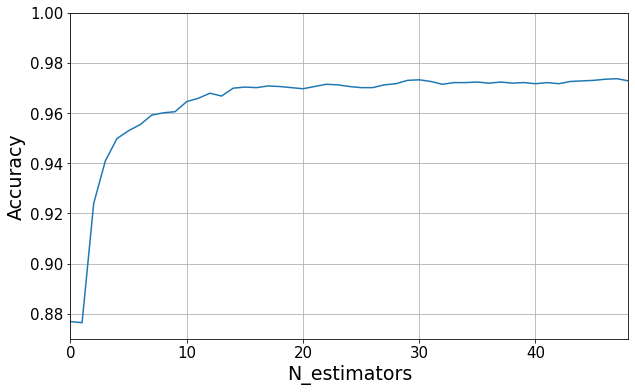

In [61]:
import matplotlib.pyplot as plt
accuracy=[]
for i in range(1,50):
    RFC = RandomForestClassifier(n_estimators=i, random_state=0)
    RFC.fit(X_train, y_train)
    y_pred = RFC.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
plt.figure(figsize=(10,6))
plt.plot(accuracy)
plt.ylabel('Accuracy',fontsize=19)
plt.xlabel('N_estimators',fontsize=19)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0.87,1])
plt.xlim([0,48])
plt.grid()

In [57]:
    from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, classification_report, accuracy_score
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    print("Precision is ", round(precision,4))
    print("Recall is ", round(recall,4))
    print("f1 score is ", round(f1,4))
    print("accuracy score is ", round(acc,4))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       518
           1       0.97      1.00      0.98       454
           2       0.97      0.99      0.98       474
           3       0.98      0.98      0.98       451
           4       0.99      0.99      0.99       446
           5       0.99      0.98      0.99       459
           6       0.98      0.97      0.97       500
           7       1.00      0.99      0.99       399
           8       0.97      0.90      0.94       378
           9       0.96      0.94      0.95       397

    accuracy                           0.97      4476
   macro avg       0.97      0.97      0.97      4476
weighted avg       0.97      0.97      0.97      4476

Precision is  0.9738
Recall is  0.9736
f1 score is  0.9735
accuracy score is  0.9736


### 8.网络搜索，优化参数

In [26]:
# 网格搜索，参数优化（慢，不必要）
estimator = ExtraTreesClassifier()
param_grid = {
    'max_depth': [40,60,80,100],
    'n_estimators': [300,500,1000,2000]
}
etc = GridSearchCV(estimator, param_grid)
etc.fit(X_train, y_train)
print('最好的参数组合为:', etc.best_params_)

最好的参数组合为: {'max_depth': 60, 'n_estimators': 1000}


In [131]:
import numpy as np
test = np.array(data.loc[22385])
test = [test[0:-1]]
pred = gbm.predict(test)
pred

array([9], dtype=int64)

### 9.测试集输出——kaggle提交

In [35]:
# 读取测试集并进行预处理
data_test = pd.read_csv('openpose_test_data.csv')
data_test = data_test.drop(['d5'], axis=1)
data_test = data_test.drop(['d14'], axis=1)
data_test = data_test.drop(['d17'], axis=1)
data_test = data_test.drop(['a5'], axis=1)
data_test = data_test.drop(['a14'], axis=1)
data_test = data_test.drop(['a17'], axis=1)
data_test.rename(columns={'Unnamed: 0': 'img'}, inplace=True)
for l in data_test['label'].value_counts().index:
    mean_val = data_test[data_test.label==l].mean()
    data_test[data_test.label==l] = data_test[data_test.label==l].fillna(mean_val)
data_test.head()

,img,d1,d2,d3,d4,d6,d7,d8,d9,d10,...,a7,a8,a9,a10,a11,a12,a13,a15,a16,label
0,img_1.jpg,32.388269,11.401754,8.246211,19.723083,17.492856,62.649820,59.413803,17.492856,33.120990,...,-2.070143,-1.452704,-0.540420,-2.074962,-1.060308,-2.490516,-1.378091,-2.222968,-1.247239,0.0
1,img_10.jpg,35.468296,7.615773,7.390415,19.235384,19.416488,59.135438,54.201200,19.849433,41.109610,...,-1.897894,-0.674722,-0.714091,-1.497756,-1.469107,-2.584468,-0.998603,-2.312744,-1.020410,0.0
2,img_100.jpg,41.593269,11.045361,7.211103,25.495098,19.723083,64.629715,63.780875,19.723083,38.600518,...,-1.710505,-0.718830,-0.531724,-1.859772,-0.872894,-2.406998,-1.379148,-2.201478,-1.302430,0.0
3,img_1000.jpg,44.777226,8.246211,7.390415,22.627417,21.260292,58.309519,48.703183,21.931712,41.484937,...,-2.111216,0.334737,-0.753151,-1.839163,-1.014630,-2.727594,-1.233340,-2.456975,-1.037952,0.0
4,img_100000.jpg,39.293765,8.062258,5.830952,18.357560,14.212670,53.600373,48.383882,14.212670,40.607881,...,-2.210566,-1.255582,-0.685730,-2.478390,-0.165149,-2.619189,-1.093904,-2.388441,-1.247239,0.0


In [36]:
data_input = data_test.set_index('img')
data_input = data_input.drop(['label'], axis=1)
data_input.head()

,d1,d2,d3,d4,d6,d7,d8,d9,d10,d11,...,a6,a7,a8,a9,a10,a11,a12,a13,a15,a16
img,,,,,,,,,,,,,,,,,,,,,
img_1.jpg,32.388269,11.401754,8.246211,19.723083,17.492856,62.649820,59.413803,17.492856,33.120990,28.653098,...,2.601173,-2.070143,-1.452704,-0.540420,-2.074962,-1.060308,-2.490516,-1.378091,-2.222968,-1.247239
img_10.jpg,35.468296,7.615773,7.390415,19.235384,19.416488,59.135438,54.201200,19.849433,41.109610,49.254441,...,2.539305,-1.897894,-0.674722,-0.714091,-1.497756,-1.469107,-2.584468,-0.998603,-2.312744,-1.020410
img_100.jpg,41.593269,11.045361,7.211103,25.495098,19.723083,64.629715,63.780875,19.723083,38.600518,40.459857,...,2.609869,-1.710505,-0.718830,-0.531724,-1.859772,-0.872894,-2.406998,-1.379148,-2.201478,-1.302430
img_1000.jpg,44.777226,8.246211,7.390415,22.627417,21.260292,58.309519,48.703183,21.931712,41.484937,43.566042,...,2.422763,-2.111216,0.334737,-0.753151,-1.839163,-1.014630,-2.727594,-1.233340,-2.456975,-1.037952
img_100000.jpg,39.293765,8.062258,5.830952,18.357560,14.212670,53.600373,48.383882,14.212670,40.607881,18.248288,...,2.455863,-2.210566,-1.255582,-0.685730,-2.478390,-0.165149,-2.619189,-1.093904,-2.388441,-1.247239


In [43]:
# 模型加载
etc = joblib.load('ExtraTreesClassifier_model.pkl')

In [44]:
frame = pd.DataFrame(columns=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
frame

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9


In [45]:
import numpy as np
for _,row in data_input.iterrows():
    print(row.name)
    data_output = etc.predict_proba(np.array([row]))
    frame.loc[row.name] = data_output[0]
frame.head()

img_1.jpg
img_10.jpg
img_100.jpg
img_1000.jpg
img_100000.jpg
img_100001.jpg
img_100002.jpg
img_100003.jpg
img_100004.jpg
img_100005.jpg
img_100007.jpg
img_100008.jpg
img_100009.jpg
img_10001.jpg
img_100010.jpg
img_100011.jpg
img_100012.jpg
img_100013.jpg
img_100014.jpg
img_100016.jpg
img_100017.jpg
img_100018.jpg
img_100019.jpg
img_10002.jpg
img_100020.jpg
img_100022.jpg
img_100023.jpg
img_100024.jpg
img_100025.jpg
img_100028.jpg
img_100030.jpg
img_100031.jpg
img_100032.jpg
img_100033.jpg
img_100034.jpg
img_100035.jpg
img_100037.jpg
img_100038.jpg
img_100039.jpg
img_10004.jpg
img_100040.jpg
img_100042.jpg
img_100043.jpg
img_100044.jpg
img_100047.jpg
img_100049.jpg
img_10005.jpg
img_100051.jpg
img_100052.jpg
img_100053.jpg
img_100054.jpg
img_100055.jpg
img_100056.jpg
img_100058.jpg
img_100059.jpg
img_10006.jpg
img_100060.jpg
img_100062.jpg
img_100063.jpg
img_100064.jpg
img_100066.jpg
img_100067.jpg
img_100068.jpg
img_100069.jpg
img_10007.jpg
img_100070.jpg
img_100071.jpg
img_100072.jpg


img_100635.jpg
img_100637.jpg
img_100639.jpg
img_10064.jpg
img_100641.jpg
img_100642.jpg
img_100644.jpg
img_100645.jpg
img_100647.jpg
img_100648.jpg
img_100649.jpg
img_10065.jpg
img_100650.jpg
img_100651.jpg
img_100652.jpg
img_100653.jpg
img_100654.jpg
img_100655.jpg
img_100657.jpg
img_100658.jpg
img_100659.jpg
img_10066.jpg
img_100660.jpg
img_100661.jpg
img_100662.jpg
img_100663.jpg
img_100666.jpg
img_100667.jpg
img_100668.jpg
img_100669.jpg
img_10067.jpg
img_100670.jpg
img_100671.jpg
img_100672.jpg
img_100673.jpg
img_100674.jpg
img_100675.jpg
img_100677.jpg
img_100678.jpg
img_100679.jpg
img_100680.jpg
img_100681.jpg
img_100684.jpg
img_100685.jpg
img_100686.jpg
img_100687.jpg
img_10069.jpg
img_100692.jpg
img_100694.jpg
img_100696.jpg
img_100698.jpg
img_100699.jpg
img_1007.jpg
img_10070.jpg
img_100700.jpg
img_100703.jpg
img_100704.jpg
img_100705.jpg
img_100707.jpg
img_100708.jpg
img_100709.jpg
img_10071.jpg
img_100710.jpg
img_100711.jpg
img_100712.jpg
img_100713.jpg
img_100714.jpg
img_

img_101275.jpg
img_101276.jpg
img_101277.jpg
img_101278.jpg
img_101279.jpg
img_10128.jpg
img_101280.jpg
img_101281.jpg
img_101282.jpg
img_101283.jpg
img_101284.jpg
img_101285.jpg
img_101287.jpg
img_101288.jpg
img_101289.jpg
img_10129.jpg
img_101291.jpg
img_101292.jpg
img_101294.jpg
img_101296.jpg
img_101297.jpg
img_101299.jpg
img_1013.jpg
img_10130.jpg
img_101300.jpg
img_101301.jpg
img_101302.jpg
img_101303.jpg
img_101305.jpg
img_101306.jpg
img_101307.jpg
img_101308.jpg
img_101309.jpg
img_10131.jpg
img_101311.jpg
img_101313.jpg
img_101314.jpg
img_101315.jpg
img_101316.jpg
img_101317.jpg
img_101318.jpg
img_10132.jpg
img_101322.jpg
img_101323.jpg
img_101324.jpg
img_101326.jpg
img_101327.jpg
img_101328.jpg
img_101329.jpg
img_101330.jpg
img_101331.jpg
img_101332.jpg
img_101333.jpg
img_101334.jpg
img_101335.jpg
img_101336.jpg
img_101337.jpg
img_101338.jpg
img_101339.jpg
img_101340.jpg
img_101342.jpg
img_101343.jpg
img_101344.jpg
img_101345.jpg
img_101346.jpg
img_101347.jpg
img_101348.jpg
im

img_101904.jpg
img_101910.jpg
img_101911.jpg
img_101912.jpg
img_101913.jpg
img_101915.jpg
img_101916.jpg
img_101917.jpg
img_101918.jpg
img_101919.jpg
img_10192.jpg
img_101922.jpg
img_101923.jpg
img_101924.jpg
img_101925.jpg
img_101926.jpg
img_101927.jpg
img_101928.jpg
img_101929.jpg
img_10193.jpg
img_101930.jpg
img_101931.jpg
img_101932.jpg
img_101933.jpg
img_101934.jpg
img_101935.jpg
img_101936.jpg
img_101937.jpg
img_101939.jpg
img_10194.jpg
img_101940.jpg
img_101941.jpg
img_101942.jpg
img_101943.jpg
img_101945.jpg
img_101946.jpg
img_101947.jpg
img_101948.jpg
img_10195.jpg
img_101950.jpg
img_101951.jpg
img_101952.jpg
img_101953.jpg
img_101954.jpg
img_101955.jpg
img_101958.jpg
img_101959.jpg
img_10196.jpg
img_101960.jpg
img_101961.jpg
img_101962.jpg
img_101963.jpg
img_101964.jpg
img_101965.jpg
img_101967.jpg
img_101968.jpg
img_101969.jpg
img_10197.jpg
img_101970.jpg
img_101971.jpg
img_101972.jpg
img_101974.jpg
img_101976.jpg
img_101978.jpg
img_101979.jpg
img_101980.jpg
img_101981.jpg
i

img_10628.jpg
img_10629.jpg
img_10630.jpg
img_10631.jpg
img_10632.jpg
img_10633.jpg
img_10634.jpg
img_10635.jpg
img_10636.jpg
img_10637.jpg
img_10639.jpg
img_1064.jpg
img_10640.jpg
img_10641.jpg
img_10642.jpg
img_10643.jpg
img_10645.jpg
img_10646.jpg
img_10648.jpg
img_10649.jpg
img_1065.jpg
img_10653.jpg
img_10654.jpg
img_10655.jpg
img_10659.jpg
img_1066.jpg
img_10660.jpg
img_10661.jpg
img_10663.jpg
img_10664.jpg
img_10665.jpg
img_10666.jpg
img_10667.jpg
img_10668.jpg
img_10669.jpg
img_1067.jpg
img_10670.jpg
img_10671.jpg
img_10673.jpg
img_10674.jpg
img_10676.jpg
img_10677.jpg
img_10679.jpg
img_1068.jpg
img_10680.jpg
img_10682.jpg
img_10683.jpg
img_10684.jpg
img_10685.jpg
img_10686.jpg
img_10687.jpg
img_10688.jpg
img_10689.jpg
img_10690.jpg
img_10691.jpg
img_10692.jpg
img_10694.jpg
img_10695.jpg
img_10699.jpg
img_107.jpg
img_1070.jpg
img_10700.jpg
img_10701.jpg
img_10702.jpg
img_10703.jpg
img_10705.jpg
img_10707.jpg
img_10708.jpg
img_10709.jpg
img_10711.jpg
img_10712.jpg
img_10713.jpg


img_11306.jpg
img_11307.jpg
img_11308.jpg
img_1131.jpg
img_11310.jpg
img_11311.jpg
img_11312.jpg
img_11313.jpg
img_11314.jpg
img_11317.jpg
img_11318.jpg
img_1132.jpg
img_11320.jpg
img_11321.jpg
img_11322.jpg
img_11323.jpg
img_11325.jpg
img_11326.jpg
img_11327.jpg
img_11330.jpg
img_11331.jpg
img_11332.jpg
img_11333.jpg
img_11334.jpg
img_11335.jpg
img_11336.jpg
img_11337.jpg
img_11338.jpg
img_1134.jpg
img_11341.jpg
img_11343.jpg
img_11344.jpg
img_11345.jpg
img_11346.jpg
img_11347.jpg
img_11348.jpg
img_11349.jpg
img_1135.jpg
img_11350.jpg
img_11351.jpg
img_11353.jpg
img_11354.jpg
img_11355.jpg
img_11356.jpg
img_11359.jpg
img_1136.jpg
img_11361.jpg
img_11362.jpg
img_11363.jpg
img_11364.jpg
img_11365.jpg
img_11366.jpg
img_11367.jpg
img_11368.jpg
img_11369.jpg
img_1137.jpg
img_11370.jpg
img_11371.jpg
img_11372.jpg
img_11373.jpg
img_11374.jpg
img_11375.jpg
img_11376.jpg
img_11377.jpg
img_11378.jpg
img_11379.jpg
img_11380.jpg
img_11381.jpg
img_11382.jpg
img_11383.jpg
img_11384.jpg
img_11386.jp

img_11988.jpg
img_11989.jpg
img_1199.jpg
img_11991.jpg
img_11992.jpg
img_11993.jpg
img_11994.jpg
img_11995.jpg
img_11998.jpg
img_11999.jpg
img_12.jpg
img_1200.jpg
img_12002.jpg
img_12003.jpg
img_12004.jpg
img_12005.jpg
img_12006.jpg
img_12007.jpg
img_12009.jpg
img_1201.jpg
img_12013.jpg
img_12014.jpg
img_12015.jpg
img_12016.jpg
img_12018.jpg
img_12020.jpg
img_12021.jpg
img_12022.jpg
img_12023.jpg
img_12024.jpg
img_12026.jpg
img_12027.jpg
img_12028.jpg
img_12029.jpg
img_1203.jpg
img_12031.jpg
img_12032.jpg
img_12033.jpg
img_12034.jpg
img_12036.jpg
img_12037.jpg
img_12038.jpg
img_12039.jpg
img_1204.jpg
img_12040.jpg
img_12042.jpg
img_12043.jpg
img_12044.jpg
img_12045.jpg
img_12048.jpg
img_12049.jpg
img_1205.jpg
img_12050.jpg
img_12051.jpg
img_12052.jpg
img_12054.jpg
img_12055.jpg
img_12056.jpg
img_12058.jpg
img_12059.jpg
img_1206.jpg
img_12060.jpg
img_12061.jpg
img_12062.jpg
img_12063.jpg
img_12064.jpg
img_12065.jpg
img_12067.jpg
img_12068.jpg
img_12071.jpg
img_12072.jpg
img_12073.jpg
im

img_12672.jpg
img_12673.jpg
img_12675.jpg
img_12676.jpg
img_12678.jpg
img_12679.jpg
img_1268.jpg
img_12680.jpg
img_12681.jpg
img_12682.jpg
img_12683.jpg
img_12684.jpg
img_12685.jpg
img_12686.jpg
img_12688.jpg
img_12689.jpg
img_1269.jpg
img_12690.jpg
img_12691.jpg
img_12692.jpg
img_12693.jpg
img_12694.jpg
img_12695.jpg
img_12696.jpg
img_12697.jpg
img_12698.jpg
img_127.jpg
img_1270.jpg
img_12701.jpg
img_12702.jpg
img_12703.jpg
img_12705.jpg
img_12706.jpg
img_12707.jpg
img_12708.jpg
img_12709.jpg
img_1271.jpg
img_12710.jpg
img_12711.jpg
img_12713.jpg
img_1272.jpg
img_12720.jpg
img_12722.jpg
img_12725.jpg
img_12726.jpg
img_12728.jpg
img_12730.jpg
img_12732.jpg
img_12734.jpg
img_12735.jpg
img_12737.jpg
img_12739.jpg
img_1274.jpg
img_12741.jpg
img_12742.jpg
img_12743.jpg
img_12745.jpg
img_12746.jpg
img_12747.jpg
img_12748.jpg
img_12749.jpg
img_1275.jpg
img_12750.jpg
img_12751.jpg
img_12752.jpg
img_12753.jpg
img_12754.jpg
img_12755.jpg
img_12756.jpg
img_12757.jpg
img_12758.jpg
img_12759.jpg
i

img_13352.jpg
img_13353.jpg
img_13354.jpg
img_13355.jpg
img_13356.jpg
img_13358.jpg
img_13359.jpg
img_13360.jpg
img_13361.jpg
img_13362.jpg
img_13363.jpg
img_13364.jpg
img_13366.jpg
img_13367.jpg
img_13368.jpg
img_13369.jpg
img_13370.jpg
img_13372.jpg
img_13373.jpg
img_13374.jpg
img_13375.jpg
img_13376.jpg
img_13377.jpg
img_13379.jpg
img_13381.jpg
img_13382.jpg
img_13383.jpg
img_13384.jpg
img_13385.jpg
img_13388.jpg
img_1339.jpg
img_13390.jpg
img_13391.jpg
img_13393.jpg
img_13394.jpg
img_13395.jpg
img_13397.jpg
img_13399.jpg
img_134.jpg
img_1340.jpg
img_13400.jpg
img_13402.jpg
img_13403.jpg
img_13404.jpg
img_13406.jpg
img_13407.jpg
img_13408.jpg
img_13409.jpg
img_13410.jpg
img_13411.jpg
img_13414.jpg
img_13415.jpg
img_13416.jpg
img_13417.jpg
img_13418.jpg
img_13419.jpg
img_13421.jpg
img_13423.jpg
img_13424.jpg
img_13425.jpg
img_13426.jpg
img_13429.jpg
img_1343.jpg
img_13430.jpg
img_13432.jpg
img_13433.jpg
img_13434.jpg
img_13435.jpg
img_13436.jpg
img_13437.jpg
img_13439.jpg
img_1344.jp

img_14043.jpg
img_14044.jpg
img_14045.jpg
img_14046.jpg
img_14048.jpg
img_14049.jpg
img_1405.jpg
img_14051.jpg
img_14052.jpg
img_14053.jpg
img_14054.jpg
img_14055.jpg
img_14058.jpg
img_14059.jpg
img_1406.jpg
img_14061.jpg
img_14062.jpg
img_14063.jpg
img_14064.jpg
img_14065.jpg
img_14066.jpg
img_14067.jpg
img_14068.jpg
img_14069.jpg
img_14070.jpg
img_14071.jpg
img_14073.jpg
img_14074.jpg
img_14075.jpg
img_14078.jpg
img_14079.jpg
img_14080.jpg
img_14082.jpg
img_14083.jpg
img_14085.jpg
img_14086.jpg
img_14088.jpg
img_1409.jpg
img_14090.jpg
img_14091.jpg
img_14092.jpg
img_14093.jpg
img_14094.jpg
img_14095.jpg
img_14096.jpg
img_14097.jpg
img_14098.jpg
img_14099.jpg
img_141.jpg
img_1410.jpg
img_14100.jpg
img_14101.jpg
img_14103.jpg
img_14104.jpg
img_14106.jpg
img_14109.jpg
img_1411.jpg
img_14110.jpg
img_14112.jpg
img_14113.jpg
img_14114.jpg
img_14115.jpg
img_14116.jpg
img_14117.jpg
img_14119.jpg
img_1412.jpg
img_14120.jpg
img_14121.jpg
img_14122.jpg
img_14123.jpg
img_14124.jpg
img_14126.jpg


img_14729.jpg
img_1473.jpg
img_14730.jpg
img_14732.jpg
img_14733.jpg
img_14734.jpg
img_14735.jpg
img_14738.jpg
img_14739.jpg
img_1474.jpg
img_14740.jpg
img_14741.jpg
img_14743.jpg
img_14744.jpg
img_14745.jpg
img_14747.jpg
img_14748.jpg
img_14749.jpg
img_1475.jpg
img_14751.jpg
img_14753.jpg
img_14754.jpg
img_14755.jpg
img_14758.jpg
img_14759.jpg
img_1476.jpg
img_14760.jpg
img_14761.jpg
img_14762.jpg
img_14763.jpg
img_14764.jpg
img_14765.jpg
img_14766.jpg
img_14767.jpg
img_14768.jpg
img_14769.jpg
img_1477.jpg
img_14770.jpg
img_14771.jpg
img_14772.jpg
img_14773.jpg
img_14775.jpg
img_14776.jpg
img_14777.jpg
img_1478.jpg
img_14781.jpg
img_14782.jpg
img_14784.jpg
img_14786.jpg
img_14787.jpg
img_14788.jpg
img_14789.jpg
img_1479.jpg
img_14790.jpg
img_14791.jpg
img_14793.jpg
img_14794.jpg
img_14795.jpg
img_14797.jpg
img_14798.jpg
img_14799.jpg
img_148.jpg
img_1480.jpg
img_14800.jpg
img_14802.jpg
img_14804.jpg
img_14805.jpg
img_14806.jpg
img_14807.jpg
img_14808.jpg
img_14809.jpg
img_1481.jpg
img

img_15403.jpg
img_15404.jpg
img_15405.jpg
img_15406.jpg
img_15407.jpg
img_15409.jpg
img_1541.jpg
img_15410.jpg
img_15411.jpg
img_15412.jpg
img_15413.jpg
img_15414.jpg
img_15415.jpg
img_15416.jpg
img_15418.jpg
img_15419.jpg
img_15420.jpg
img_15421.jpg
img_15423.jpg
img_15424.jpg
img_15425.jpg
img_15427.jpg
img_15428.jpg
img_1543.jpg
img_15430.jpg
img_15431.jpg
img_15432.jpg
img_15433.jpg
img_15434.jpg
img_15435.jpg
img_15438.jpg
img_15439.jpg
img_1544.jpg
img_15443.jpg
img_15444.jpg
img_15445.jpg
img_15448.jpg
img_1545.jpg
img_15450.jpg
img_15451.jpg
img_15453.jpg
img_15455.jpg
img_15457.jpg
img_15458.jpg
img_1546.jpg
img_15460.jpg
img_15462.jpg
img_15464.jpg
img_15465.jpg
img_15466.jpg
img_15467.jpg
img_15468.jpg
img_15469.jpg
img_1547.jpg
img_15471.jpg
img_15472.jpg
img_15473.jpg
img_15474.jpg
img_15475.jpg
img_15476.jpg
img_15477.jpg
img_15478.jpg
img_1548.jpg
img_15480.jpg
img_15481.jpg
img_15482.jpg
img_15484.jpg
img_15485.jpg
img_15487.jpg
img_15488.jpg
img_15489.jpg
img_1549.jpg


img_16081.jpg
img_16082.jpg
img_16083.jpg
img_16084.jpg
img_16085.jpg
img_16086.jpg
img_16088.jpg
img_16089.jpg
img_1609.jpg
img_16090.jpg
img_16091.jpg
img_16094.jpg
img_16097.jpg
img_16098.jpg
img_16099.jpg
img_161.jpg
img_1610.jpg
img_16100.jpg
img_16101.jpg
img_16102.jpg
img_16103.jpg
img_16104.jpg
img_16105.jpg
img_16106.jpg
img_16108.jpg
img_16109.jpg
img_1611.jpg
img_16110.jpg
img_16111.jpg
img_16112.jpg
img_16113.jpg
img_16115.jpg
img_16116.jpg
img_16117.jpg
img_16118.jpg
img_16119.jpg
img_1612.jpg
img_16120.jpg
img_16121.jpg
img_16122.jpg
img_16124.jpg
img_16126.jpg
img_16127.jpg
img_16128.jpg
img_1613.jpg
img_16131.jpg
img_16133.jpg
img_16134.jpg
img_16135.jpg
img_16136.jpg
img_16137.jpg
img_16139.jpg
img_16140.jpg
img_16141.jpg
img_16142.jpg
img_16144.jpg
img_16145.jpg
img_16146.jpg
img_16147.jpg
img_1615.jpg
img_16150.jpg
img_16151.jpg
img_16152.jpg
img_16154.jpg
img_16155.jpg
img_16157.jpg
img_1616.jpg
img_16160.jpg
img_16162.jpg
img_16163.jpg
img_16165.jpg
img_16166.jpg
i

img_16768.jpg
img_16769.jpg
img_16770.jpg
img_16771.jpg
img_16773.jpg
img_16775.jpg
img_16776.jpg
img_16778.jpg
img_16779.jpg
img_1678.jpg
img_16780.jpg
img_16781.jpg
img_16783.jpg
img_16784.jpg
img_16785.jpg
img_16786.jpg
img_16787.jpg
img_16789.jpg
img_1679.jpg
img_16791.jpg
img_16793.jpg
img_16794.jpg
img_16795.jpg
img_16796.jpg
img_16797.jpg
img_16798.jpg
img_16799.jpg
img_168.jpg
img_1680.jpg
img_16800.jpg
img_16802.jpg
img_16803.jpg
img_16804.jpg
img_16805.jpg
img_16806.jpg
img_16807.jpg
img_16808.jpg
img_16809.jpg
img_1681.jpg
img_16811.jpg
img_16812.jpg
img_16814.jpg
img_16815.jpg
img_16818.jpg
img_1682.jpg
img_16821.jpg
img_16822.jpg
img_16824.jpg
img_16825.jpg
img_16826.jpg
img_16827.jpg
img_16829.jpg
img_1683.jpg
img_16830.jpg
img_16832.jpg
img_16833.jpg
img_16834.jpg
img_16835.jpg
img_16837.jpg
img_16838.jpg
img_16839.jpg
img_1684.jpg
img_16840.jpg
img_16841.jpg
img_16843.jpg
img_16844.jpg
img_16845.jpg
img_16846.jpg
img_16847.jpg
img_16848.jpg
img_16849.jpg
img_1685.jpg
im

img_17433.jpg
img_17434.jpg
img_17435.jpg
img_17436.jpg
img_17437.jpg
img_17438.jpg
img_17439.jpg
img_1744.jpg
img_17440.jpg
img_17441.jpg
img_17442.jpg
img_17443.jpg
img_17444.jpg
img_17445.jpg
img_17446.jpg
img_17448.jpg
img_1745.jpg
img_17450.jpg
img_17451.jpg
img_17452.jpg
img_17455.jpg
img_17457.jpg
img_17459.jpg
img_17461.jpg
img_17462.jpg
img_17464.jpg
img_17465.jpg
img_17466.jpg
img_17468.jpg
img_17469.jpg
img_1747.jpg
img_17471.jpg
img_17472.jpg
img_17473.jpg
img_17474.jpg
img_17475.jpg
img_17476.jpg
img_17477.jpg
img_17478.jpg
img_1748.jpg
img_17481.jpg
img_17482.jpg
img_17483.jpg
img_17485.jpg
img_17486.jpg
img_17487.jpg
img_17488.jpg
img_17489.jpg
img_1749.jpg
img_17490.jpg
img_17491.jpg
img_17492.jpg
img_17493.jpg
img_17495.jpg
img_17496.jpg
img_17497.jpg
img_17498.jpg
img_17499.jpg
img_175.jpg
img_1750.jpg
img_17500.jpg
img_17501.jpg
img_17502.jpg
img_17503.jpg
img_17504.jpg
img_17505.jpg
img_17507.jpg
img_17508.jpg
img_17509.jpg
img_1751.jpg
img_17510.jpg
img_17512.jpg
i

img_18120.jpg
img_18123.jpg
img_18124.jpg
img_18125.jpg
img_18126.jpg
img_18128.jpg
img_18129.jpg
img_1813.jpg
img_18130.jpg
img_18131.jpg
img_18132.jpg
img_18133.jpg
img_18134.jpg
img_18135.jpg
img_18137.jpg
img_18139.jpg
img_1814.jpg
img_18140.jpg
img_18141.jpg
img_18142.jpg
img_18143.jpg
img_18147.jpg
img_18148.jpg
img_1815.jpg
img_18150.jpg
img_18151.jpg
img_18152.jpg
img_18153.jpg
img_18154.jpg
img_18156.jpg
img_18157.jpg
img_18158.jpg
img_18159.jpg
img_1816.jpg
img_18160.jpg
img_18161.jpg
img_18163.jpg
img_18164.jpg
img_18165.jpg
img_18166.jpg
img_18167.jpg
img_18168.jpg
img_18169.jpg
img_1817.jpg
img_18170.jpg
img_18172.jpg
img_18173.jpg
img_18174.jpg
img_18175.jpg
img_18176.jpg
img_18179.jpg
img_1818.jpg
img_18180.jpg
img_18183.jpg
img_18184.jpg
img_18185.jpg
img_18186.jpg
img_18187.jpg
img_18188.jpg
img_18189.jpg
img_18190.jpg
img_18192.jpg
img_18195.jpg
img_18196.jpg
img_18197.jpg
img_18199.jpg
img_182.jpg
img_1820.jpg
img_18200.jpg
img_18201.jpg
img_18204.jpg
img_18205.jpg
i

img_1882.jpg
img_18821.jpg
img_18822.jpg
img_18823.jpg
img_18824.jpg
img_18825.jpg
img_18826.jpg
img_18827.jpg
img_18828.jpg
img_18829.jpg
img_1883.jpg
img_18830.jpg
img_18832.jpg
img_18833.jpg
img_18834.jpg
img_18835.jpg
img_18836.jpg
img_18838.jpg
img_18839.jpg
img_1884.jpg
img_18840.jpg
img_18842.jpg
img_18843.jpg
img_18844.jpg
img_18845.jpg
img_18846.jpg
img_18848.jpg
img_1885.jpg
img_18850.jpg
img_18852.jpg
img_18853.jpg
img_18854.jpg
img_18855.jpg
img_18856.jpg
img_18857.jpg
img_18858.jpg
img_18859.jpg
img_1886.jpg
img_18861.jpg
img_18862.jpg
img_18863.jpg
img_18864.jpg
img_18865.jpg
img_18867.jpg
img_18869.jpg
img_1887.jpg
img_18870.jpg
img_18871.jpg
img_18872.jpg
img_18873.jpg
img_18874.jpg
img_18875.jpg
img_18876.jpg
img_18877.jpg
img_18878.jpg
img_18879.jpg
img_1888.jpg
img_18882.jpg
img_18883.jpg
img_18884.jpg
img_18885.jpg
img_18886.jpg
img_18887.jpg
img_18888.jpg
img_18889.jpg
img_1889.jpg
img_18890.jpg
img_18892.jpg
img_18893.jpg
img_18896.jpg
img_18898.jpg
img_18899.jpg


img_19523.jpg
img_19524.jpg
img_19525.jpg
img_19526.jpg
img_19527.jpg
img_19528.jpg
img_19529.jpg
img_1953.jpg
img_19531.jpg
img_19532.jpg
img_19534.jpg
img_19535.jpg
img_19536.jpg
img_19537.jpg
img_19539.jpg
img_1954.jpg
img_19540.jpg
img_19541.jpg
img_19542.jpg
img_19544.jpg
img_19545.jpg
img_19546.jpg
img_19547.jpg
img_19548.jpg
img_1955.jpg
img_19550.jpg
img_19551.jpg
img_19552.jpg
img_19553.jpg
img_19554.jpg
img_19556.jpg
img_19558.jpg
img_1956.jpg
img_19560.jpg
img_19562.jpg
img_19564.jpg
img_19565.jpg
img_19566.jpg
img_19567.jpg
img_19568.jpg
img_19569.jpg
img_1957.jpg
img_19570.jpg
img_19571.jpg
img_19572.jpg
img_19573.jpg
img_19574.jpg
img_19575.jpg
img_19576.jpg
img_19577.jpg
img_19578.jpg
img_19579.jpg
img_1958.jpg
img_19582.jpg
img_19583.jpg
img_19587.jpg
img_19589.jpg
img_1959.jpg
img_19590.jpg
img_19591.jpg
img_19592.jpg
img_19593.jpg
img_19594.jpg
img_19595.jpg
img_19596.jpg
img_19597.jpg
img_19598.jpg
img_19599.jpg
img_196.jpg
img_1960.jpg
img_19600.jpg
img_19602.jpg
im

img_20207.jpg
img_20208.jpg
img_2021.jpg
img_20210.jpg
img_20211.jpg
img_20215.jpg
img_20216.jpg
img_20217.jpg
img_20219.jpg
img_2022.jpg
img_20220.jpg
img_20221.jpg
img_20222.jpg
img_20224.jpg
img_20225.jpg
img_20226.jpg
img_20227.jpg
img_20228.jpg
img_20229.jpg
img_20230.jpg
img_20231.jpg
img_20232.jpg
img_20234.jpg
img_20235.jpg
img_20237.jpg
img_20238.jpg
img_20239.jpg
img_2024.jpg
img_20240.jpg
img_20241.jpg
img_20242.jpg
img_20243.jpg
img_20244.jpg
img_20246.jpg
img_20247.jpg
img_20248.jpg
img_20250.jpg
img_20251.jpg
img_20252.jpg
img_20253.jpg
img_20254.jpg
img_20255.jpg
img_20256.jpg
img_20258.jpg
img_20259.jpg
img_2026.jpg
img_20261.jpg
img_20262.jpg
img_20263.jpg
img_20264.jpg
img_20266.jpg
img_20269.jpg
img_2027.jpg
img_20270.jpg
img_20271.jpg
img_20272.jpg
img_20273.jpg
img_20274.jpg
img_20275.jpg
img_20276.jpg
img_20277.jpg
img_20279.jpg
img_20280.jpg
img_20281.jpg
img_20282.jpg
img_20283.jpg
img_20284.jpg
img_20285.jpg
img_20287.jpg
img_20288.jpg
img_20289.jpg
img_2029.jp

img_20894.jpg
img_20895.jpg
img_20897.jpg
img_20899.jpg
img_209.jpg
img_20900.jpg
img_20901.jpg
img_20902.jpg
img_20903.jpg
img_20904.jpg
img_20906.jpg
img_20907.jpg
img_20909.jpg
img_20910.jpg
img_20912.jpg
img_20913.jpg
img_20914.jpg
img_20915.jpg
img_20917.jpg
img_20919.jpg
img_20920.jpg
img_20921.jpg
img_20922.jpg
img_20923.jpg
img_20924.jpg
img_20926.jpg
img_20927.jpg
img_20929.jpg
img_20930.jpg
img_20931.jpg
img_20932.jpg
img_20934.jpg
img_20935.jpg
img_20936.jpg
img_20937.jpg
img_20938.jpg
img_2094.jpg
img_20940.jpg
img_20941.jpg
img_20942.jpg
img_20943.jpg
img_20944.jpg
img_20945.jpg
img_20946.jpg
img_20947.jpg
img_20949.jpg
img_2095.jpg
img_20950.jpg
img_20953.jpg
img_20955.jpg
img_20957.jpg
img_20959.jpg
img_2096.jpg
img_20961.jpg
img_20963.jpg
img_20964.jpg
img_20965.jpg
img_20967.jpg
img_20969.jpg
img_2097.jpg
img_20970.jpg
img_20971.jpg
img_20972.jpg
img_20973.jpg
img_20974.jpg
img_20975.jpg
img_20976.jpg
img_20977.jpg
img_20978.jpg
img_20979.jpg
img_20980.jpg
img_20982.jp

img_21574.jpg
img_21575.jpg
img_21576.jpg
img_21577.jpg
img_21578.jpg
img_21579.jpg
img_2158.jpg
img_21580.jpg
img_21582.jpg
img_21583.jpg
img_21585.jpg
img_21586.jpg
img_21587.jpg
img_21588.jpg
img_21589.jpg
img_21590.jpg
img_21591.jpg
img_21592.jpg
img_21593.jpg
img_21594.jpg
img_21595.jpg
img_21597.jpg
img_21599.jpg
img_2160.jpg
img_21600.jpg
img_21601.jpg
img_21602.jpg
img_21603.jpg
img_21604.jpg
img_21605.jpg
img_21606.jpg
img_21607.jpg
img_21608.jpg
img_2161.jpg
img_21611.jpg
img_21612.jpg
img_21613.jpg
img_21614.jpg
img_21615.jpg
img_21617.jpg
img_21619.jpg
img_2162.jpg
img_21621.jpg
img_21622.jpg
img_21623.jpg
img_21624.jpg
img_21625.jpg
img_21626.jpg
img_21627.jpg
img_21628.jpg
img_21629.jpg
img_2163.jpg
img_21630.jpg
img_21631.jpg
img_21632.jpg
img_21633.jpg
img_21634.jpg
img_21635.jpg
img_21636.jpg
img_21637.jpg
img_21638.jpg
img_21639.jpg
img_2164.jpg
img_21640.jpg
img_21642.jpg
img_21646.jpg
img_21647.jpg
img_21648.jpg
img_21649.jpg
img_2165.jpg
img_21651.jpg
img_21652.jpg

img_22268.jpg
img_22269.jpg
img_2227.jpg
img_22270.jpg
img_22271.jpg
img_22275.jpg
img_22276.jpg
img_22278.jpg
img_22279.jpg
img_2228.jpg
img_22280.jpg
img_22281.jpg
img_22282.jpg
img_22283.jpg
img_22284.jpg
img_22285.jpg
img_22286.jpg
img_22288.jpg
img_22289.jpg
img_2229.jpg
img_22290.jpg
img_22291.jpg
img_22292.jpg
img_22293.jpg
img_22295.jpg
img_22296.jpg
img_22297.jpg
img_22298.jpg
img_22299.jpg
img_223.jpg
img_2230.jpg
img_22300.jpg
img_22301.jpg
img_22302.jpg
img_22303.jpg
img_22304.jpg
img_22305.jpg
img_22306.jpg
img_22309.jpg
img_2231.jpg
img_22311.jpg
img_22312.jpg
img_22316.jpg
img_22317.jpg
img_22318.jpg
img_22319.jpg
img_2232.jpg
img_22320.jpg
img_22321.jpg
img_22322.jpg
img_22324.jpg
img_22325.jpg
img_22326.jpg
img_22328.jpg
img_22329.jpg
img_2233.jpg
img_22330.jpg
img_22331.jpg
img_22332.jpg
img_22333.jpg
img_22334.jpg
img_22335.jpg
img_22336.jpg
img_22338.jpg
img_22339.jpg
img_2234.jpg
img_22340.jpg
img_22341.jpg
img_22342.jpg
img_22344.jpg
img_22348.jpg
img_22349.jpg
im

img_22937.jpg
img_22938.jpg
img_22939.jpg
img_2294.jpg
img_22940.jpg
img_22942.jpg
img_22943.jpg
img_22944.jpg
img_22945.jpg
img_22946.jpg
img_22947.jpg
img_22948.jpg
img_22949.jpg
img_2295.jpg
img_22951.jpg
img_22952.jpg
img_22953.jpg
img_22954.jpg
img_22955.jpg
img_22956.jpg
img_22957.jpg
img_22958.jpg
img_22959.jpg
img_2296.jpg
img_22960.jpg
img_22961.jpg
img_22962.jpg
img_22963.jpg
img_22965.jpg
img_22966.jpg
img_22969.jpg
img_2297.jpg
img_22970.jpg
img_22972.jpg
img_22973.jpg
img_22975.jpg
img_22976.jpg
img_22977.jpg
img_22979.jpg
img_22981.jpg
img_22982.jpg
img_22985.jpg
img_22986.jpg
img_22987.jpg
img_22988.jpg
img_2299.jpg
img_22990.jpg
img_22991.jpg
img_22993.jpg
img_22994.jpg
img_22995.jpg
img_22996.jpg
img_22997.jpg
img_22998.jpg
img_23.jpg
img_230.jpg
img_2300.jpg
img_23000.jpg
img_23003.jpg
img_23005.jpg
img_23006.jpg
img_23008.jpg
img_23009.jpg
img_2301.jpg
img_23010.jpg
img_23012.jpg
img_23013.jpg
img_23014.jpg
img_23016.jpg
img_23018.jpg
img_23019.jpg
img_23022.jpg
img_

img_2361.jpg
img_23610.jpg
img_23614.jpg
img_23615.jpg
img_23617.jpg
img_23618.jpg
img_23619.jpg
img_23620.jpg
img_23622.jpg
img_23623.jpg
img_23624.jpg
img_23626.jpg
img_23628.jpg
img_2363.jpg
img_23630.jpg
img_23633.jpg
img_23634.jpg
img_23635.jpg
img_23636.jpg
img_23638.jpg
img_2364.jpg
img_23641.jpg
img_23642.jpg
img_23643.jpg
img_23644.jpg
img_23645.jpg
img_23647.jpg
img_23648.jpg
img_23649.jpg
img_2365.jpg
img_23650.jpg
img_23651.jpg
img_23652.jpg
img_23653.jpg
img_23654.jpg
img_23656.jpg
img_23657.jpg
img_23659.jpg
img_2366.jpg
img_23660.jpg
img_23661.jpg
img_23662.jpg
img_23663.jpg
img_23664.jpg
img_23665.jpg
img_23666.jpg
img_23668.jpg
img_23669.jpg
img_2367.jpg
img_23670.jpg
img_23671.jpg
img_23673.jpg
img_23674.jpg
img_23678.jpg
img_23679.jpg
img_2368.jpg
img_23681.jpg
img_23682.jpg
img_23684.jpg
img_23685.jpg
img_23686.jpg
img_23687.jpg
img_23689.jpg
img_23690.jpg
img_23691.jpg
img_23692.jpg
img_23693.jpg
img_23695.jpg
img_23697.jpg
img_23698.jpg
img_23699.jpg
img_237.jpg
i

img_2432.jpg
img_24320.jpg
img_24321.jpg
img_24322.jpg
img_24323.jpg
img_24324.jpg
img_24325.jpg
img_24326.jpg
img_24327.jpg
img_24328.jpg
img_24329.jpg
img_2433.jpg
img_24330.jpg
img_24331.jpg
img_24332.jpg
img_24333.jpg
img_24334.jpg
img_24335.jpg
img_24336.jpg
img_24337.jpg
img_24339.jpg
img_24340.jpg
img_24341.jpg
img_24342.jpg
img_24343.jpg
img_24345.jpg
img_24346.jpg
img_24347.jpg
img_24348.jpg
img_24349.jpg
img_2435.jpg
img_24350.jpg
img_24351.jpg
img_24352.jpg
img_24353.jpg
img_24356.jpg
img_24358.jpg
img_24359.jpg
img_2436.jpg
img_24360.jpg
img_24361.jpg
img_24363.jpg
img_24364.jpg
img_24366.jpg
img_24369.jpg
img_24372.jpg
img_24373.jpg
img_24374.jpg
img_24375.jpg
img_24376.jpg
img_24377.jpg
img_2438.jpg
img_24380.jpg
img_24381.jpg
img_24383.jpg
img_24384.jpg
img_24385.jpg
img_24386.jpg
img_24387.jpg
img_24388.jpg
img_24389.jpg
img_2439.jpg
img_24390.jpg
img_24391.jpg
img_24392.jpg
img_24393.jpg
img_24395.jpg
img_24396.jpg
img_24398.jpg
img_24399.jpg
img_2440.jpg
img_24400.jpg

img_25007.jpg
img_25008.jpg
img_2501.jpg
img_25011.jpg
img_25012.jpg
img_25013.jpg
img_25014.jpg
img_25015.jpg
img_25016.jpg
img_25018.jpg
img_25019.jpg
img_2502.jpg
img_25021.jpg
img_25022.jpg
img_25024.jpg
img_25025.jpg
img_25027.jpg
img_25028.jpg
img_25029.jpg
img_2503.jpg
img_25030.jpg
img_25031.jpg
img_25033.jpg
img_25034.jpg
img_25035.jpg
img_25037.jpg
img_25038.jpg
img_25039.jpg
img_2504.jpg
img_25040.jpg
img_25041.jpg
img_25042.jpg
img_25044.jpg
img_25045.jpg
img_25046.jpg
img_25047.jpg
img_25048.jpg
img_25049.jpg
img_2505.jpg
img_25051.jpg
img_25052.jpg
img_25053.jpg
img_25054.jpg
img_25055.jpg
img_25056.jpg
img_25057.jpg
img_25058.jpg
img_2506.jpg
img_25060.jpg
img_25063.jpg
img_25065.jpg
img_25066.jpg
img_25067.jpg
img_25068.jpg
img_25069.jpg
img_2507.jpg
img_25070.jpg
img_25071.jpg
img_25073.jpg
img_25074.jpg
img_25075.jpg
img_25078.jpg
img_25079.jpg
img_2508.jpg
img_25080.jpg
img_25082.jpg
img_25083.jpg
img_25084.jpg
img_25085.jpg
img_25086.jpg
img_25087.jpg
img_25088.jpg


img_25684.jpg
img_25685.jpg
img_25686.jpg
img_25687.jpg
img_2569.jpg
img_25692.jpg
img_25693.jpg
img_25694.jpg
img_25695.jpg
img_25696.jpg
img_25698.jpg
img_25699.jpg
img_257.jpg
img_2570.jpg
img_25701.jpg
img_25702.jpg
img_25704.jpg
img_25705.jpg
img_25706.jpg
img_25707.jpg
img_25708.jpg
img_25709.jpg
img_2571.jpg
img_25710.jpg
img_25711.jpg
img_25713.jpg
img_25714.jpg
img_25715.jpg
img_25716.jpg
img_25717.jpg
img_25718.jpg
img_25719.jpg
img_25720.jpg
img_25721.jpg
img_25724.jpg
img_25725.jpg
img_25726.jpg
img_25727.jpg
img_2573.jpg
img_25730.jpg
img_25731.jpg
img_25732.jpg
img_25733.jpg
img_25734.jpg
img_25735.jpg
img_25736.jpg
img_25737.jpg
img_25739.jpg
img_2574.jpg
img_25741.jpg
img_25743.jpg
img_25744.jpg
img_25745.jpg
img_25746.jpg
img_25747.jpg
img_25748.jpg
img_25749.jpg
img_25750.jpg
img_25751.jpg
img_25753.jpg
img_25754.jpg
img_25755.jpg
img_25756.jpg
img_25757.jpg
img_25758.jpg
img_25759.jpg
img_2576.jpg
img_25760.jpg
img_25761.jpg
img_25764.jpg
img_25765.jpg
img_25766.jpg


img_26375.jpg
img_2638.jpg
img_26384.jpg
img_26385.jpg
img_26386.jpg
img_26387.jpg
img_26389.jpg
img_2639.jpg
img_26390.jpg
img_26391.jpg
img_26393.jpg
img_26394.jpg
img_26395.jpg
img_26396.jpg
img_26397.jpg
img_26398.jpg
img_26399.jpg
img_264.jpg
img_26402.jpg
img_26403.jpg
img_26404.jpg
img_26405.jpg
img_26406.jpg
img_26407.jpg
img_26408.jpg
img_26409.jpg
img_26410.jpg
img_26411.jpg
img_26412.jpg
img_26414.jpg
img_26416.jpg
img_26417.jpg
img_26419.jpg
img_2642.jpg
img_26420.jpg
img_26421.jpg
img_26422.jpg
img_26423.jpg
img_26424.jpg
img_26425.jpg
img_26426.jpg
img_26427.jpg
img_26428.jpg
img_26429.jpg
img_2643.jpg
img_26430.jpg
img_26431.jpg
img_26432.jpg
img_26433.jpg
img_26435.jpg
img_26437.jpg
img_26438.jpg
img_26439.jpg
img_2644.jpg
img_26440.jpg
img_26441.jpg
img_26442.jpg
img_26443.jpg
img_26444.jpg
img_26445.jpg
img_26446.jpg
img_26447.jpg
img_26448.jpg
img_26449.jpg
img_26450.jpg
img_26451.jpg
img_26452.jpg
img_26453.jpg
img_26455.jpg
img_26456.jpg
img_26457.jpg
img_26458.jpg

img_27050.jpg
img_27051.jpg
img_27052.jpg
img_27053.jpg
img_27054.jpg
img_27055.jpg
img_27056.jpg
img_27057.jpg
img_27058.jpg
img_2706.jpg
img_27060.jpg
img_27061.jpg
img_27062.jpg
img_27063.jpg
img_27065.jpg
img_27066.jpg
img_27067.jpg
img_27068.jpg
img_27069.jpg
img_2707.jpg
img_27070.jpg
img_27072.jpg
img_27073.jpg
img_27075.jpg
img_27076.jpg
img_27078.jpg
img_2708.jpg
img_27080.jpg
img_27081.jpg
img_27082.jpg
img_27084.jpg
img_27085.jpg
img_27086.jpg
img_27087.jpg
img_27088.jpg
img_27089.jpg
img_2709.jpg
img_27090.jpg
img_27091.jpg
img_27093.jpg
img_27094.jpg
img_27096.jpg
img_27097.jpg
img_27098.jpg
img_27099.jpg
img_2710.jpg
img_27102.jpg
img_27103.jpg
img_27104.jpg
img_27105.jpg
img_27106.jpg
img_27107.jpg
img_27108.jpg
img_27109.jpg
img_2711.jpg
img_27111.jpg
img_27112.jpg
img_27113.jpg
img_27114.jpg
img_27115.jpg
img_27116.jpg
img_27117.jpg
img_27119.jpg
img_2712.jpg
img_27121.jpg
img_27122.jpg
img_27123.jpg
img_27125.jpg
img_27126.jpg
img_27127.jpg
img_27128.jpg
img_27129.jpg

img_27735.jpg
img_27736.jpg
img_27737.jpg
img_27738.jpg
img_2774.jpg
img_27740.jpg
img_27741.jpg
img_27742.jpg
img_27743.jpg
img_27744.jpg
img_27745.jpg
img_27746.jpg
img_27747.jpg
img_27748.jpg
img_27749.jpg
img_2775.jpg
img_27752.jpg
img_27753.jpg
img_27754.jpg
img_27755.jpg
img_27756.jpg
img_27758.jpg
img_27759.jpg
img_2776.jpg
img_27762.jpg
img_27763.jpg
img_27766.jpg
img_27767.jpg
img_27768.jpg
img_27769.jpg
img_27770.jpg
img_27771.jpg
img_27773.jpg
img_27775.jpg
img_27777.jpg
img_27778.jpg
img_27779.jpg
img_2778.jpg
img_27780.jpg
img_27781.jpg
img_27782.jpg
img_27783.jpg
img_27784.jpg
img_27786.jpg
img_27787.jpg
img_27788.jpg
img_27789.jpg
img_2779.jpg
img_27790.jpg
img_27791.jpg
img_27792.jpg
img_27793.jpg
img_27795.jpg
img_27796.jpg
img_27797.jpg
img_27798.jpg
img_27799.jpg
img_278.jpg
img_2780.jpg
img_27801.jpg
img_27802.jpg
img_27803.jpg
img_27804.jpg
img_27805.jpg
img_27806.jpg
img_27807.jpg
img_27808.jpg
img_27809.jpg
img_2781.jpg
img_27810.jpg
img_27811.jpg
img_27812.jpg
i

img_28403.jpg
img_28405.jpg
img_28407.jpg
img_28408.jpg
img_28409.jpg
img_28410.jpg
img_28411.jpg
img_28413.jpg
img_28414.jpg
img_28415.jpg
img_28416.jpg
img_28417.jpg
img_28418.jpg
img_28419.jpg
img_2842.jpg
img_28420.jpg
img_28422.jpg
img_28425.jpg
img_28426.jpg
img_28427.jpg
img_28428.jpg
img_28429.jpg
img_28430.jpg
img_28433.jpg
img_28434.jpg
img_28435.jpg
img_28436.jpg
img_28437.jpg
img_28438.jpg
img_28439.jpg
img_2844.jpg
img_28440.jpg
img_28441.jpg
img_28443.jpg
img_28444.jpg
img_28445.jpg
img_28446.jpg
img_28450.jpg
img_28451.jpg
img_28452.jpg
img_28453.jpg
img_28454.jpg
img_28456.jpg
img_28458.jpg
img_28459.jpg
img_2846.jpg
img_28460.jpg
img_28461.jpg
img_28462.jpg
img_28464.jpg
img_28466.jpg
img_28467.jpg
img_28468.jpg
img_28469.jpg
img_2847.jpg
img_28472.jpg
img_28473.jpg
img_28474.jpg
img_28476.jpg
img_28477.jpg
img_2848.jpg
img_28480.jpg
img_28482.jpg
img_28484.jpg
img_28485.jpg
img_28486.jpg
img_28487.jpg
img_28488.jpg
img_28489.jpg
img_2849.jpg
img_28490.jpg
img_28492.jp

img_29107.jpg
img_29108.jpg
img_29109.jpg
img_2911.jpg
img_29111.jpg
img_29112.jpg
img_29113.jpg
img_29114.jpg
img_29115.jpg
img_29116.jpg
img_29117.jpg
img_29118.jpg
img_29119.jpg
img_2912.jpg
img_29120.jpg
img_29121.jpg
img_29122.jpg
img_29123.jpg
img_29124.jpg
img_29127.jpg
img_29128.jpg
img_29129.jpg
img_2913.jpg
img_29130.jpg
img_29131.jpg
img_29132.jpg
img_29133.jpg
img_29134.jpg
img_29137.jpg
img_29138.jpg
img_29139.jpg
img_29140.jpg
img_29141.jpg
img_29142.jpg
img_29143.jpg
img_29144.jpg
img_29145.jpg
img_29146.jpg
img_29147.jpg
img_29148.jpg
img_29149.jpg
img_2915.jpg
img_29150.jpg
img_29152.jpg
img_29154.jpg
img_29155.jpg
img_29156.jpg
img_29157.jpg
img_29158.jpg
img_2916.jpg
img_29160.jpg
img_29161.jpg
img_29162.jpg
img_29165.jpg
img_29166.jpg
img_29167.jpg
img_29168.jpg
img_29169.jpg
img_29171.jpg
img_29173.jpg
img_29174.jpg
img_29175.jpg
img_29176.jpg
img_29178.jpg
img_29179.jpg
img_2918.jpg
img_29180.jpg
img_29181.jpg
img_29182.jpg
img_29183.jpg
img_29185.jpg
img_29186.jp

img_29793.jpg
img_29794.jpg
img_29795.jpg
img_29796.jpg
img_29797.jpg
img_29798.jpg
img_29799.jpg
img_298.jpg
img_2980.jpg
img_29800.jpg
img_29801.jpg
img_29802.jpg
img_29803.jpg
img_29804.jpg
img_29806.jpg
img_29807.jpg
img_29809.jpg
img_2981.jpg
img_29812.jpg
img_29813.jpg
img_29814.jpg
img_29815.jpg
img_29816.jpg
img_29817.jpg
img_29818.jpg
img_29819.jpg
img_2982.jpg
img_29820.jpg
img_29821.jpg
img_29822.jpg
img_29823.jpg
img_29824.jpg
img_29825.jpg
img_29826.jpg
img_29827.jpg
img_2983.jpg
img_29830.jpg
img_29832.jpg
img_29833.jpg
img_29834.jpg
img_29835.jpg
img_29837.jpg
img_29838.jpg
img_29839.jpg
img_2984.jpg
img_29840.jpg
img_29841.jpg
img_29842.jpg
img_29845.jpg
img_29846.jpg
img_29848.jpg
img_29849.jpg
img_2985.jpg
img_29850.jpg
img_29851.jpg
img_29852.jpg
img_29853.jpg
img_29854.jpg
img_29855.jpg
img_29856.jpg
img_29857.jpg
img_29858.jpg
img_2986.jpg
img_29860.jpg
img_29861.jpg
img_29862.jpg
img_29865.jpg
img_29867.jpg
img_2987.jpg
img_29870.jpg
img_29871.jpg
img_29872.jpg
im

img_305.jpg
img_3050.jpg
img_30500.jpg
img_30501.jpg
img_30503.jpg
img_30505.jpg
img_30506.jpg
img_30507.jpg
img_30508.jpg
img_30509.jpg
img_3051.jpg
img_30510.jpg
img_30511.jpg
img_30513.jpg
img_30515.jpg
img_30516.jpg
img_30517.jpg
img_30518.jpg
img_30519.jpg
img_3052.jpg
img_30521.jpg
img_30522.jpg
img_30525.jpg
img_3053.jpg
img_30530.jpg
img_30531.jpg
img_30532.jpg
img_30533.jpg
img_30534.jpg
img_30535.jpg
img_30536.jpg
img_30537.jpg
img_30539.jpg
img_3054.jpg
img_30540.jpg
img_30541.jpg
img_30543.jpg
img_30544.jpg
img_30545.jpg
img_30546.jpg
img_30547.jpg
img_30549.jpg
img_30550.jpg
img_30551.jpg
img_30555.jpg
img_30556.jpg
img_30557.jpg
img_30558.jpg
img_3056.jpg
img_30560.jpg
img_30561.jpg
img_30563.jpg
img_30564.jpg
img_30567.jpg
img_30568.jpg
img_30569.jpg
img_3057.jpg
img_30570.jpg
img_30571.jpg
img_30572.jpg
img_30573.jpg
img_30574.jpg
img_30575.jpg
img_30576.jpg
img_30577.jpg
img_30578.jpg
img_30579.jpg
img_3058.jpg
img_30580.jpg
img_30581.jpg
img_30582.jpg
img_30583.jpg
im

img_31191.jpg
img_31192.jpg
img_31194.jpg
img_31195.jpg
img_31197.jpg
img_31198.jpg
img_31199.jpg
img_3120.jpg
img_31200.jpg
img_31201.jpg
img_31202.jpg
img_31203.jpg
img_31204.jpg
img_31205.jpg
img_31206.jpg
img_31207.jpg
img_31208.jpg
img_31209.jpg
img_3121.jpg
img_31210.jpg
img_31211.jpg
img_31213.jpg
img_31214.jpg
img_31215.jpg
img_31217.jpg
img_31219.jpg
img_3122.jpg
img_31220.jpg
img_31221.jpg
img_31223.jpg
img_31224.jpg
img_31225.jpg
img_31226.jpg
img_31227.jpg
img_31228.jpg
img_31229.jpg
img_3123.jpg
img_31230.jpg
img_31231.jpg
img_31232.jpg
img_31233.jpg
img_31234.jpg
img_31235.jpg
img_31236.jpg
img_31237.jpg
img_31238.jpg
img_3124.jpg
img_31240.jpg
img_31241.jpg
img_31242.jpg
img_31243.jpg
img_31244.jpg
img_31247.jpg
img_31248.jpg
img_31249.jpg
img_3125.jpg
img_31250.jpg
img_31253.jpg
img_31254.jpg
img_31255.jpg
img_31256.jpg
img_31257.jpg
img_3126.jpg
img_31260.jpg
img_31261.jpg
img_31262.jpg
img_31263.jpg
img_31264.jpg
img_31265.jpg
img_31266.jpg
img_31267.jpg
img_31268.jpg

img_31879.jpg
img_3188.jpg
img_31881.jpg
img_31882.jpg
img_31884.jpg
img_31887.jpg
img_31889.jpg
img_3189.jpg
img_31890.jpg
img_31891.jpg
img_31892.jpg
img_31893.jpg
img_31894.jpg
img_31895.jpg
img_31896.jpg
img_31897.jpg
img_31898.jpg
img_3190.jpg
img_31900.jpg
img_31902.jpg
img_31903.jpg
img_31904.jpg
img_31905.jpg
img_31906.jpg
img_31907.jpg
img_31909.jpg
img_3191.jpg
img_31911.jpg
img_31914.jpg
img_31916.jpg
img_31917.jpg
img_31918.jpg
img_31919.jpg
img_3192.jpg
img_31920.jpg
img_31921.jpg
img_31922.jpg
img_31923.jpg
img_31924.jpg
img_31925.jpg
img_31926.jpg
img_31927.jpg
img_31929.jpg
img_3193.jpg
img_31931.jpg
img_31932.jpg
img_31933.jpg
img_31934.jpg
img_31935.jpg
img_31936.jpg
img_31938.jpg
img_31939.jpg
img_31940.jpg
img_31941.jpg
img_31942.jpg
img_31944.jpg
img_31945.jpg
img_31946.jpg
img_31947.jpg
img_31949.jpg
img_31950.jpg
img_31952.jpg
img_31953.jpg
img_31954.jpg
img_31955.jpg
img_31956.jpg
img_31957.jpg
img_31958.jpg
img_31959.jpg
img_31960.jpg
img_31961.jpg
img_31962.jp

img_32576.jpg
img_32578.jpg
img_32579.jpg
img_3258.jpg
img_32580.jpg
img_32581.jpg
img_32582.jpg
img_32583.jpg
img_32584.jpg
img_32585.jpg
img_32586.jpg
img_32587.jpg
img_32588.jpg
img_32589.jpg
img_3259.jpg
img_32590.jpg
img_32591.jpg
img_32592.jpg
img_32593.jpg
img_32596.jpg
img_32597.jpg
img_32598.jpg
img_32599.jpg
img_326.jpg
img_3260.jpg
img_32600.jpg
img_32601.jpg
img_32602.jpg
img_32603.jpg
img_32604.jpg
img_32605.jpg
img_32606.jpg
img_32607.jpg
img_32608.jpg
img_32609.jpg
img_3261.jpg
img_32610.jpg
img_32611.jpg
img_32612.jpg
img_32613.jpg
img_32615.jpg
img_32616.jpg
img_3262.jpg
img_32620.jpg
img_32622.jpg
img_32623.jpg
img_32624.jpg
img_32625.jpg
img_32626.jpg
img_32627.jpg
img_32628.jpg
img_32629.jpg
img_32630.jpg
img_32632.jpg
img_32633.jpg
img_32634.jpg
img_32635.jpg
img_32637.jpg
img_3264.jpg
img_32641.jpg
img_32642.jpg
img_32643.jpg
img_32646.jpg
img_32647.jpg
img_32648.jpg
img_32649.jpg
img_3265.jpg
img_32650.jpg
img_32653.jpg
img_32656.jpg
img_32657.jpg
img_32658.jpg
i

img_33284.jpg
img_33285.jpg
img_33286.jpg
img_33287.jpg
img_33288.jpg
img_33289.jpg
img_3329.jpg
img_33290.jpg
img_33294.jpg
img_33295.jpg
img_33296.jpg
img_33298.jpg
img_33299.jpg
img_333.jpg
img_3330.jpg
img_33300.jpg
img_33302.jpg
img_33303.jpg
img_33306.jpg
img_33307.jpg
img_33308.jpg
img_33309.jpg
img_3331.jpg
img_33310.jpg
img_33311.jpg
img_33312.jpg
img_33313.jpg
img_33314.jpg
img_33316.jpg
img_33317.jpg
img_33318.jpg
img_33319.jpg
img_3332.jpg
img_33321.jpg
img_33322.jpg
img_33324.jpg
img_33325.jpg
img_33326.jpg
img_33327.jpg
img_33328.jpg
img_33329.jpg
img_3333.jpg
img_33330.jpg
img_33331.jpg
img_33332.jpg
img_33333.jpg
img_33334.jpg
img_33336.jpg
img_33337.jpg
img_33338.jpg
img_3334.jpg
img_33340.jpg
img_33341.jpg
img_33342.jpg
img_33343.jpg
img_33344.jpg
img_33346.jpg
img_33347.jpg
img_33348.jpg
img_33349.jpg
img_3335.jpg
img_33350.jpg
img_33351.jpg
img_33352.jpg
img_33354.jpg
img_33355.jpg
img_33356.jpg
img_33357.jpg
img_33359.jpg
img_3336.jpg
img_33360.jpg
img_33361.jpg
im

img_33959.jpg
img_3396.jpg
img_33960.jpg
img_33961.jpg
img_33962.jpg
img_33963.jpg
img_33964.jpg
img_33966.jpg
img_33967.jpg
img_33968.jpg
img_3397.jpg
img_33970.jpg
img_33971.jpg
img_33973.jpg
img_33974.jpg
img_33976.jpg
img_33977.jpg
img_33978.jpg
img_33979.jpg
img_3398.jpg
img_33980.jpg
img_33981.jpg
img_33982.jpg
img_33983.jpg
img_33984.jpg
img_33985.jpg
img_33986.jpg
img_33987.jpg
img_33988.jpg
img_3399.jpg
img_33990.jpg
img_33991.jpg
img_33992.jpg
img_33993.jpg
img_33995.jpg
img_33996.jpg
img_33999.jpg
img_34000.jpg
img_34002.jpg
img_34003.jpg
img_34004.jpg
img_34005.jpg
img_34006.jpg
img_34007.jpg
img_34009.jpg
img_3401.jpg
img_34011.jpg
img_34012.jpg
img_34013.jpg
img_34014.jpg
img_34015.jpg
img_34017.jpg
img_34018.jpg
img_34019.jpg
img_3402.jpg
img_34021.jpg
img_34023.jpg
img_34024.jpg
img_34025.jpg
img_34026.jpg
img_34027.jpg
img_34029.jpg
img_3403.jpg
img_34030.jpg
img_34033.jpg
img_34034.jpg
img_34035.jpg
img_34037.jpg
img_34039.jpg
img_3404.jpg
img_34040.jpg
img_34041.jpg


img_34649.jpg
img_3465.jpg
img_34651.jpg
img_34652.jpg
img_34654.jpg
img_34655.jpg
img_34656.jpg
img_34657.jpg
img_34659.jpg
img_3466.jpg
img_34660.jpg
img_34661.jpg
img_34662.jpg
img_34663.jpg
img_34664.jpg
img_34665.jpg
img_34666.jpg
img_34667.jpg
img_34668.jpg
img_34669.jpg
img_3467.jpg
img_34670.jpg
img_34671.jpg
img_34673.jpg
img_34674.jpg
img_34675.jpg
img_34676.jpg
img_34677.jpg
img_34678.jpg
img_34679.jpg
img_3468.jpg
img_34680.jpg
img_34681.jpg
img_34683.jpg
img_34686.jpg
img_34688.jpg
img_34689.jpg
img_34691.jpg
img_34692.jpg
img_34693.jpg
img_34694.jpg
img_34695.jpg
img_34696.jpg
img_34697.jpg
img_34698.jpg
img_347.jpg
img_34701.jpg
img_34702.jpg
img_34703.jpg
img_34704.jpg
img_34705.jpg
img_34706.jpg
img_34707.jpg
img_34708.jpg
img_34709.jpg
img_34710.jpg
img_34711.jpg
img_34713.jpg
img_34714.jpg
img_34716.jpg
img_34717.jpg
img_34718.jpg
img_34719.jpg
img_3472.jpg
img_34720.jpg
img_34721.jpg
img_34722.jpg
img_34723.jpg
img_34724.jpg
img_34729.jpg
img_3473.jpg
img_34730.jpg


img_35345.jpg
img_35346.jpg
img_35347.jpg
img_35348.jpg
img_3535.jpg
img_35350.jpg
img_35351.jpg
img_35352.jpg
img_35353.jpg
img_35354.jpg
img_35356.jpg
img_35357.jpg
img_35358.jpg
img_35359.jpg
img_3536.jpg
img_35360.jpg
img_35361.jpg
img_35362.jpg
img_35363.jpg
img_35365.jpg
img_35366.jpg
img_35368.jpg
img_3537.jpg
img_35370.jpg
img_35371.jpg
img_35372.jpg
img_35374.jpg
img_35375.jpg
img_35376.jpg
img_35377.jpg
img_35378.jpg
img_35379.jpg
img_3538.jpg
img_35380.jpg
img_35381.jpg
img_35382.jpg
img_35383.jpg
img_35384.jpg
img_35386.jpg
img_35388.jpg
img_35389.jpg
img_35390.jpg
img_35393.jpg
img_35394.jpg
img_35395.jpg
img_35396.jpg
img_35398.jpg
img_35399.jpg
img_354.jpg
img_3540.jpg
img_35400.jpg
img_35401.jpg
img_35402.jpg
img_35403.jpg
img_35404.jpg
img_35405.jpg
img_35406.jpg
img_35407.jpg
img_35408.jpg
img_35409.jpg
img_35410.jpg
img_35411.jpg
img_35413.jpg
img_35414.jpg
img_35416.jpg
img_35417.jpg
img_35418.jpg
img_35419.jpg
img_3542.jpg
img_35421.jpg
img_35422.jpg
img_35423.jpg


img_36021.jpg
img_36022.jpg
img_36023.jpg
img_36025.jpg
img_36026.jpg
img_36027.jpg
img_36028.jpg
img_3603.jpg
img_36030.jpg
img_36031.jpg
img_36033.jpg
img_36034.jpg
img_36035.jpg
img_36037.jpg
img_36039.jpg
img_3604.jpg
img_36040.jpg
img_36041.jpg
img_36042.jpg
img_36043.jpg
img_36044.jpg
img_36045.jpg
img_36046.jpg
img_36047.jpg
img_36048.jpg
img_36049.jpg
img_3605.jpg
img_36050.jpg
img_36051.jpg
img_36052.jpg
img_36053.jpg
img_36055.jpg
img_36056.jpg
img_36057.jpg
img_36058.jpg
img_36059.jpg
img_36060.jpg
img_36061.jpg
img_36062.jpg
img_36064.jpg
img_36065.jpg
img_36066.jpg
img_36067.jpg
img_36068.jpg
img_36069.jpg
img_3607.jpg
img_36070.jpg
img_36071.jpg
img_36072.jpg
img_36074.jpg
img_36075.jpg
img_36076.jpg
img_36077.jpg
img_36079.jpg
img_3608.jpg
img_36080.jpg
img_36082.jpg
img_36083.jpg
img_36084.jpg
img_36085.jpg
img_36086.jpg
img_36087.jpg
img_3609.jpg
img_36090.jpg
img_36091.jpg
img_36092.jpg
img_36093.jpg
img_36094.jpg
img_36095.jpg
img_36096.jpg
img_36097.jpg
img_36098.jp

img_36705.jpg
img_36706.jpg
img_36707.jpg
img_36708.jpg
img_36709.jpg
img_3671.jpg
img_36710.jpg
img_36712.jpg
img_36713.jpg
img_36714.jpg
img_36715.jpg
img_36716.jpg
img_36718.jpg
img_36719.jpg
img_3672.jpg
img_36720.jpg
img_36721.jpg
img_36722.jpg
img_36723.jpg
img_36725.jpg
img_36726.jpg
img_36728.jpg
img_36729.jpg
img_3673.jpg
img_36730.jpg
img_36734.jpg
img_36735.jpg
img_36737.jpg
img_36738.jpg
img_36739.jpg
img_3674.jpg
img_36740.jpg
img_36741.jpg
img_36742.jpg
img_36743.jpg
img_36744.jpg
img_36747.jpg
img_36748.jpg
img_36749.jpg
img_3675.jpg
img_36750.jpg
img_36751.jpg
img_36752.jpg
img_36754.jpg
img_36755.jpg
img_36756.jpg
img_36759.jpg
img_3676.jpg
img_36760.jpg
img_36763.jpg
img_36764.jpg
img_36765.jpg
img_36766.jpg
img_36767.jpg
img_36768.jpg
img_3677.jpg
img_36770.jpg
img_36771.jpg
img_36772.jpg
img_36773.jpg
img_36774.jpg
img_36775.jpg
img_36776.jpg
img_36777.jpg
img_36778.jpg
img_36779.jpg
img_3678.jpg
img_36780.jpg
img_36781.jpg
img_36782.jpg
img_36783.jpg
img_36784.jpg


img_3740.jpg
img_37400.jpg
img_37402.jpg
img_37403.jpg
img_37404.jpg
img_37407.jpg
img_37408.jpg
img_37409.jpg
img_37411.jpg
img_37412.jpg
img_37414.jpg
img_37415.jpg
img_37416.jpg
img_37418.jpg
img_37420.jpg
img_37421.jpg
img_37422.jpg
img_37423.jpg
img_37424.jpg
img_37426.jpg
img_37429.jpg
img_3743.jpg
img_37431.jpg
img_37432.jpg
img_37433.jpg
img_37434.jpg
img_37435.jpg
img_37436.jpg
img_37437.jpg
img_37439.jpg
img_37440.jpg
img_37442.jpg
img_37443.jpg
img_37445.jpg
img_37446.jpg
img_37447.jpg
img_37448.jpg
img_37449.jpg
img_3745.jpg
img_37450.jpg
img_37451.jpg
img_37452.jpg
img_37453.jpg
img_37454.jpg
img_37455.jpg
img_37456.jpg
img_37458.jpg
img_37459.jpg
img_3746.jpg
img_37461.jpg
img_37463.jpg
img_37464.jpg
img_37465.jpg
img_37468.jpg
img_37469.jpg
img_3747.jpg
img_37470.jpg
img_37471.jpg
img_37472.jpg
img_37473.jpg
img_37475.jpg
img_37477.jpg
img_37478.jpg
img_3748.jpg
img_37480.jpg
img_37481.jpg
img_37482.jpg
img_37487.jpg
img_37488.jpg
img_37489.jpg
img_3749.jpg
img_37490.jpg

img_38082.jpg
img_38083.jpg
img_38084.jpg
img_38085.jpg
img_38086.jpg
img_38087.jpg
img_3809.jpg
img_38090.jpg
img_38092.jpg
img_38094.jpg
img_38096.jpg
img_38097.jpg
img_38099.jpg
img_3810.jpg
img_38100.jpg
img_38101.jpg
img_38102.jpg
img_38103.jpg
img_38104.jpg
img_38105.jpg
img_38107.jpg
img_38108.jpg
img_3811.jpg
img_38110.jpg
img_38111.jpg
img_38114.jpg
img_38115.jpg
img_38116.jpg
img_38117.jpg
img_38119.jpg
img_3812.jpg
img_38122.jpg
img_38123.jpg
img_38124.jpg
img_38126.jpg
img_38127.jpg
img_38129.jpg
img_38130.jpg
img_38131.jpg
img_38132.jpg
img_38133.jpg
img_38134.jpg
img_38135.jpg
img_38136.jpg
img_38137.jpg
img_38138.jpg
img_38139.jpg
img_3814.jpg
img_38141.jpg
img_38142.jpg
img_38143.jpg
img_38144.jpg
img_38145.jpg
img_38146.jpg
img_38148.jpg
img_38149.jpg
img_3815.jpg
img_38150.jpg
img_38152.jpg
img_38153.jpg
img_38154.jpg
img_38156.jpg
img_38157.jpg
img_38158.jpg
img_38159.jpg
img_3816.jpg
img_38160.jpg
img_38161.jpg
img_38162.jpg
img_38163.jpg
img_38164.jpg
img_38165.jpg

img_38775.jpg
img_38776.jpg
img_38777.jpg
img_38778.jpg
img_38779.jpg
img_3878.jpg
img_38780.jpg
img_38781.jpg
img_38782.jpg
img_38783.jpg
img_38784.jpg
img_38785.jpg
img_38786.jpg
img_38787.jpg
img_38788.jpg
img_38789.jpg
img_38791.jpg
img_38792.jpg
img_38793.jpg
img_38794.jpg
img_38795.jpg
img_38796.jpg
img_38797.jpg
img_38798.jpg
img_38799.jpg
img_388.jpg
img_3880.jpg
img_38800.jpg
img_38801.jpg
img_38802.jpg
img_38803.jpg
img_38804.jpg
img_38805.jpg
img_38806.jpg
img_38808.jpg
img_38809.jpg
img_3881.jpg
img_38810.jpg
img_38812.jpg
img_38814.jpg
img_38815.jpg
img_38816.jpg
img_3882.jpg
img_38820.jpg
img_38821.jpg
img_38822.jpg
img_38823.jpg
img_38825.jpg
img_38826.jpg
img_38827.jpg
img_38828.jpg
img_38829.jpg
img_3883.jpg
img_38830.jpg
img_38831.jpg
img_38832.jpg
img_38833.jpg
img_38834.jpg
img_38835.jpg
img_38837.jpg
img_38838.jpg
img_38839.jpg
img_3884.jpg
img_38840.jpg
img_38842.jpg
img_38844.jpg
img_38845.jpg
img_38846.jpg
img_38847.jpg
img_38848.jpg
img_38849.jpg
img_3885.jpg
i

img_39454.jpg
img_39455.jpg
img_39457.jpg
img_39458.jpg
img_39459.jpg
img_3946.jpg
img_39460.jpg
img_39461.jpg
img_39462.jpg
img_39463.jpg
img_39464.jpg
img_39466.jpg
img_39468.jpg
img_3947.jpg
img_39470.jpg
img_39471.jpg
img_39472.jpg
img_39473.jpg
img_39474.jpg
img_39476.jpg
img_39477.jpg
img_39478.jpg
img_39479.jpg
img_39480.jpg
img_39481.jpg
img_39482.jpg
img_39483.jpg
img_39484.jpg
img_39486.jpg
img_39487.jpg
img_39489.jpg
img_39491.jpg
img_39492.jpg
img_39493.jpg
img_39494.jpg
img_39495.jpg
img_39496.jpg
img_39497.jpg
img_39498.jpg
img_39499.jpg
img_395.jpg
img_39500.jpg
img_39501.jpg
img_39502.jpg
img_39503.jpg
img_39504.jpg
img_39505.jpg
img_39506.jpg
img_39508.jpg
img_39509.jpg
img_3951.jpg
img_39510.jpg
img_39512.jpg
img_39513.jpg
img_39514.jpg
img_39515.jpg
img_39516.jpg
img_39517.jpg
img_39518.jpg
img_39519.jpg
img_3952.jpg
img_39520.jpg
img_39521.jpg
img_39522.jpg
img_39524.jpg
img_39525.jpg
img_39527.jpg
img_39529.jpg
img_3953.jpg
img_39530.jpg
img_39531.jpg
img_39532.jpg

img_40150.jpg
img_40151.jpg
img_40152.jpg
img_40153.jpg
img_40154.jpg
img_40156.jpg
img_40157.jpg
img_40158.jpg
img_40159.jpg
img_4016.jpg
img_40160.jpg
img_40161.jpg
img_40162.jpg
img_40163.jpg
img_40164.jpg
img_40165.jpg
img_40166.jpg
img_40167.jpg
img_40168.jpg
img_40169.jpg
img_4017.jpg
img_40170.jpg
img_40171.jpg
img_40172.jpg
img_40173.jpg
img_40175.jpg
img_40176.jpg
img_40177.jpg
img_40178.jpg
img_40179.jpg
img_4018.jpg
img_40180.jpg
img_40182.jpg
img_40183.jpg
img_40184.jpg
img_40186.jpg
img_40187.jpg
img_40188.jpg
img_40189.jpg
img_4019.jpg
img_40190.jpg
img_40191.jpg
img_40192.jpg
img_40193.jpg
img_40195.jpg
img_40196.jpg
img_40198.jpg
img_402.jpg
img_40200.jpg
img_40202.jpg
img_40203.jpg
img_40204.jpg
img_40206.jpg
img_40207.jpg
img_40208.jpg
img_4021.jpg
img_40210.jpg
img_40211.jpg
img_40212.jpg
img_40213.jpg
img_40214.jpg
img_40215.jpg
img_40216.jpg
img_40217.jpg
img_40218.jpg
img_40219.jpg
img_40220.jpg
img_40221.jpg
img_40223.jpg
img_40224.jpg
img_40225.jpg
img_40226.jpg

img_4081.jpg
img_40811.jpg
img_40812.jpg
img_40813.jpg
img_40816.jpg
img_40817.jpg
img_40818.jpg
img_4082.jpg
img_40820.jpg
img_40821.jpg
img_40822.jpg
img_40823.jpg
img_40826.jpg
img_40828.jpg
img_40829.jpg
img_40830.jpg
img_40832.jpg
img_40833.jpg
img_40834.jpg
img_40835.jpg
img_40836.jpg
img_40837.jpg
img_40838.jpg
img_4084.jpg
img_40840.jpg
img_40841.jpg
img_40842.jpg
img_40843.jpg
img_40844.jpg
img_40845.jpg
img_40846.jpg
img_40847.jpg
img_40848.jpg
img_40849.jpg
img_4085.jpg
img_40850.jpg
img_40851.jpg
img_40852.jpg
img_40853.jpg
img_40855.jpg
img_40858.jpg
img_40859.jpg
img_40860.jpg
img_40862.jpg
img_40863.jpg
img_40864.jpg
img_40866.jpg
img_40867.jpg
img_40868.jpg
img_40871.jpg
img_40876.jpg
img_40877.jpg
img_40878.jpg
img_40879.jpg
img_4088.jpg
img_40880.jpg
img_40881.jpg
img_40882.jpg
img_40883.jpg
img_40884.jpg
img_40886.jpg
img_40887.jpg
img_40888.jpg
img_4089.jpg
img_40890.jpg
img_40891.jpg
img_40892.jpg
img_40893.jpg
img_40894.jpg
img_40895.jpg
img_40896.jpg
img_40898.jp

img_41495.jpg
img_41496.jpg
img_41497.jpg
img_41499.jpg
img_415.jpg
img_4150.jpg
img_41500.jpg
img_41502.jpg
img_41504.jpg
img_41506.jpg
img_41507.jpg
img_41508.jpg
img_41509.jpg
img_4151.jpg
img_41510.jpg
img_41511.jpg
img_41512.jpg
img_41513.jpg
img_41514.jpg
img_41515.jpg
img_41518.jpg
img_41519.jpg
img_4152.jpg
img_41520.jpg
img_41521.jpg
img_41522.jpg
img_41523.jpg
img_41524.jpg
img_41525.jpg
img_41526.jpg
img_41527.jpg
img_41528.jpg
img_41529.jpg
img_4153.jpg
img_41530.jpg
img_41531.jpg
img_41532.jpg
img_41533.jpg
img_41534.jpg
img_41535.jpg
img_41536.jpg
img_41537.jpg
img_41538.jpg
img_41539.jpg
img_41540.jpg
img_41542.jpg
img_41543.jpg
img_41545.jpg
img_41547.jpg
img_41548.jpg
img_41549.jpg
img_4155.jpg
img_41550.jpg
img_41551.jpg
img_41552.jpg
img_41553.jpg
img_41555.jpg
img_41556.jpg
img_41557.jpg
img_41558.jpg
img_41559.jpg
img_4156.jpg
img_41560.jpg
img_41562.jpg
img_41563.jpg
img_41564.jpg
img_41566.jpg
img_41567.jpg
img_41568.jpg
img_41569.jpg
img_4157.jpg
img_41570.jpg
i

img_42195.jpg
img_42197.jpg
img_42198.jpg
img_42199.jpg
img_422.jpg
img_4220.jpg
img_42200.jpg
img_42201.jpg
img_42202.jpg
img_42203.jpg
img_42204.jpg
img_42205.jpg
img_42206.jpg
img_42207.jpg
img_42208.jpg
img_42209.jpg
img_42212.jpg
img_42213.jpg
img_42215.jpg
img_42218.jpg
img_42219.jpg
img_4222.jpg
img_42220.jpg
img_42221.jpg
img_42222.jpg
img_42223.jpg
img_42224.jpg
img_42225.jpg
img_42226.jpg
img_42228.jpg
img_42229.jpg
img_4223.jpg
img_42230.jpg
img_42231.jpg
img_42233.jpg
img_42234.jpg
img_42235.jpg
img_42236.jpg
img_42237.jpg
img_42238.jpg
img_42239.jpg
img_4224.jpg
img_42240.jpg
img_42242.jpg
img_42243.jpg
img_42244.jpg
img_42245.jpg
img_42246.jpg
img_42247.jpg
img_42249.jpg
img_4225.jpg
img_42251.jpg
img_42252.jpg
img_42254.jpg
img_42255.jpg
img_42256.jpg
img_42258.jpg
img_4226.jpg
img_42260.jpg
img_42261.jpg
img_42262.jpg
img_42263.jpg
img_42264.jpg
img_42265.jpg
img_42267.jpg
img_42268.jpg
img_42269.jpg
img_42270.jpg
img_42271.jpg
img_42272.jpg
img_42275.jpg
img_42276.jpg


img_42879.jpg
img_4288.jpg
img_42880.jpg
img_42882.jpg
img_42883.jpg
img_42884.jpg
img_42885.jpg
img_42886.jpg
img_42887.jpg
img_42888.jpg
img_42889.jpg
img_4289.jpg
img_42890.jpg
img_42891.jpg
img_42892.jpg
img_42893.jpg
img_42896.jpg
img_42898.jpg
img_429.jpg
img_4290.jpg
img_42900.jpg
img_42901.jpg
img_42903.jpg
img_42905.jpg
img_42906.jpg
img_42907.jpg
img_42908.jpg
img_42909.jpg
img_4291.jpg
img_42910.jpg
img_42912.jpg
img_42914.jpg
img_42915.jpg
img_42916.jpg
img_42918.jpg
img_42919.jpg
img_42920.jpg
img_42921.jpg
img_42922.jpg
img_42923.jpg
img_42924.jpg
img_42925.jpg
img_42926.jpg
img_42927.jpg
img_42928.jpg
img_4293.jpg
img_42930.jpg
img_42931.jpg
img_42933.jpg
img_42934.jpg
img_42935.jpg
img_42936.jpg
img_42937.jpg
img_42938.jpg
img_4294.jpg
img_42940.jpg
img_42942.jpg
img_42944.jpg
img_42945.jpg
img_42946.jpg
img_42947.jpg
img_42948.jpg
img_42949.jpg
img_42950.jpg
img_42952.jpg
img_42953.jpg
img_42955.jpg
img_42956.jpg
img_42957.jpg
img_42958.jpg
img_42959.jpg
img_42961.jpg


img_43575.jpg
img_43576.jpg
img_43577.jpg
img_4358.jpg
img_43581.jpg
img_43582.jpg
img_43584.jpg
img_43585.jpg
img_43586.jpg
img_43587.jpg
img_43588.jpg
img_43589.jpg
img_4359.jpg
img_43591.jpg
img_43592.jpg
img_43593.jpg
img_43596.jpg
img_43597.jpg
img_43598.jpg
img_43599.jpg
img_436.jpg
img_4360.jpg
img_43600.jpg
img_43601.jpg
img_43602.jpg
img_43603.jpg
img_43604.jpg
img_43605.jpg
img_43606.jpg
img_43607.jpg
img_43608.jpg
img_43609.jpg
img_4361.jpg
img_43610.jpg
img_43612.jpg
img_43613.jpg
img_43615.jpg
img_43616.jpg
img_43617.jpg
img_43619.jpg
img_43621.jpg
img_43624.jpg
img_43625.jpg
img_43626.jpg
img_43630.jpg
img_43632.jpg
img_43633.jpg
img_43634.jpg
img_43635.jpg
img_43636.jpg
img_43637.jpg
img_43638.jpg
img_43639.jpg
img_4364.jpg
img_43640.jpg
img_43641.jpg
img_43642.jpg
img_43643.jpg
img_43645.jpg
img_43649.jpg
img_43650.jpg
img_43651.jpg
img_43652.jpg
img_43654.jpg
img_43657.jpg
img_43658.jpg
img_43659.jpg
img_4366.jpg
img_43660.jpg
img_43661.jpg
img_43662.jpg
img_43664.jpg


img_44257.jpg
img_44258.jpg
img_44259.jpg
img_4426.jpg
img_44261.jpg
img_44262.jpg
img_44263.jpg
img_44264.jpg
img_44265.jpg
img_44266.jpg
img_44268.jpg
img_44269.jpg
img_4427.jpg
img_44270.jpg
img_44271.jpg
img_44272.jpg
img_44273.jpg
img_44275.jpg
img_44277.jpg
img_44278.jpg
img_4428.jpg
img_44283.jpg
img_44284.jpg
img_44285.jpg
img_44287.jpg
img_44288.jpg
img_44289.jpg
img_4429.jpg
img_44290.jpg
img_44291.jpg
img_44292.jpg
img_44293.jpg
img_44294.jpg
img_44295.jpg
img_44296.jpg
img_44298.jpg
img_4430.jpg
img_44300.jpg
img_44301.jpg
img_44302.jpg
img_44303.jpg
img_44304.jpg
img_44306.jpg
img_44307.jpg
img_44308.jpg
img_44309.jpg
img_4431.jpg
img_44310.jpg
img_44311.jpg
img_44313.jpg
img_44315.jpg
img_44316.jpg
img_44317.jpg
img_44318.jpg
img_44319.jpg
img_4432.jpg
img_44320.jpg
img_44323.jpg
img_44324.jpg
img_44325.jpg
img_44327.jpg
img_44328.jpg
img_44329.jpg
img_4433.jpg
img_44330.jpg
img_44331.jpg
img_44332.jpg
img_44333.jpg
img_44334.jpg
img_44335.jpg
img_44336.jpg
img_44337.jpg


img_44943.jpg
img_44944.jpg
img_44945.jpg
img_44947.jpg
img_44948.jpg
img_44949.jpg
img_4495.jpg
img_44950.jpg
img_44952.jpg
img_44954.jpg
img_44955.jpg
img_44956.jpg
img_44957.jpg
img_44958.jpg
img_44959.jpg
img_44960.jpg
img_44961.jpg
img_44962.jpg
img_44963.jpg
img_44964.jpg
img_44966.jpg
img_44967.jpg
img_44968.jpg
img_4497.jpg
img_44970.jpg
img_44972.jpg
img_44973.jpg
img_44974.jpg
img_44975.jpg
img_44977.jpg
img_44978.jpg
img_44979.jpg
img_4498.jpg
img_44980.jpg
img_44982.jpg
img_44983.jpg
img_44984.jpg
img_44985.jpg
img_44986.jpg
img_44988.jpg
img_44989.jpg
img_44990.jpg
img_44991.jpg
img_44992.jpg
img_44993.jpg
img_44994.jpg
img_44996.jpg
img_44997.jpg
img_44998.jpg
img_44999.jpg
img_45.jpg
img_450.jpg
img_45001.jpg
img_45002.jpg
img_45003.jpg
img_45004.jpg
img_45007.jpg
img_45008.jpg
img_45009.jpg
img_4501.jpg
img_45011.jpg
img_45012.jpg
img_45013.jpg
img_45014.jpg
img_45015.jpg
img_45016.jpg
img_45017.jpg
img_45018.jpg
img_45019.jpg
img_4502.jpg
img_45020.jpg
img_45022.jpg
im

img_45617.jpg
img_45620.jpg
img_45621.jpg
img_45622.jpg
img_45623.jpg
img_45624.jpg
img_45626.jpg
img_45627.jpg
img_45629.jpg
img_4563.jpg
img_45630.jpg
img_45631.jpg
img_45633.jpg
img_45634.jpg
img_45635.jpg
img_45636.jpg
img_45637.jpg
img_45638.jpg
img_45639.jpg
img_4564.jpg
img_45640.jpg
img_45641.jpg
img_45642.jpg
img_45643.jpg
img_45644.jpg
img_45645.jpg
img_45646.jpg
img_45647.jpg
img_45648.jpg
img_45649.jpg
img_45650.jpg
img_45651.jpg
img_45652.jpg
img_45653.jpg
img_45654.jpg
img_45656.jpg
img_45658.jpg
img_4566.jpg
img_45660.jpg
img_45661.jpg
img_45663.jpg
img_45665.jpg
img_45666.jpg
img_45667.jpg
img_45668.jpg
img_45669.jpg
img_4567.jpg
img_45670.jpg
img_45672.jpg
img_45674.jpg
img_45675.jpg
img_45676.jpg
img_45677.jpg
img_45679.jpg
img_4568.jpg
img_45680.jpg
img_45681.jpg
img_45682.jpg
img_45683.jpg
img_45684.jpg
img_45685.jpg
img_45686.jpg
img_45688.jpg
img_45689.jpg
img_4569.jpg
img_45691.jpg
img_45693.jpg
img_45694.jpg
img_45695.jpg
img_45696.jpg
img_45697.jpg
img_45698.jp

img_46292.jpg
img_46293.jpg
img_46295.jpg
img_46296.jpg
img_46297.jpg
img_46298.jpg
img_46299.jpg
img_463.jpg
img_4630.jpg
img_46300.jpg
img_46302.jpg
img_46303.jpg
img_46304.jpg
img_46305.jpg
img_46306.jpg
img_46307.jpg
img_46309.jpg
img_4631.jpg
img_46310.jpg
img_46311.jpg
img_46312.jpg
img_46313.jpg
img_46314.jpg
img_46315.jpg
img_46316.jpg
img_46318.jpg
img_46319.jpg
img_4632.jpg
img_46320.jpg
img_46322.jpg
img_46324.jpg
img_46326.jpg
img_46328.jpg
img_46329.jpg
img_4633.jpg
img_46330.jpg
img_46331.jpg
img_46333.jpg
img_46334.jpg
img_46335.jpg
img_46336.jpg
img_46337.jpg
img_46338.jpg
img_46339.jpg
img_4634.jpg
img_46346.jpg
img_46347.jpg
img_46349.jpg
img_4635.jpg
img_46350.jpg
img_46351.jpg
img_46352.jpg
img_46353.jpg
img_46354.jpg
img_46355.jpg
img_46356.jpg
img_46357.jpg
img_46358.jpg
img_4636.jpg
img_46360.jpg
img_46361.jpg
img_46362.jpg
img_46363.jpg
img_46364.jpg
img_46365.jpg
img_46366.jpg
img_46367.jpg
img_46368.jpg
img_46369.jpg
img_46370.jpg
img_46371.jpg
img_46372.jpg
i

img_46985.jpg
img_46986.jpg
img_46987.jpg
img_46988.jpg
img_46989.jpg
img_46990.jpg
img_46991.jpg
img_46993.jpg
img_46994.jpg
img_46998.jpg
img_46999.jpg
img_47.jpg
img_470.jpg
img_4700.jpg
img_47000.jpg
img_47001.jpg
img_47002.jpg
img_47003.jpg
img_47004.jpg
img_47005.jpg
img_47007.jpg
img_47008.jpg
img_47009.jpg
img_47011.jpg
img_47012.jpg
img_47013.jpg
img_47015.jpg
img_47016.jpg
img_47019.jpg
img_4702.jpg
img_47021.jpg
img_47022.jpg
img_47024.jpg
img_47025.jpg
img_47027.jpg
img_47028.jpg
img_47029.jpg
img_4703.jpg
img_47030.jpg
img_47031.jpg
img_47032.jpg
img_47033.jpg
img_47035.jpg
img_47036.jpg
img_47037.jpg
img_47038.jpg
img_47040.jpg
img_47041.jpg
img_47042.jpg
img_47043.jpg
img_47045.jpg
img_47046.jpg
img_47048.jpg
img_47049.jpg
img_4705.jpg
img_47050.jpg
img_47051.jpg
img_47052.jpg
img_47053.jpg
img_47054.jpg
img_47055.jpg
img_47056.jpg
img_47058.jpg
img_47059.jpg
img_4706.jpg
img_47061.jpg
img_47063.jpg
img_47064.jpg
img_47065.jpg
img_47066.jpg
img_47070.jpg
img_47072.jpg
im

img_47684.jpg
img_47688.jpg
img_47689.jpg
img_4769.jpg
img_47690.jpg
img_47691.jpg
img_47692.jpg
img_47693.jpg
img_47694.jpg
img_47695.jpg
img_47696.jpg
img_47697.jpg
img_47699.jpg
img_4770.jpg
img_47701.jpg
img_47702.jpg
img_47703.jpg
img_47704.jpg
img_47705.jpg
img_47706.jpg
img_47707.jpg
img_47708.jpg
img_4771.jpg
img_47710.jpg
img_47714.jpg
img_47715.jpg
img_47716.jpg
img_47718.jpg
img_47719.jpg
img_4772.jpg
img_47720.jpg
img_47721.jpg
img_47722.jpg
img_47723.jpg
img_47724.jpg
img_47725.jpg
img_47726.jpg
img_47727.jpg
img_47728.jpg
img_4773.jpg
img_47730.jpg
img_47732.jpg
img_47733.jpg
img_47735.jpg
img_47736.jpg
img_47737.jpg
img_47738.jpg
img_47739.jpg
img_4774.jpg
img_47740.jpg
img_47742.jpg
img_47744.jpg
img_47745.jpg
img_47746.jpg
img_47748.jpg
img_47749.jpg
img_4775.jpg
img_47750.jpg
img_47751.jpg
img_47752.jpg
img_47753.jpg
img_47754.jpg
img_47755.jpg
img_47756.jpg
img_47757.jpg
img_47758.jpg
img_47759.jpg
img_4776.jpg
img_47760.jpg
img_47761.jpg
img_47762.jpg
img_47763.jpg


img_48359.jpg
img_4836.jpg
img_48361.jpg
img_48363.jpg
img_48364.jpg
img_48366.jpg
img_48367.jpg
img_48368.jpg
img_48369.jpg
img_4837.jpg
img_48371.jpg
img_48372.jpg
img_48373.jpg
img_48374.jpg
img_48375.jpg
img_48376.jpg
img_48377.jpg
img_48378.jpg
img_48379.jpg
img_48380.jpg
img_48381.jpg
img_48382.jpg
img_48383.jpg
img_48386.jpg
img_48388.jpg
img_48389.jpg
img_48391.jpg
img_48392.jpg
img_48393.jpg
img_48395.jpg
img_48396.jpg
img_48399.jpg
img_4840.jpg
img_48400.jpg
img_48401.jpg
img_48402.jpg
img_48404.jpg
img_48405.jpg
img_48406.jpg
img_48407.jpg
img_48408.jpg
img_48409.jpg
img_48410.jpg
img_48414.jpg
img_48416.jpg
img_48417.jpg
img_48418.jpg
img_48419.jpg
img_48420.jpg
img_48421.jpg
img_48422.jpg
img_48424.jpg
img_48425.jpg
img_48427.jpg
img_48428.jpg
img_48429.jpg
img_4843.jpg
img_48431.jpg
img_48432.jpg
img_48433.jpg
img_48434.jpg
img_48435.jpg
img_48436.jpg
img_48437.jpg
img_48438.jpg
img_48439.jpg
img_48440.jpg
img_48442.jpg
img_48443.jpg
img_48444.jpg
img_48445.jpg
img_48446.

img_49042.jpg
img_49043.jpg
img_49044.jpg
img_49045.jpg
img_49046.jpg
img_49047.jpg
img_49049.jpg
img_4905.jpg
img_49050.jpg
img_49051.jpg
img_49052.jpg
img_49053.jpg
img_49054.jpg
img_49055.jpg
img_49056.jpg
img_49057.jpg
img_49059.jpg
img_4906.jpg
img_49060.jpg
img_49062.jpg
img_49063.jpg
img_49064.jpg
img_49066.jpg
img_49067.jpg
img_4907.jpg
img_49071.jpg
img_49072.jpg
img_49073.jpg
img_49074.jpg
img_49075.jpg
img_49076.jpg
img_49077.jpg
img_49078.jpg
img_49079.jpg
img_49080.jpg
img_49081.jpg
img_49084.jpg
img_49085.jpg
img_49086.jpg
img_49087.jpg
img_49088.jpg
img_49089.jpg
img_4909.jpg
img_49091.jpg
img_49092.jpg
img_49093.jpg
img_49095.jpg
img_49096.jpg
img_49097.jpg
img_49098.jpg
img_49099.jpg
img_4910.jpg
img_49100.jpg
img_49101.jpg
img_49102.jpg
img_49103.jpg
img_49104.jpg
img_49108.jpg
img_49109.jpg
img_4911.jpg
img_49111.jpg
img_49112.jpg
img_49113.jpg
img_49114.jpg
img_49116.jpg
img_49117.jpg
img_49118.jpg
img_49119.jpg
img_4912.jpg
img_49120.jpg
img_49121.jpg
img_49122.jpg

img_49727.jpg
img_4973.jpg
img_49730.jpg
img_49731.jpg
img_49732.jpg
img_49733.jpg
img_49735.jpg
img_49737.jpg
img_49739.jpg
img_4974.jpg
img_49740.jpg
img_49741.jpg
img_49742.jpg
img_49743.jpg
img_49747.jpg
img_49748.jpg
img_4975.jpg
img_49751.jpg
img_49752.jpg
img_49753.jpg
img_49754.jpg
img_49755.jpg
img_49756.jpg
img_49757.jpg
img_49758.jpg
img_49759.jpg
img_4976.jpg
img_49760.jpg
img_49762.jpg
img_49763.jpg
img_49764.jpg
img_49765.jpg
img_49766.jpg
img_49767.jpg
img_49768.jpg
img_49769.jpg
img_4977.jpg
img_49770.jpg
img_49771.jpg
img_49773.jpg
img_49774.jpg
img_49776.jpg
img_49777.jpg
img_49778.jpg
img_49779.jpg
img_4978.jpg
img_49780.jpg
img_49782.jpg
img_49784.jpg
img_49786.jpg
img_49787.jpg
img_4979.jpg
img_49790.jpg
img_49791.jpg
img_49794.jpg
img_49795.jpg
img_49796.jpg
img_49797.jpg
img_49798.jpg
img_49799.jpg
img_4980.jpg
img_49800.jpg
img_49802.jpg
img_49804.jpg
img_49805.jpg
img_49806.jpg
img_49808.jpg
img_4981.jpg
img_49810.jpg
img_49812.jpg
img_49813.jpg
img_49814.jpg
i

img_50407.jpg
img_50409.jpg
img_5041.jpg
img_50410.jpg
img_50411.jpg
img_50412.jpg
img_50413.jpg
img_50414.jpg
img_50415.jpg
img_50416.jpg
img_50418.jpg
img_5042.jpg
img_50421.jpg
img_50422.jpg
img_50423.jpg
img_50424.jpg
img_50425.jpg
img_50426.jpg
img_50427.jpg
img_50428.jpg
img_5043.jpg
img_50430.jpg
img_50432.jpg
img_50433.jpg
img_50434.jpg
img_50435.jpg
img_50436.jpg
img_50437.jpg
img_50438.jpg
img_50439.jpg
img_50441.jpg
img_50442.jpg
img_50443.jpg
img_50445.jpg
img_50446.jpg
img_50447.jpg
img_50449.jpg
img_50450.jpg
img_50451.jpg
img_50452.jpg
img_50453.jpg
img_50454.jpg
img_50456.jpg
img_50459.jpg
img_50460.jpg
img_50464.jpg
img_50465.jpg
img_50466.jpg
img_50468.jpg
img_50469.jpg
img_5047.jpg
img_50470.jpg
img_50472.jpg
img_50473.jpg
img_50474.jpg
img_50476.jpg
img_50478.jpg
img_50479.jpg
img_5048.jpg
img_50480.jpg
img_50481.jpg
img_50482.jpg
img_50483.jpg
img_50484.jpg
img_50486.jpg
img_50488.jpg
img_50489.jpg
img_5049.jpg
img_50490.jpg
img_50491.jpg
img_50492.jpg
img_50493.jp

img_51094.jpg
img_51096.jpg
img_51098.jpg
img_51099.jpg
img_511.jpg
img_5110.jpg
img_51100.jpg
img_51102.jpg
img_51104.jpg
img_51105.jpg
img_51106.jpg
img_51108.jpg
img_51109.jpg
img_5111.jpg
img_51110.jpg
img_51111.jpg
img_51113.jpg
img_51114.jpg
img_51115.jpg
img_51116.jpg
img_51118.jpg
img_51119.jpg
img_5112.jpg
img_51120.jpg
img_51121.jpg
img_51122.jpg
img_51123.jpg
img_51124.jpg
img_51125.jpg
img_51126.jpg
img_51129.jpg
img_5113.jpg
img_51130.jpg
img_51131.jpg
img_51132.jpg
img_51134.jpg
img_51135.jpg
img_51137.jpg
img_51138.jpg
img_51141.jpg
img_51142.jpg
img_51143.jpg
img_51144.jpg
img_51147.jpg
img_51148.jpg
img_51149.jpg
img_5115.jpg
img_51150.jpg
img_51151.jpg
img_51152.jpg
img_51153.jpg
img_51154.jpg
img_51155.jpg
img_51156.jpg
img_51157.jpg
img_51158.jpg
img_51159.jpg
img_51160.jpg
img_51161.jpg
img_51162.jpg
img_51163.jpg
img_51164.jpg
img_51166.jpg
img_51167.jpg
img_51169.jpg
img_5117.jpg
img_51170.jpg
img_51171.jpg
img_51173.jpg
img_51174.jpg
img_51175.jpg
img_51176.jpg


img_51779.jpg
img_5178.jpg
img_51780.jpg
img_51782.jpg
img_51784.jpg
img_51785.jpg
img_51787.jpg
img_51788.jpg
img_51789.jpg
img_51791.jpg
img_51793.jpg
img_51794.jpg
img_51795.jpg
img_51796.jpg
img_51797.jpg
img_51799.jpg
img_518.jpg
img_5180.jpg
img_51800.jpg
img_51802.jpg
img_51803.jpg
img_51804.jpg
img_51805.jpg
img_5181.jpg
img_51810.jpg
img_51812.jpg
img_51814.jpg
img_51815.jpg
img_51816.jpg
img_51817.jpg
img_51818.jpg
img_51819.jpg
img_5182.jpg
img_51820.jpg
img_51821.jpg
img_51822.jpg
img_51824.jpg
img_51825.jpg
img_51829.jpg
img_5183.jpg
img_51831.jpg
img_51834.jpg
img_51835.jpg
img_51836.jpg
img_51837.jpg
img_51838.jpg
img_51839.jpg
img_5184.jpg
img_51840.jpg
img_51841.jpg
img_51842.jpg
img_51843.jpg
img_51844.jpg
img_51845.jpg
img_51846.jpg
img_51847.jpg
img_5185.jpg
img_51850.jpg
img_51852.jpg
img_51853.jpg
img_51854.jpg
img_51855.jpg
img_51856.jpg
img_51858.jpg
img_5186.jpg
img_51860.jpg
img_51861.jpg
img_51863.jpg
img_51864.jpg
img_51865.jpg
img_51866.jpg
img_51867.jpg
im

img_52489.jpg
img_5249.jpg
img_52490.jpg
img_52491.jpg
img_52492.jpg
img_52493.jpg
img_52494.jpg
img_52496.jpg
img_52497.jpg
img_52498.jpg
img_52499.jpg
img_525.jpg
img_52500.jpg
img_52502.jpg
img_52503.jpg
img_52504.jpg
img_52506.jpg
img_52508.jpg
img_52509.jpg
img_5251.jpg
img_52510.jpg
img_52511.jpg
img_52512.jpg
img_52513.jpg
img_52514.jpg
img_52515.jpg
img_52517.jpg
img_52518.jpg
img_52519.jpg
img_5252.jpg
img_52520.jpg
img_52521.jpg
img_52522.jpg
img_52523.jpg
img_52524.jpg
img_52525.jpg
img_52527.jpg
img_5253.jpg
img_52530.jpg
img_52531.jpg
img_52533.jpg
img_52534.jpg
img_52535.jpg
img_52536.jpg
img_52537.jpg
img_52539.jpg
img_5254.jpg
img_52540.jpg
img_52541.jpg
img_52542.jpg
img_52543.jpg
img_52544.jpg
img_52545.jpg
img_52546.jpg
img_52549.jpg
img_5255.jpg
img_52550.jpg
img_52551.jpg
img_52552.jpg
img_52553.jpg
img_52554.jpg
img_52555.jpg
img_52556.jpg
img_52558.jpg
img_52559.jpg
img_5256.jpg
img_52560.jpg
img_52561.jpg
img_52562.jpg
img_52564.jpg
img_52565.jpg
img_52566.jpg
i

img_53165.jpg
img_53166.jpg
img_53167.jpg
img_53169.jpg
img_53170.jpg
img_53172.jpg
img_53173.jpg
img_53174.jpg
img_53175.jpg
img_53176.jpg
img_53177.jpg
img_53178.jpg
img_53179.jpg
img_5318.jpg
img_53180.jpg
img_53181.jpg
img_53184.jpg
img_53185.jpg
img_53186.jpg
img_53188.jpg
img_53189.jpg
img_5319.jpg
img_53190.jpg
img_53192.jpg
img_53194.jpg
img_53196.jpg
img_53197.jpg
img_53198.jpg
img_53199.jpg
img_532.jpg
img_5320.jpg
img_53200.jpg
img_53201.jpg
img_53202.jpg
img_53203.jpg
img_53204.jpg
img_53205.jpg
img_53206.jpg
img_53207.jpg
img_53208.jpg
img_53209.jpg
img_5321.jpg
img_53211.jpg
img_53212.jpg
img_53213.jpg
img_53214.jpg
img_53215.jpg
img_53217.jpg
img_53218.jpg
img_53219.jpg
img_5322.jpg
img_53220.jpg
img_53221.jpg
img_53222.jpg
img_53223.jpg
img_53224.jpg
img_53225.jpg
img_53226.jpg
img_53228.jpg
img_53229.jpg
img_5323.jpg
img_53230.jpg
img_53232.jpg
img_53233.jpg
img_53235.jpg
img_53236.jpg
img_53237.jpg
img_53238.jpg
img_53239.jpg
img_53240.jpg
img_53241.jpg
img_53242.jpg


img_5384.jpg
img_53840.jpg
img_53841.jpg
img_53842.jpg
img_53843.jpg
img_53844.jpg
img_53845.jpg
img_53846.jpg
img_53847.jpg
img_53848.jpg
img_53849.jpg
img_5385.jpg
img_53850.jpg
img_53851.jpg
img_53854.jpg
img_53855.jpg
img_53856.jpg
img_53857.jpg
img_53859.jpg
img_5386.jpg
img_53860.jpg
img_53861.jpg
img_53862.jpg
img_53864.jpg
img_53865.jpg
img_53866.jpg
img_53867.jpg
img_53868.jpg
img_53869.jpg
img_53870.jpg
img_53872.jpg
img_53873.jpg
img_53874.jpg
img_53875.jpg
img_53876.jpg
img_53877.jpg
img_53878.jpg
img_53879.jpg
img_5388.jpg
img_53881.jpg
img_53882.jpg
img_53883.jpg
img_53884.jpg
img_53885.jpg
img_53887.jpg
img_53888.jpg
img_5389.jpg
img_53890.jpg
img_53892.jpg
img_53893.jpg
img_53895.jpg
img_53897.jpg
img_53898.jpg
img_53899.jpg
img_539.jpg
img_5390.jpg
img_53900.jpg
img_53903.jpg
img_53904.jpg
img_53905.jpg
img_53906.jpg
img_53907.jpg
img_53908.jpg
img_53909.jpg
img_5391.jpg
img_53910.jpg
img_53911.jpg
img_53912.jpg
img_53914.jpg
img_53915.jpg
img_53917.jpg
img_53918.jpg
i

img_54507.jpg
img_54510.jpg
img_54511.jpg
img_54512.jpg
img_54513.jpg
img_54514.jpg
img_54515.jpg
img_54516.jpg
img_54519.jpg
img_5452.jpg
img_54520.jpg
img_54521.jpg
img_54522.jpg
img_54524.jpg
img_54525.jpg
img_54526.jpg
img_54527.jpg
img_54528.jpg
img_54529.jpg
img_5453.jpg
img_54530.jpg
img_54532.jpg
img_54534.jpg
img_54536.jpg
img_54537.jpg
img_54538.jpg
img_54539.jpg
img_5454.jpg
img_54540.jpg
img_54542.jpg
img_54543.jpg
img_54544.jpg
img_54545.jpg
img_54547.jpg
img_54549.jpg
img_5455.jpg
img_54550.jpg
img_54551.jpg
img_54552.jpg
img_54553.jpg
img_54554.jpg
img_54555.jpg
img_54556.jpg
img_54557.jpg
img_54558.jpg
img_54559.jpg
img_5456.jpg
img_54561.jpg
img_54562.jpg
img_54565.jpg
img_54566.jpg
img_54569.jpg
img_5457.jpg
img_54570.jpg
img_54571.jpg
img_54574.jpg
img_54575.jpg
img_54576.jpg
img_54577.jpg
img_54578.jpg
img_54579.jpg
img_5458.jpg
img_54580.jpg
img_54581.jpg
img_54582.jpg
img_54583.jpg
img_54584.jpg
img_54585.jpg
img_54587.jpg
img_54588.jpg
img_54589.jpg
img_54590.jpg

img_55186.jpg
img_55187.jpg
img_55188.jpg
img_55190.jpg
img_55191.jpg
img_55193.jpg
img_55194.jpg
img_55195.jpg
img_55197.jpg
img_55198.jpg
img_55199.jpg
img_552.jpg
img_5520.jpg
img_55200.jpg
img_55201.jpg
img_55202.jpg
img_55203.jpg
img_55204.jpg
img_55205.jpg
img_55206.jpg
img_55207.jpg
img_55208.jpg
img_55209.jpg
img_5521.jpg
img_55211.jpg
img_55212.jpg
img_55215.jpg
img_55216.jpg
img_55217.jpg
img_55218.jpg
img_5522.jpg
img_55220.jpg
img_55221.jpg
img_55222.jpg
img_55223.jpg
img_55224.jpg
img_55225.jpg
img_55228.jpg
img_55229.jpg
img_5523.jpg
img_55231.jpg
img_55232.jpg
img_55233.jpg
img_55234.jpg
img_55235.jpg
img_55237.jpg
img_55238.jpg
img_5524.jpg
img_55240.jpg
img_55241.jpg
img_55243.jpg
img_55244.jpg
img_55245.jpg
img_55246.jpg
img_55247.jpg
img_55248.jpg
img_55251.jpg
img_55252.jpg
img_55253.jpg
img_55254.jpg
img_55255.jpg
img_55256.jpg
img_55257.jpg
img_55258.jpg
img_55259.jpg
img_5526.jpg
img_55260.jpg
img_55261.jpg
img_55263.jpg
img_55265.jpg
img_55266.jpg
img_55267.jpg


img_55843.jpg
img_55844.jpg
img_55846.jpg
img_55847.jpg
img_55849.jpg
img_55850.jpg
img_55851.jpg
img_55854.jpg
img_55855.jpg
img_55856.jpg
img_55858.jpg
img_55859.jpg
img_55860.jpg
img_55861.jpg
img_55863.jpg
img_55864.jpg
img_55866.jpg
img_55868.jpg
img_55869.jpg
img_5587.jpg
img_55870.jpg
img_55871.jpg
img_55872.jpg
img_55873.jpg
img_55874.jpg
img_55875.jpg
img_55876.jpg
img_55877.jpg
img_55878.jpg
img_55879.jpg
img_55880.jpg
img_55882.jpg
img_55883.jpg
img_55884.jpg
img_55885.jpg
img_55887.jpg
img_55888.jpg
img_55889.jpg
img_5589.jpg
img_55891.jpg
img_55892.jpg
img_55893.jpg
img_55896.jpg
img_55899.jpg
img_559.jpg
img_55900.jpg
img_55901.jpg
img_55902.jpg
img_55904.jpg
img_55905.jpg
img_55907.jpg
img_55908.jpg
img_55909.jpg
img_5591.jpg
img_55910.jpg
img_55911.jpg
img_55912.jpg
img_55913.jpg
img_55914.jpg
img_55915.jpg
img_55916.jpg
img_55917.jpg
img_55919.jpg
img_5592.jpg
img_55920.jpg
img_55921.jpg
img_55922.jpg
img_55923.jpg
img_55924.jpg
img_55925.jpg
img_55926.jpg
img_55928.jp

img_56530.jpg
img_56531.jpg
img_56532.jpg
img_56533.jpg
img_56534.jpg
img_56535.jpg
img_56537.jpg
img_56538.jpg
img_56540.jpg
img_56541.jpg
img_56542.jpg
img_56544.jpg
img_56545.jpg
img_56547.jpg
img_56548.jpg
img_56549.jpg
img_5655.jpg
img_56550.jpg
img_56551.jpg
img_56553.jpg
img_56554.jpg
img_56555.jpg
img_56556.jpg
img_56558.jpg
img_56559.jpg
img_56560.jpg
img_56561.jpg
img_56562.jpg
img_56564.jpg
img_56566.jpg
img_56567.jpg
img_56569.jpg
img_5657.jpg
img_56571.jpg
img_56573.jpg
img_56574.jpg
img_56576.jpg
img_56579.jpg
img_5658.jpg
img_56580.jpg
img_56582.jpg
img_56583.jpg
img_56585.jpg
img_56586.jpg
img_56587.jpg
img_56589.jpg
img_56590.jpg
img_56591.jpg
img_56592.jpg
img_56593.jpg
img_56594.jpg
img_56596.jpg
img_56598.jpg
img_56599.jpg
img_5660.jpg
img_56600.jpg
img_56601.jpg
img_56603.jpg
img_56604.jpg
img_56605.jpg
img_56606.jpg
img_56607.jpg
img_56608.jpg
img_56609.jpg
img_5661.jpg
img_56610.jpg
img_56612.jpg
img_56613.jpg
img_56614.jpg
img_56615.jpg
img_56617.jpg
img_56619.j

img_57213.jpg
img_57217.jpg
img_57218.jpg
img_57219.jpg
img_57220.jpg
img_57221.jpg
img_57222.jpg
img_57223.jpg
img_57224.jpg
img_57225.jpg
img_57227.jpg
img_57228.jpg
img_57229.jpg
img_5723.jpg
img_57230.jpg
img_57231.jpg
img_57233.jpg
img_57234.jpg
img_57236.jpg
img_57237.jpg
img_57238.jpg
img_57239.jpg
img_5724.jpg
img_57240.jpg
img_57241.jpg
img_57242.jpg
img_57243.jpg
img_57244.jpg
img_57245.jpg
img_57247.jpg
img_57248.jpg
img_57249.jpg
img_5725.jpg
img_57250.jpg
img_57252.jpg
img_57253.jpg
img_57254.jpg
img_57255.jpg
img_57256.jpg
img_57257.jpg
img_57258.jpg
img_57260.jpg
img_57261.jpg
img_57262.jpg
img_57263.jpg
img_57265.jpg
img_57266.jpg
img_57267.jpg
img_57268.jpg
img_57269.jpg
img_5727.jpg
img_57270.jpg
img_57271.jpg
img_57272.jpg
img_57273.jpg
img_57274.jpg
img_57275.jpg
img_57277.jpg
img_5728.jpg
img_57280.jpg
img_57281.jpg
img_57282.jpg
img_57283.jpg
img_57284.jpg
img_57285.jpg
img_57287.jpg
img_57288.jpg
img_57289.jpg
img_5729.jpg
img_57290.jpg
img_57291.jpg
img_57292.jp

img_57897.jpg
img_57899.jpg
img_5790.jpg
img_57900.jpg
img_57902.jpg
img_57903.jpg
img_57906.jpg
img_57909.jpg
img_5791.jpg
img_57910.jpg
img_57911.jpg
img_57912.jpg
img_57913.jpg
img_57914.jpg
img_57915.jpg
img_57916.jpg
img_57917.jpg
img_57918.jpg
img_57919.jpg
img_5792.jpg
img_57920.jpg
img_57921.jpg
img_57922.jpg
img_57923.jpg
img_57924.jpg
img_57925.jpg
img_57926.jpg
img_57927.jpg
img_57928.jpg
img_57929.jpg
img_5793.jpg
img_57930.jpg
img_57932.jpg
img_57933.jpg
img_57934.jpg
img_57935.jpg
img_57936.jpg
img_57937.jpg
img_57938.jpg
img_57939.jpg
img_5794.jpg
img_57940.jpg
img_57941.jpg
img_57942.jpg
img_57943.jpg
img_57944.jpg
img_57945.jpg
img_57946.jpg
img_57947.jpg
img_57948.jpg
img_57949.jpg
img_5795.jpg
img_57950.jpg
img_57951.jpg
img_57955.jpg
img_57956.jpg
img_57957.jpg
img_57958.jpg
img_57960.jpg
img_57961.jpg
img_57962.jpg
img_57964.jpg
img_57966.jpg
img_57968.jpg
img_5797.jpg
img_57970.jpg
img_57971.jpg
img_57972.jpg
img_57973.jpg
img_57974.jpg
img_57975.jpg
img_57976.jpg

img_5859.jpg
img_58590.jpg
img_58591.jpg
img_58592.jpg
img_58595.jpg
img_58596.jpg
img_58597.jpg
img_58599.jpg
img_586.jpg
img_5860.jpg
img_58600.jpg
img_58601.jpg
img_58602.jpg
img_58603.jpg
img_58604.jpg
img_58605.jpg
img_58606.jpg
img_58607.jpg
img_58609.jpg
img_58610.jpg
img_58611.jpg
img_58612.jpg
img_58613.jpg
img_58614.jpg
img_58617.jpg
img_58618.jpg
img_58619.jpg
img_5862.jpg
img_58621.jpg
img_58622.jpg
img_58623.jpg
img_58624.jpg
img_58625.jpg
img_58626.jpg
img_58627.jpg
img_58628.jpg
img_5863.jpg
img_58631.jpg
img_58632.jpg
img_58633.jpg
img_58635.jpg
img_58636.jpg
img_58637.jpg
img_58638.jpg
img_58639.jpg
img_5864.jpg
img_58641.jpg
img_58645.jpg
img_58646.jpg
img_58647.jpg
img_58648.jpg
img_58649.jpg
img_5865.jpg
img_58650.jpg
img_58651.jpg
img_58652.jpg
img_58654.jpg
img_58655.jpg
img_58656.jpg
img_58657.jpg
img_58659.jpg
img_5866.jpg
img_58660.jpg
img_58661.jpg
img_58662.jpg
img_58663.jpg
img_58665.jpg
img_58667.jpg
img_58668.jpg
img_58669.jpg
img_5867.jpg
img_58670.jpg
im

img_59300.jpg
img_59302.jpg
img_59303.jpg
img_59304.jpg
img_59306.jpg
img_59307.jpg
img_59308.jpg
img_59309.jpg
img_5931.jpg
img_59310.jpg
img_59311.jpg
img_59312.jpg
img_59313.jpg
img_59314.jpg
img_59316.jpg
img_59317.jpg
img_59319.jpg
img_59320.jpg
img_59321.jpg
img_59323.jpg
img_59324.jpg
img_59326.jpg
img_59327.jpg
img_59328.jpg
img_59331.jpg
img_59332.jpg
img_59333.jpg
img_59335.jpg
img_59336.jpg
img_59337.jpg
img_59339.jpg
img_5934.jpg
img_59340.jpg
img_59341.jpg
img_59343.jpg
img_59345.jpg
img_59346.jpg
img_59347.jpg
img_59348.jpg
img_59349.jpg
img_5935.jpg
img_59350.jpg
img_59351.jpg
img_59352.jpg
img_59354.jpg
img_59355.jpg
img_59356.jpg
img_59358.jpg
img_59359.jpg
img_5936.jpg
img_59360.jpg
img_59361.jpg
img_59362.jpg
img_59363.jpg
img_59364.jpg
img_59367.jpg
img_59368.jpg
img_59369.jpg
img_5937.jpg
img_59370.jpg
img_59371.jpg
img_59372.jpg
img_59373.jpg
img_59374.jpg
img_59375.jpg
img_59377.jpg
img_59378.jpg
img_59379.jpg
img_5938.jpg
img_59381.jpg
img_59382.jpg
img_59383.jp

img_59971.jpg
img_59972.jpg
img_59973.jpg
img_59975.jpg
img_59976.jpg
img_59977.jpg
img_59978.jpg
img_59979.jpg
img_5998.jpg
img_59980.jpg
img_59981.jpg
img_59982.jpg
img_59983.jpg
img_59984.jpg
img_59985.jpg
img_59986.jpg
img_59987.jpg
img_59988.jpg
img_59989.jpg
img_5999.jpg
img_59990.jpg
img_59993.jpg
img_59995.jpg
img_59996.jpg
img_59997.jpg
img_59998.jpg
img_600.jpg
img_60000.jpg
img_60001.jpg
img_60002.jpg
img_60003.jpg
img_60005.jpg
img_60006.jpg
img_60007.jpg
img_60008.jpg
img_60009.jpg
img_6001.jpg
img_60010.jpg
img_60011.jpg
img_60012.jpg
img_60014.jpg
img_60015.jpg
img_60016.jpg
img_60017.jpg
img_60018.jpg
img_60019.jpg
img_60020.jpg
img_60022.jpg
img_60023.jpg
img_60024.jpg
img_60025.jpg
img_60027.jpg
img_60028.jpg
img_6003.jpg
img_60030.jpg
img_60031.jpg
img_60032.jpg
img_60033.jpg
img_60034.jpg
img_60035.jpg
img_60036.jpg
img_60038.jpg
img_60039.jpg
img_60041.jpg
img_60042.jpg
img_60043.jpg
img_60044.jpg
img_60045.jpg
img_60046.jpg
img_60047.jpg
img_60048.jpg
img_60049.jp

img_60654.jpg
img_60655.jpg
img_60656.jpg
img_60657.jpg
img_60658.jpg
img_60659.jpg
img_6066.jpg
img_60660.jpg
img_60661.jpg
img_60662.jpg
img_60664.jpg
img_60665.jpg
img_60666.jpg
img_60667.jpg
img_60668.jpg
img_60669.jpg
img_6067.jpg
img_60671.jpg
img_60672.jpg
img_60675.jpg
img_60676.jpg
img_60677.jpg
img_60679.jpg
img_6068.jpg
img_60680.jpg
img_60681.jpg
img_60682.jpg
img_60683.jpg
img_60685.jpg
img_60686.jpg
img_60687.jpg
img_60688.jpg
img_60689.jpg
img_6069.jpg
img_60690.jpg
img_60691.jpg
img_60692.jpg
img_60693.jpg
img_60694.jpg
img_60695.jpg
img_60696.jpg
img_60697.jpg
img_60698.jpg
img_60699.jpg
img_60700.jpg
img_60701.jpg
img_60702.jpg
img_60703.jpg
img_60704.jpg
img_60708.jpg
img_60709.jpg
img_60710.jpg
img_60712.jpg
img_60713.jpg
img_60714.jpg
img_60715.jpg
img_60717.jpg
img_60718.jpg
img_6072.jpg
img_60720.jpg
img_60721.jpg
img_60722.jpg
img_60723.jpg
img_60724.jpg
img_60725.jpg
img_60727.jpg
img_60729.jpg
img_60730.jpg
img_60731.jpg
img_60732.jpg
img_60733.jpg
img_60736.j

img_6136.jpg
img_61360.jpg
img_61362.jpg
img_61363.jpg
img_61364.jpg
img_61365.jpg
img_61367.jpg
img_61369.jpg
img_6137.jpg
img_61370.jpg
img_61371.jpg
img_61372.jpg
img_61377.jpg
img_61379.jpg
img_6138.jpg
img_61380.jpg
img_61381.jpg
img_61382.jpg
img_61383.jpg
img_61384.jpg
img_61385.jpg
img_61386.jpg
img_61387.jpg
img_61388.jpg
img_61389.jpg
img_6139.jpg
img_61391.jpg
img_61393.jpg
img_61394.jpg
img_61395.jpg
img_61396.jpg
img_61398.jpg
img_61399.jpg
img_614.jpg
img_6140.jpg
img_61400.jpg
img_61401.jpg
img_61404.jpg
img_61407.jpg
img_61408.jpg
img_61409.jpg
img_6141.jpg
img_61410.jpg
img_61412.jpg
img_61413.jpg
img_61414.jpg
img_61416.jpg
img_61417.jpg
img_61418.jpg
img_61419.jpg
img_6142.jpg
img_61421.jpg
img_61422.jpg
img_61423.jpg
img_61424.jpg
img_61425.jpg
img_61426.jpg
img_61427.jpg
img_61428.jpg
img_6143.jpg
img_61430.jpg
img_61431.jpg
img_61432.jpg
img_61433.jpg
img_61435.jpg
img_61437.jpg
img_61438.jpg
img_61439.jpg
img_6144.jpg
img_61440.jpg
img_61442.jpg
img_61443.jpg
img

img_62034.jpg
img_62035.jpg
img_62036.jpg
img_62037.jpg
img_62038.jpg
img_62039.jpg
img_6204.jpg
img_62040.jpg
img_62042.jpg
img_62043.jpg
img_62044.jpg
img_62045.jpg
img_62046.jpg
img_62047.jpg
img_62049.jpg
img_6205.jpg
img_62051.jpg
img_62052.jpg
img_62054.jpg
img_62055.jpg
img_62057.jpg
img_62058.jpg
img_62059.jpg
img_6206.jpg
img_62060.jpg
img_62062.jpg
img_62063.jpg
img_62064.jpg
img_62065.jpg
img_62067.jpg
img_62068.jpg
img_6207.jpg
img_62071.jpg
img_62072.jpg
img_62073.jpg
img_62074.jpg
img_62075.jpg
img_62077.jpg
img_62078.jpg
img_62079.jpg
img_6208.jpg
img_62080.jpg
img_62081.jpg
img_62082.jpg
img_62084.jpg
img_62086.jpg
img_62087.jpg
img_62088.jpg
img_6209.jpg
img_62091.jpg
img_62092.jpg
img_62093.jpg
img_62094.jpg
img_62096.jpg
img_62097.jpg
img_62098.jpg
img_6210.jpg
img_62100.jpg
img_62102.jpg
img_62103.jpg
img_62105.jpg
img_62106.jpg
img_62107.jpg
img_62108.jpg
img_62109.jpg
img_62112.jpg
img_62113.jpg
img_62114.jpg
img_62116.jpg
img_62117.jpg
img_62119.jpg
img_62120.jpg

img_62707.jpg
img_62708.jpg
img_62709.jpg
img_6271.jpg
img_62710.jpg
img_62711.jpg
img_62712.jpg
img_62713.jpg
img_62714.jpg
img_62715.jpg
img_62716.jpg
img_62717.jpg
img_62718.jpg
img_62720.jpg
img_62721.jpg
img_62723.jpg
img_62725.jpg
img_62726.jpg
img_62727.jpg
img_62728.jpg
img_62729.jpg
img_6273.jpg
img_62730.jpg
img_62731.jpg
img_62733.jpg
img_62734.jpg
img_62735.jpg
img_62736.jpg
img_62738.jpg
img_62739.jpg
img_6274.jpg
img_62740.jpg
img_62741.jpg
img_62742.jpg
img_62743.jpg
img_62744.jpg
img_62745.jpg
img_62746.jpg
img_62747.jpg
img_62748.jpg
img_62749.jpg
img_6275.jpg
img_62750.jpg
img_62751.jpg
img_62752.jpg
img_62753.jpg
img_62754.jpg
img_62756.jpg
img_62757.jpg
img_62758.jpg
img_62759.jpg
img_6276.jpg
img_62760.jpg
img_62761.jpg
img_62762.jpg
img_62763.jpg
img_62764.jpg
img_62765.jpg
img_62768.jpg
img_62769.jpg
img_6277.jpg
img_62770.jpg
img_62772.jpg
img_62773.jpg
img_62774.jpg
img_62775.jpg
img_62776.jpg
img_62777.jpg
img_62778.jpg
img_62780.jpg
img_62783.jpg
img_62786.jp

img_6340.jpg
img_63400.jpg
img_63402.jpg
img_63403.jpg
img_63404.jpg
img_63406.jpg
img_63407.jpg
img_63408.jpg
img_63409.jpg
img_6341.jpg
img_63410.jpg
img_63411.jpg
img_63412.jpg
img_63413.jpg
img_63415.jpg
img_63416.jpg
img_63417.jpg
img_63418.jpg
img_63419.jpg
img_6342.jpg
img_63421.jpg
img_63422.jpg
img_63423.jpg
img_63424.jpg
img_63426.jpg
img_63427.jpg
img_63428.jpg
img_63429.jpg
img_6343.jpg
img_63430.jpg
img_63431.jpg
img_63432.jpg
img_63433.jpg
img_63434.jpg
img_63435.jpg
img_63436.jpg
img_63437.jpg
img_63439.jpg
img_6344.jpg
img_63440.jpg
img_63441.jpg
img_63443.jpg
img_63444.jpg
img_63445.jpg
img_63446.jpg
img_63447.jpg
img_63448.jpg
img_63449.jpg
img_63450.jpg
img_63451.jpg
img_63452.jpg
img_63454.jpg
img_63455.jpg
img_63456.jpg
img_63457.jpg
img_63458.jpg
img_63459.jpg
img_63460.jpg
img_63461.jpg
img_63462.jpg
img_63463.jpg
img_63464.jpg
img_63465.jpg
img_63466.jpg
img_63467.jpg
img_63468.jpg
img_63469.jpg
img_63470.jpg
img_63471.jpg
img_63472.jpg
img_63473.jpg
img_63474.j

img_64079.jpg
img_6408.jpg
img_64080.jpg
img_64081.jpg
img_64082.jpg
img_64083.jpg
img_64084.jpg
img_64085.jpg
img_64087.jpg
img_64088.jpg
img_64090.jpg
img_64093.jpg
img_64094.jpg
img_64095.jpg
img_64096.jpg
img_64097.jpg
img_64098.jpg
img_64099.jpg
img_6410.jpg
img_64100.jpg
img_64101.jpg
img_64102.jpg
img_64103.jpg
img_64104.jpg
img_64107.jpg
img_64108.jpg
img_6411.jpg
img_64110.jpg
img_64111.jpg
img_64112.jpg
img_64114.jpg
img_64115.jpg
img_64116.jpg
img_64117.jpg
img_64118.jpg
img_64119.jpg
img_6412.jpg
img_64120.jpg
img_64121.jpg
img_64123.jpg
img_64124.jpg
img_64125.jpg
img_64126.jpg
img_64127.jpg
img_64129.jpg
img_6413.jpg
img_64130.jpg
img_64131.jpg
img_64132.jpg
img_64134.jpg
img_64135.jpg
img_64136.jpg
img_64138.jpg
img_64139.jpg
img_6414.jpg
img_64140.jpg
img_64141.jpg
img_64142.jpg
img_64143.jpg
img_64144.jpg
img_64145.jpg
img_64146.jpg
img_64147.jpg
img_64148.jpg
img_64149.jpg
img_6415.jpg
img_64150.jpg
img_64152.jpg
img_64153.jpg
img_64154.jpg
img_64155.jpg
img_64156.jpg

img_64757.jpg
img_64758.jpg
img_64760.jpg
img_64761.jpg
img_64763.jpg
img_64764.jpg
img_64765.jpg
img_64767.jpg
img_64768.jpg
img_6477.jpg
img_64770.jpg
img_64771.jpg
img_64774.jpg
img_64775.jpg
img_64776.jpg
img_64777.jpg
img_6478.jpg
img_64780.jpg
img_64781.jpg
img_64782.jpg
img_64783.jpg
img_64784.jpg
img_64785.jpg
img_64786.jpg
img_64787.jpg
img_64789.jpg
img_6479.jpg
img_64791.jpg
img_64793.jpg
img_64795.jpg
img_64797.jpg
img_648.jpg
img_6480.jpg
img_64800.jpg
img_64801.jpg
img_64802.jpg
img_64803.jpg
img_64804.jpg
img_64805.jpg
img_64806.jpg
img_64807.jpg
img_64808.jpg
img_64809.jpg
img_64811.jpg
img_64812.jpg
img_64813.jpg
img_64815.jpg
img_64816.jpg
img_64818.jpg
img_64819.jpg
img_64820.jpg
img_64822.jpg
img_64823.jpg
img_64824.jpg
img_64825.jpg
img_64826.jpg
img_64827.jpg
img_64828.jpg
img_64829.jpg
img_6483.jpg
img_64830.jpg
img_64831.jpg
img_64832.jpg
img_64833.jpg
img_64834.jpg
img_64835.jpg
img_64837.jpg
img_64838.jpg
img_64839.jpg
img_64840.jpg
img_64842.jpg
img_64843.jpg

img_65416.jpg
img_65417.jpg
img_65418.jpg
img_6542.jpg
img_65422.jpg
img_65423.jpg
img_65424.jpg
img_65426.jpg
img_65427.jpg
img_65429.jpg
img_6543.jpg
img_65430.jpg
img_65431.jpg
img_65432.jpg
img_65433.jpg
img_65434.jpg
img_65435.jpg
img_65436.jpg
img_65437.jpg
img_65438.jpg
img_6544.jpg
img_65441.jpg
img_65442.jpg
img_65443.jpg
img_65444.jpg
img_65445.jpg
img_65447.jpg
img_65448.jpg
img_65449.jpg
img_6545.jpg
img_65450.jpg
img_65451.jpg
img_65453.jpg
img_65454.jpg
img_65455.jpg
img_65457.jpg
img_65458.jpg
img_65459.jpg
img_6546.jpg
img_65460.jpg
img_65461.jpg
img_65462.jpg
img_65463.jpg
img_65464.jpg
img_65465.jpg
img_65467.jpg
img_65468.jpg
img_65469.jpg
img_6547.jpg
img_65470.jpg
img_65471.jpg
img_65473.jpg
img_65474.jpg
img_65476.jpg
img_65477.jpg
img_65479.jpg
img_6548.jpg
img_65480.jpg
img_65481.jpg
img_65482.jpg
img_65484.jpg
img_65485.jpg
img_65488.jpg
img_6549.jpg
img_65490.jpg
img_65493.jpg
img_65496.jpg
img_65498.jpg
img_65499.jpg
img_655.jpg
img_6550.jpg
img_65502.jpg
img

img_66105.jpg
img_66106.jpg
img_66107.jpg
img_66108.jpg
img_66109.jpg
img_6611.jpg
img_66110.jpg
img_66111.jpg
img_66112.jpg
img_66113.jpg
img_66114.jpg
img_66115.jpg
img_66116.jpg
img_66117.jpg
img_66119.jpg
img_6612.jpg
img_66122.jpg
img_66123.jpg
img_66124.jpg
img_66125.jpg
img_66126.jpg
img_66128.jpg
img_6613.jpg
img_66131.jpg
img_66132.jpg
img_66133.jpg
img_66134.jpg
img_66135.jpg
img_66136.jpg
img_66137.jpg
img_66138.jpg
img_66139.jpg
img_66141.jpg
img_66142.jpg
img_66143.jpg
img_66144.jpg
img_66145.jpg
img_66146.jpg
img_66147.jpg
img_66148.jpg
img_66149.jpg
img_6615.jpg
img_66150.jpg
img_66151.jpg
img_66153.jpg
img_66154.jpg
img_66155.jpg
img_66157.jpg
img_66158.jpg
img_66159.jpg
img_6616.jpg
img_66160.jpg
img_66161.jpg
img_66163.jpg
img_66164.jpg
img_66166.jpg
img_66167.jpg
img_66168.jpg
img_66169.jpg
img_6617.jpg
img_66170.jpg
img_66171.jpg
img_66172.jpg
img_66173.jpg
img_66174.jpg
img_66175.jpg
img_66176.jpg
img_66177.jpg
img_66178.jpg
img_66179.jpg
img_6618.jpg
img_66180.jpg

img_66782.jpg
img_66783.jpg
img_66784.jpg
img_66785.jpg
img_66787.jpg
img_66788.jpg
img_66789.jpg
img_66791.jpg
img_66792.jpg
img_66793.jpg
img_66794.jpg
img_66795.jpg
img_66796.jpg
img_66797.jpg
img_66798.jpg
img_668.jpg
img_66800.jpg
img_66801.jpg
img_66802.jpg
img_66803.jpg
img_66804.jpg
img_66805.jpg
img_66807.jpg
img_66809.jpg
img_6681.jpg
img_66810.jpg
img_66813.jpg
img_66815.jpg
img_66816.jpg
img_66817.jpg
img_66818.jpg
img_6682.jpg
img_66820.jpg
img_66821.jpg
img_66826.jpg
img_66827.jpg
img_66828.jpg
img_66829.jpg
img_6683.jpg
img_66830.jpg
img_66831.jpg
img_66832.jpg
img_66834.jpg
img_66837.jpg
img_66838.jpg
img_66839.jpg
img_6684.jpg
img_66841.jpg
img_66843.jpg
img_66844.jpg
img_66845.jpg
img_66846.jpg
img_66847.jpg
img_66848.jpg
img_6685.jpg
img_66852.jpg
img_66853.jpg
img_66854.jpg
img_66855.jpg
img_66856.jpg
img_66858.jpg
img_66859.jpg
img_6686.jpg
img_66861.jpg
img_66862.jpg
img_66863.jpg
img_66865.jpg
img_66866.jpg
img_66867.jpg
img_66868.jpg
img_66869.jpg
img_6687.jpg
i

img_67485.jpg
img_67486.jpg
img_67487.jpg
img_67488.jpg
img_67489.jpg
img_6749.jpg
img_67490.jpg
img_67491.jpg
img_67492.jpg
img_67493.jpg
img_67494.jpg
img_67497.jpg
img_67498.jpg
img_67499.jpg
img_675.jpg
img_6750.jpg
img_67500.jpg
img_67503.jpg
img_67504.jpg
img_67505.jpg
img_67506.jpg
img_67507.jpg
img_67508.jpg
img_67509.jpg
img_6751.jpg
img_67510.jpg
img_67511.jpg
img_67512.jpg
img_67514.jpg
img_67515.jpg
img_67517.jpg
img_67518.jpg
img_6752.jpg
img_67520.jpg
img_67522.jpg
img_67524.jpg
img_67525.jpg
img_67526.jpg
img_67528.jpg
img_67530.jpg
img_67531.jpg
img_67532.jpg
img_67533.jpg
img_67534.jpg
img_67535.jpg
img_67536.jpg
img_67537.jpg
img_67538.jpg
img_67539.jpg
img_6754.jpg
img_67540.jpg
img_67541.jpg
img_67545.jpg
img_67546.jpg
img_67549.jpg
img_6755.jpg
img_67550.jpg
img_67551.jpg
img_67552.jpg
img_67553.jpg
img_67554.jpg
img_67555.jpg
img_67556.jpg
img_67557.jpg
img_67558.jpg
img_67559.jpg
img_6756.jpg
img_67560.jpg
img_67561.jpg
img_67562.jpg
img_67563.jpg
img_67565.jpg
i

img_6817.jpg
img_68170.jpg
img_68171.jpg
img_68172.jpg
img_68174.jpg
img_68175.jpg
img_68176.jpg
img_68177.jpg
img_68178.jpg
img_6818.jpg
img_68182.jpg
img_68183.jpg
img_68184.jpg
img_68185.jpg
img_68186.jpg
img_68188.jpg
img_68189.jpg
img_68190.jpg
img_68191.jpg
img_68192.jpg
img_68193.jpg
img_68194.jpg
img_68195.jpg
img_68197.jpg
img_682.jpg
img_6820.jpg
img_68200.jpg
img_68202.jpg
img_68203.jpg
img_68204.jpg
img_68205.jpg
img_68206.jpg
img_68207.jpg
img_68209.jpg
img_68211.jpg
img_68212.jpg
img_68214.jpg
img_68216.jpg
img_68217.jpg
img_68218.jpg
img_68219.jpg
img_6822.jpg
img_68220.jpg
img_68221.jpg
img_68222.jpg
img_68223.jpg
img_68225.jpg
img_68228.jpg
img_6823.jpg
img_68230.jpg
img_68231.jpg
img_68232.jpg
img_68233.jpg
img_68234.jpg
img_68235.jpg
img_68236.jpg
img_68238.jpg
img_68239.jpg
img_6824.jpg
img_68241.jpg
img_68242.jpg
img_68243.jpg
img_68245.jpg
img_68247.jpg
img_68248.jpg
img_68249.jpg
img_68250.jpg
img_68252.jpg
img_68253.jpg
img_68254.jpg
img_68255.jpg
img_68256.jpg


img_68857.jpg
img_68858.jpg
img_68859.jpg
img_6886.jpg
img_68861.jpg
img_68862.jpg
img_68863.jpg
img_68864.jpg
img_68865.jpg
img_68869.jpg
img_6887.jpg
img_68870.jpg
img_68872.jpg
img_68874.jpg
img_68875.jpg
img_68876.jpg
img_68878.jpg
img_68879.jpg
img_6888.jpg
img_68880.jpg
img_68882.jpg
img_68883.jpg
img_68884.jpg
img_68886.jpg
img_68888.jpg
img_6889.jpg
img_68890.jpg
img_68891.jpg
img_68892.jpg
img_68894.jpg
img_68895.jpg
img_68896.jpg
img_68897.jpg
img_68899.jpg
img_6890.jpg
img_68900.jpg
img_68902.jpg
img_68903.jpg
img_68904.jpg
img_68906.jpg
img_68908.jpg
img_68909.jpg
img_6891.jpg
img_68910.jpg
img_68911.jpg
img_68912.jpg
img_68914.jpg
img_68915.jpg
img_68916.jpg
img_68917.jpg
img_68919.jpg
img_6892.jpg
img_68920.jpg
img_68921.jpg
img_68922.jpg
img_68923.jpg
img_68924.jpg
img_68925.jpg
img_68927.jpg
img_68928.jpg
img_68929.jpg
img_6893.jpg
img_68930.jpg
img_68931.jpg
img_68934.jpg
img_68935.jpg
img_68936.jpg
img_68937.jpg
img_68938.jpg
img_68939.jpg
img_6894.jpg
img_68940.jpg
i

img_69529.jpg
img_6953.jpg
img_69530.jpg
img_69531.jpg
img_69532.jpg
img_69534.jpg
img_69535.jpg
img_69536.jpg
img_69537.jpg
img_69538.jpg
img_6954.jpg
img_69541.jpg
img_69542.jpg
img_69544.jpg
img_69545.jpg
img_69546.jpg
img_69547.jpg
img_69548.jpg
img_69549.jpg
img_6955.jpg
img_69550.jpg
img_69552.jpg
img_69553.jpg
img_69555.jpg
img_69556.jpg
img_69557.jpg
img_69559.jpg
img_6956.jpg
img_69561.jpg
img_69562.jpg
img_69563.jpg
img_69566.jpg
img_69567.jpg
img_69569.jpg
img_6957.jpg
img_69571.jpg
img_69574.jpg
img_69575.jpg
img_69576.jpg
img_69577.jpg
img_69579.jpg
img_6958.jpg
img_69581.jpg
img_69582.jpg
img_69583.jpg
img_69585.jpg
img_69586.jpg
img_69587.jpg
img_69588.jpg
img_69589.jpg
img_6959.jpg
img_69593.jpg
img_69594.jpg
img_69595.jpg
img_69597.jpg
img_69598.jpg
img_69599.jpg
img_696.jpg
img_6960.jpg
img_69600.jpg
img_69603.jpg
img_69604.jpg
img_69605.jpg
img_69606.jpg
img_69609.jpg
img_6961.jpg
img_69610.jpg
img_69611.jpg
img_69612.jpg
img_69613.jpg
img_69614.jpg
img_69615.jpg
img

img_70215.jpg
img_70216.jpg
img_70218.jpg
img_70219.jpg
img_7022.jpg
img_70221.jpg
img_70222.jpg
img_70223.jpg
img_70224.jpg
img_70225.jpg
img_70229.jpg
img_7023.jpg
img_70231.jpg
img_70233.jpg
img_70234.jpg
img_70235.jpg
img_70237.jpg
img_70238.jpg
img_70239.jpg
img_70240.jpg
img_70241.jpg
img_70242.jpg
img_70243.jpg
img_70245.jpg
img_70246.jpg
img_70247.jpg
img_70248.jpg
img_70249.jpg
img_7025.jpg
img_70251.jpg
img_70252.jpg
img_70253.jpg
img_70255.jpg
img_70258.jpg
img_70259.jpg
img_7026.jpg
img_70261.jpg
img_70262.jpg
img_70263.jpg
img_70264.jpg
img_70267.jpg
img_70268.jpg
img_70269.jpg
img_7027.jpg
img_70270.jpg
img_70272.jpg
img_70275.jpg
img_70276.jpg
img_70277.jpg
img_70278.jpg
img_70279.jpg
img_7028.jpg
img_70280.jpg
img_70281.jpg
img_70282.jpg
img_70283.jpg
img_70284.jpg
img_70285.jpg
img_70286.jpg
img_70287.jpg
img_70288.jpg
img_70289.jpg
img_7029.jpg
img_70291.jpg
img_70292.jpg
img_70293.jpg
img_70294.jpg
img_70295.jpg
img_70298.jpg
img_70299.jpg
img_703.jpg
img_7030.jpg
im

img_7092.jpg
img_70922.jpg
img_70923.jpg
img_70924.jpg
img_70926.jpg
img_70927.jpg
img_70928.jpg
img_70930.jpg
img_70932.jpg
img_70935.jpg
img_70936.jpg
img_70937.jpg
img_7094.jpg
img_70940.jpg
img_70941.jpg
img_70942.jpg
img_70944.jpg
img_70945.jpg
img_70947.jpg
img_70948.jpg
img_70949.jpg
img_70950.jpg
img_70951.jpg
img_70952.jpg
img_70954.jpg
img_70957.jpg
img_70958.jpg
img_7096.jpg
img_70961.jpg
img_70962.jpg
img_70963.jpg
img_70964.jpg
img_70965.jpg
img_70966.jpg
img_70967.jpg
img_70968.jpg
img_70969.jpg
img_70970.jpg
img_70971.jpg
img_70972.jpg
img_70973.jpg
img_70974.jpg
img_70975.jpg
img_70977.jpg
img_70979.jpg
img_7098.jpg
img_70980.jpg
img_70981.jpg
img_70982.jpg
img_70983.jpg
img_70985.jpg
img_70986.jpg
img_70987.jpg
img_70988.jpg
img_70989.jpg
img_7099.jpg
img_70990.jpg
img_70992.jpg
img_70993.jpg
img_70994.jpg
img_70995.jpg
img_70996.jpg
img_70998.jpg
img_70999.jpg
img_71.jpg
img_710.jpg
img_7100.jpg
img_71000.jpg
img_71001.jpg
img_71002.jpg
img_71004.jpg
img_71005.jpg
img

img_71628.jpg
img_71629.jpg
img_7163.jpg
img_71631.jpg
img_71633.jpg
img_71635.jpg
img_71636.jpg
img_71637.jpg
img_71638.jpg
img_71639.jpg
img_7164.jpg
img_71640.jpg
img_71641.jpg
img_71642.jpg
img_71643.jpg
img_71645.jpg
img_71646.jpg
img_71647.jpg
img_7165.jpg
img_71650.jpg
img_71651.jpg
img_71652.jpg
img_71653.jpg
img_71655.jpg
img_71656.jpg
img_71657.jpg
img_71658.jpg
img_71659.jpg
img_7166.jpg
img_71660.jpg
img_71662.jpg
img_71663.jpg
img_71664.jpg
img_71666.jpg
img_71667.jpg
img_71668.jpg
img_71669.jpg
img_71671.jpg
img_71672.jpg
img_71673.jpg
img_71675.jpg
img_71677.jpg
img_7168.jpg
img_71681.jpg
img_71682.jpg
img_71683.jpg
img_71685.jpg
img_71686.jpg
img_71687.jpg
img_71688.jpg
img_71689.jpg
img_7169.jpg
img_71690.jpg
img_71691.jpg
img_71692.jpg
img_71695.jpg
img_71696.jpg
img_71697.jpg
img_71698.jpg
img_71699.jpg
img_7170.jpg
img_71700.jpg
img_71701.jpg
img_71702.jpg
img_71704.jpg
img_71705.jpg
img_71706.jpg
img_71707.jpg
img_71708.jpg
img_71709.jpg
img_7171.jpg
img_71710.jpg


img_72304.jpg
img_72305.jpg
img_72306.jpg
img_72307.jpg
img_72308.jpg
img_72309.jpg
img_7231.jpg
img_72312.jpg
img_72313.jpg
img_72314.jpg
img_72315.jpg
img_72316.jpg
img_72319.jpg
img_7232.jpg
img_72320.jpg
img_72321.jpg
img_72322.jpg
img_72323.jpg
img_72324.jpg
img_72325.jpg
img_72326.jpg
img_72327.jpg
img_72328.jpg
img_72329.jpg
img_72330.jpg
img_72331.jpg
img_72333.jpg
img_72335.jpg
img_72336.jpg
img_72337.jpg
img_72338.jpg
img_72339.jpg
img_7234.jpg
img_72340.jpg
img_72341.jpg
img_72342.jpg
img_72344.jpg
img_72345.jpg
img_72346.jpg
img_72347.jpg
img_72349.jpg
img_7235.jpg
img_72350.jpg
img_72351.jpg
img_72352.jpg
img_72353.jpg
img_72356.jpg
img_72357.jpg
img_72358.jpg
img_72359.jpg
img_7236.jpg
img_72360.jpg
img_72361.jpg
img_72364.jpg
img_72366.jpg
img_72367.jpg
img_72368.jpg
img_72369.jpg
img_72371.jpg
img_72372.jpg
img_72373.jpg
img_72374.jpg
img_72375.jpg
img_72377.jpg
img_72378.jpg
img_7238.jpg
img_72380.jpg
img_72381.jpg
img_72383.jpg
img_72385.jpg
img_72388.jpg
img_72389.jp

img_72991.jpg
img_72992.jpg
img_72994.jpg
img_72995.jpg
img_72996.jpg
img_72997.jpg
img_72998.jpg
img_73.jpg
img_730.jpg
img_7300.jpg
img_73000.jpg
img_73002.jpg
img_73006.jpg
img_73008.jpg
img_73009.jpg
img_73010.jpg
img_73011.jpg
img_73012.jpg
img_73013.jpg
img_73014.jpg
img_73017.jpg
img_73018.jpg
img_73019.jpg
img_7302.jpg
img_73020.jpg
img_73021.jpg
img_73023.jpg
img_73024.jpg
img_73025.jpg
img_73026.jpg
img_73027.jpg
img_73028.jpg
img_73029.jpg
img_73030.jpg
img_73033.jpg
img_73035.jpg
img_73036.jpg
img_73037.jpg
img_73038.jpg
img_7304.jpg
img_73040.jpg
img_73041.jpg
img_73042.jpg
img_73043.jpg
img_73045.jpg
img_73047.jpg
img_73048.jpg
img_7305.jpg
img_73050.jpg
img_73051.jpg
img_73052.jpg
img_73053.jpg
img_73054.jpg
img_73058.jpg
img_73059.jpg
img_73060.jpg
img_73061.jpg
img_73062.jpg
img_73063.jpg
img_73064.jpg
img_73066.jpg
img_73067.jpg
img_73069.jpg
img_7307.jpg
img_73070.jpg
img_73071.jpg
img_73072.jpg
img_73073.jpg
img_73074.jpg
img_73075.jpg
img_73076.jpg
img_73077.jpg
im

img_73681.jpg
img_73682.jpg
img_73683.jpg
img_73684.jpg
img_73686.jpg
img_73687.jpg
img_73689.jpg
img_7369.jpg
img_73690.jpg
img_73691.jpg
img_73692.jpg
img_73694.jpg
img_73695.jpg
img_73696.jpg
img_73697.jpg
img_73698.jpg
img_737.jpg
img_7370.jpg
img_73700.jpg
img_73701.jpg
img_73703.jpg
img_73706.jpg
img_73707.jpg
img_7371.jpg
img_73710.jpg
img_73711.jpg
img_73712.jpg
img_73714.jpg
img_73715.jpg
img_73716.jpg
img_73717.jpg
img_73718.jpg
img_73719.jpg
img_73720.jpg
img_73721.jpg
img_73722.jpg
img_73723.jpg
img_73724.jpg
img_73725.jpg
img_73726.jpg
img_73727.jpg
img_73729.jpg
img_73731.jpg
img_73732.jpg
img_73733.jpg
img_73735.jpg
img_73736.jpg
img_73737.jpg
img_73738.jpg
img_73741.jpg
img_73742.jpg
img_73744.jpg
img_73745.jpg
img_73746.jpg
img_73748.jpg
img_73749.jpg
img_7375.jpg
img_73750.jpg
img_73751.jpg
img_73753.jpg
img_73754.jpg
img_73755.jpg
img_73756.jpg
img_73757.jpg
img_73758.jpg
img_73759.jpg
img_7376.jpg
img_73760.jpg
img_73761.jpg
img_73762.jpg
img_73763.jpg
img_73764.jpg

img_74360.jpg
img_74364.jpg
img_74365.jpg
img_74366.jpg
img_74367.jpg
img_74368.jpg
img_7437.jpg
img_74370.jpg
img_74373.jpg
img_74376.jpg
img_74377.jpg
img_74379.jpg
img_7438.jpg
img_74380.jpg
img_74381.jpg
img_74382.jpg
img_74383.jpg
img_74384.jpg
img_74385.jpg
img_74386.jpg
img_74387.jpg
img_74388.jpg
img_74389.jpg
img_7439.jpg
img_74390.jpg
img_74391.jpg
img_74392.jpg
img_74393.jpg
img_74394.jpg
img_74395.jpg
img_74396.jpg
img_74397.jpg
img_74398.jpg
img_744.jpg
img_74400.jpg
img_74401.jpg
img_74404.jpg
img_74407.jpg
img_74408.jpg
img_74409.jpg
img_7441.jpg
img_74411.jpg
img_74412.jpg
img_74413.jpg
img_74415.jpg
img_74417.jpg
img_74419.jpg
img_74421.jpg
img_74422.jpg
img_74423.jpg
img_74425.jpg
img_74426.jpg
img_74427.jpg
img_74428.jpg
img_74429.jpg
img_7443.jpg
img_74431.jpg
img_74432.jpg
img_74435.jpg
img_74438.jpg
img_74439.jpg
img_7444.jpg
img_74440.jpg
img_74441.jpg
img_74443.jpg
img_74444.jpg
img_74445.jpg
img_74446.jpg
img_74447.jpg
img_74448.jpg
img_74449.jpg
img_7445.jpg
i

img_75071.jpg
img_75072.jpg
img_75073.jpg
img_75074.jpg
img_75075.jpg
img_75076.jpg
img_75077.jpg
img_75078.jpg
img_75079.jpg
img_7508.jpg
img_75080.jpg
img_75081.jpg
img_75082.jpg
img_75083.jpg
img_75084.jpg
img_75086.jpg
img_75087.jpg
img_75089.jpg
img_7509.jpg
img_75092.jpg
img_75093.jpg
img_75095.jpg
img_75096.jpg
img_75097.jpg
img_75098.jpg
img_75099.jpg
img_751.jpg
img_7510.jpg
img_75100.jpg
img_75101.jpg
img_75102.jpg
img_75103.jpg
img_75105.jpg
img_75106.jpg
img_75109.jpg
img_75110.jpg
img_75112.jpg
img_75113.jpg
img_75114.jpg
img_75115.jpg
img_75116.jpg
img_75117.jpg
img_75119.jpg
img_7512.jpg
img_75123.jpg
img_75124.jpg
img_75125.jpg
img_75126.jpg
img_75127.jpg
img_75128.jpg
img_75129.jpg
img_7513.jpg
img_75130.jpg
img_75131.jpg
img_75132.jpg
img_75133.jpg
img_75134.jpg
img_75135.jpg
img_75136.jpg
img_75138.jpg
img_75141.jpg
img_75143.jpg
img_75144.jpg
img_75145.jpg
img_75146.jpg
img_75148.jpg
img_75149.jpg
img_7515.jpg
img_75151.jpg
img_75153.jpg
img_75154.jpg
img_75156.jpg


img_75766.jpg
img_75767.jpg
img_75768.jpg
img_75769.jpg
img_7577.jpg
img_75771.jpg
img_75772.jpg
img_75774.jpg
img_75775.jpg
img_75776.jpg
img_75777.jpg
img_75779.jpg
img_7578.jpg
img_75780.jpg
img_75781.jpg
img_75782.jpg
img_75783.jpg
img_75787.jpg
img_75788.jpg
img_75789.jpg
img_7579.jpg
img_75790.jpg
img_75791.jpg
img_75792.jpg
img_75793.jpg
img_75794.jpg
img_75795.jpg
img_75796.jpg
img_75797.jpg
img_75799.jpg
img_758.jpg
img_7580.jpg
img_75800.jpg
img_75802.jpg
img_75803.jpg
img_75804.jpg
img_75805.jpg
img_75806.jpg
img_75807.jpg
img_75808.jpg
img_75809.jpg
img_7581.jpg
img_75812.jpg
img_75813.jpg
img_75814.jpg
img_75815.jpg
img_75816.jpg
img_75817.jpg
img_75818.jpg
img_7582.jpg
img_75820.jpg
img_75821.jpg
img_75823.jpg
img_75824.jpg
img_75825.jpg
img_75827.jpg
img_75829.jpg
img_7583.jpg
img_75831.jpg
img_75832.jpg
img_75833.jpg
img_75834.jpg
img_75835.jpg
img_75838.jpg
img_75839.jpg
img_7584.jpg
img_75840.jpg
img_75841.jpg
img_75843.jpg
img_75844.jpg
img_75845.jpg
img_75847.jpg
im

img_7644.jpg
img_76441.jpg
img_76442.jpg
img_76443.jpg
img_76444.jpg
img_76445.jpg
img_76446.jpg
img_76448.jpg
img_76449.jpg
img_7645.jpg
img_76451.jpg
img_76452.jpg
img_76453.jpg
img_76454.jpg
img_76455.jpg
img_76456.jpg
img_76457.jpg
img_76459.jpg
img_7646.jpg
img_76460.jpg
img_76461.jpg
img_76464.jpg
img_76465.jpg
img_76467.jpg
img_76468.jpg
img_76469.jpg
img_76470.jpg
img_76471.jpg
img_76473.jpg
img_76474.jpg
img_76475.jpg
img_76476.jpg
img_76477.jpg
img_76478.jpg
img_76479.jpg
img_76480.jpg
img_76481.jpg
img_76482.jpg
img_76483.jpg
img_76484.jpg
img_76485.jpg
img_76486.jpg
img_76487.jpg
img_76488.jpg
img_76490.jpg
img_76491.jpg
img_76492.jpg
img_76494.jpg
img_76495.jpg
img_76498.jpg
img_76499.jpg
img_765.jpg
img_7650.jpg
img_76501.jpg
img_76502.jpg
img_76503.jpg
img_76505.jpg
img_76506.jpg
img_76507.jpg
img_76509.jpg
img_7651.jpg
img_76511.jpg
img_76512.jpg
img_76513.jpg
img_76515.jpg
img_76516.jpg
img_76517.jpg
img_76518.jpg
img_76520.jpg
img_76521.jpg
img_76523.jpg
img_76524.jpg

img_77113.jpg
img_77115.jpg
img_77117.jpg
img_77118.jpg
img_77119.jpg
img_7712.jpg
img_77120.jpg
img_77121.jpg
img_77123.jpg
img_77124.jpg
img_77125.jpg
img_77126.jpg
img_77128.jpg
img_77129.jpg
img_7713.jpg
img_77130.jpg
img_77131.jpg
img_77132.jpg
img_77133.jpg
img_77134.jpg
img_77135.jpg
img_77137.jpg
img_7714.jpg
img_77141.jpg
img_77143.jpg
img_77144.jpg
img_77145.jpg
img_77147.jpg
img_77148.jpg
img_77149.jpg
img_7715.jpg
img_77150.jpg
img_77152.jpg
img_77153.jpg
img_77154.jpg
img_77155.jpg
img_77157.jpg
img_7716.jpg
img_77161.jpg
img_77162.jpg
img_77163.jpg
img_77165.jpg
img_77166.jpg
img_7717.jpg
img_77170.jpg
img_77171.jpg
img_77172.jpg
img_77173.jpg
img_77175.jpg
img_77176.jpg
img_77177.jpg
img_77178.jpg
img_77179.jpg
img_7718.jpg
img_77180.jpg
img_77182.jpg
img_77186.jpg
img_77187.jpg
img_77188.jpg
img_7719.jpg
img_77192.jpg
img_77193.jpg
img_77194.jpg
img_77195.jpg
img_77196.jpg
img_77198.jpg
img_77200.jpg
img_77201.jpg
img_77202.jpg
img_77203.jpg
img_77204.jpg
img_77205.jpg


img_77790.jpg
img_77791.jpg
img_77792.jpg
img_77793.jpg
img_77794.jpg
img_77795.jpg
img_77796.jpg
img_77798.jpg
img_778.jpg
img_7780.jpg
img_77800.jpg
img_77801.jpg
img_77802.jpg
img_77803.jpg
img_77804.jpg
img_77805.jpg
img_77806.jpg
img_77807.jpg
img_77808.jpg
img_77809.jpg
img_7781.jpg
img_77810.jpg
img_77811.jpg
img_77812.jpg
img_77813.jpg
img_77814.jpg
img_77817.jpg
img_77819.jpg
img_77821.jpg
img_77822.jpg
img_77823.jpg
img_77825.jpg
img_77826.jpg
img_77827.jpg
img_77828.jpg
img_77829.jpg
img_77830.jpg
img_77832.jpg
img_77833.jpg
img_77834.jpg
img_77835.jpg
img_77836.jpg
img_77837.jpg
img_77838.jpg
img_77839.jpg
img_7784.jpg
img_77840.jpg
img_77842.jpg
img_77843.jpg
img_77844.jpg
img_77847.jpg
img_77849.jpg
img_7785.jpg
img_77850.jpg
img_77851.jpg
img_77853.jpg
img_77855.jpg
img_77856.jpg
img_77858.jpg
img_77859.jpg
img_7786.jpg
img_77860.jpg
img_77861.jpg
img_77862.jpg
img_77864.jpg
img_77865.jpg
img_77866.jpg
img_77867.jpg
img_77868.jpg
img_77869.jpg
img_7787.jpg
img_77870.jpg


img_78469.jpg
img_78470.jpg
img_78471.jpg
img_78472.jpg
img_78473.jpg
img_78474.jpg
img_78475.jpg
img_78476.jpg
img_78477.jpg
img_78478.jpg
img_78479.jpg
img_7848.jpg
img_78480.jpg
img_78481.jpg
img_78482.jpg
img_78483.jpg
img_78484.jpg
img_78485.jpg
img_78486.jpg
img_78487.jpg
img_78489.jpg
img_7849.jpg
img_78490.jpg
img_78491.jpg
img_78492.jpg
img_78493.jpg
img_78494.jpg
img_78495.jpg
img_78497.jpg
img_78498.jpg
img_78499.jpg
img_785.jpg
img_7850.jpg
img_78500.jpg
img_78501.jpg
img_78502.jpg
img_78503.jpg
img_78505.jpg
img_78506.jpg
img_78508.jpg
img_7851.jpg
img_78510.jpg
img_78511.jpg
img_78513.jpg
img_78514.jpg
img_78516.jpg
img_78517.jpg
img_78519.jpg
img_7852.jpg
img_78520.jpg
img_78521.jpg
img_78524.jpg
img_78525.jpg
img_78526.jpg
img_78527.jpg
img_78528.jpg
img_78529.jpg
img_7853.jpg
img_78530.jpg
img_78532.jpg
img_78533.jpg
img_78534.jpg
img_78535.jpg
img_78536.jpg
img_78537.jpg
img_78538.jpg
img_78539.jpg
img_7854.jpg
img_78540.jpg
img_78541.jpg
img_78542.jpg
img_78543.jpg
i

img_79151.jpg
img_79152.jpg
img_79153.jpg
img_79154.jpg
img_79155.jpg
img_79156.jpg
img_79158.jpg
img_79159.jpg
img_79160.jpg
img_79161.jpg
img_79162.jpg
img_79163.jpg
img_79165.jpg
img_79166.jpg
img_79167.jpg
img_79168.jpg
img_7917.jpg
img_79170.jpg
img_79172.jpg
img_79173.jpg
img_79174.jpg
img_79175.jpg
img_79176.jpg
img_79179.jpg
img_79180.jpg
img_79181.jpg
img_79182.jpg
img_79183.jpg
img_79184.jpg
img_79185.jpg
img_79186.jpg
img_79187.jpg
img_79189.jpg
img_7919.jpg
img_79190.jpg
img_79191.jpg
img_79193.jpg
img_79196.jpg
img_79197.jpg
img_79198.jpg
img_7920.jpg
img_79200.jpg
img_79201.jpg
img_79202.jpg
img_79204.jpg
img_79205.jpg
img_79207.jpg
img_79208.jpg
img_79209.jpg
img_7921.jpg
img_79210.jpg
img_79211.jpg
img_79212.jpg
img_79213.jpg
img_79214.jpg
img_79216.jpg
img_79217.jpg
img_79218.jpg
img_79219.jpg
img_7922.jpg
img_79220.jpg
img_79221.jpg
img_79222.jpg
img_79223.jpg
img_79225.jpg
img_79227.jpg
img_79228.jpg
img_79229.jpg
img_79230.jpg
img_79231.jpg
img_79232.jpg
img_79233.j

img_79817.jpg
img_79818.jpg
img_7982.jpg
img_79821.jpg
img_79822.jpg
img_79825.jpg
img_79826.jpg
img_79827.jpg
img_79828.jpg
img_79829.jpg
img_7983.jpg
img_79830.jpg
img_79831.jpg
img_79833.jpg
img_79834.jpg
img_79835.jpg
img_7984.jpg
img_79840.jpg
img_79841.jpg
img_79842.jpg
img_79843.jpg
img_79844.jpg
img_79845.jpg
img_79846.jpg
img_79848.jpg
img_7985.jpg
img_79851.jpg
img_79852.jpg
img_79853.jpg
img_79854.jpg
img_79855.jpg
img_79856.jpg
img_79857.jpg
img_79858.jpg
img_7986.jpg
img_79860.jpg
img_79861.jpg
img_79862.jpg
img_79865.jpg
img_79866.jpg
img_79868.jpg
img_79869.jpg
img_79870.jpg
img_79871.jpg
img_79873.jpg
img_79874.jpg
img_79875.jpg
img_79876.jpg
img_79877.jpg
img_79878.jpg
img_79879.jpg
img_7988.jpg
img_79880.jpg
img_79881.jpg
img_79883.jpg
img_79884.jpg
img_79885.jpg
img_79886.jpg
img_79887.jpg
img_79888.jpg
img_7989.jpg
img_79890.jpg
img_79891.jpg
img_79893.jpg
img_79895.jpg
img_79896.jpg
img_79897.jpg
img_79899.jpg
img_799.jpg
img_79900.jpg
img_79902.jpg
img_79903.jpg
i

img_8053.jpg
img_80530.jpg
img_80532.jpg
img_80533.jpg
img_80534.jpg
img_80535.jpg
img_80536.jpg
img_80537.jpg
img_80538.jpg
img_8054.jpg
img_80540.jpg
img_80541.jpg
img_80542.jpg
img_80543.jpg
img_80544.jpg
img_80546.jpg
img_80547.jpg
img_80548.jpg
img_80549.jpg
img_8055.jpg
img_80551.jpg
img_80552.jpg
img_80553.jpg
img_80554.jpg
img_80556.jpg
img_80557.jpg
img_80558.jpg
img_80559.jpg
img_8056.jpg
img_80560.jpg
img_80562.jpg
img_80563.jpg
img_80565.jpg
img_80567.jpg
img_80568.jpg
img_80569.jpg
img_8057.jpg
img_80570.jpg
img_80572.jpg
img_80573.jpg
img_80576.jpg
img_80577.jpg
img_80578.jpg
img_80579.jpg
img_8058.jpg
img_80580.jpg
img_80581.jpg
img_80582.jpg
img_80583.jpg
img_80585.jpg
img_80586.jpg
img_80588.jpg
img_8059.jpg
img_80590.jpg
img_80591.jpg
img_80592.jpg
img_80593.jpg
img_80594.jpg
img_80595.jpg
img_80597.jpg
img_80598.jpg
img_80599.jpg
img_806.jpg
img_8060.jpg
img_80600.jpg
img_80601.jpg
img_80602.jpg
img_80603.jpg
img_80604.jpg
img_80605.jpg
img_80606.jpg
img_80607.jpg
im

img_81199.jpg
img_8120.jpg
img_81200.jpg
img_81201.jpg
img_81203.jpg
img_81204.jpg
img_81208.jpg
img_81209.jpg
img_8121.jpg
img_81210.jpg
img_81211.jpg
img_81213.jpg
img_81215.jpg
img_81216.jpg
img_81217.jpg
img_81218.jpg
img_81219.jpg
img_81220.jpg
img_81221.jpg
img_81222.jpg
img_81223.jpg
img_81224.jpg
img_81226.jpg
img_81227.jpg
img_81228.jpg
img_81229.jpg
img_8123.jpg
img_81230.jpg
img_81231.jpg
img_81232.jpg
img_81233.jpg
img_81234.jpg
img_81236.jpg
img_81237.jpg
img_81238.jpg
img_81239.jpg
img_8124.jpg
img_81240.jpg
img_81241.jpg
img_81242.jpg
img_81243.jpg
img_81245.jpg
img_81246.jpg
img_81247.jpg
img_81248.jpg
img_8125.jpg
img_81250.jpg
img_81251.jpg
img_81252.jpg
img_81255.jpg
img_81258.jpg
img_8126.jpg
img_81261.jpg
img_81262.jpg
img_81263.jpg
img_81264.jpg
img_81265.jpg
img_81266.jpg
img_81267.jpg
img_81268.jpg
img_81269.jpg
img_8127.jpg
img_81270.jpg
img_81271.jpg
img_81273.jpg
img_81275.jpg
img_81276.jpg
img_81277.jpg
img_81278.jpg
img_81280.jpg
img_81281.jpg
img_81282.jpg

img_81882.jpg
img_81883.jpg
img_81884.jpg
img_81885.jpg
img_81886.jpg
img_81887.jpg
img_81888.jpg
img_81889.jpg
img_81890.jpg
img_81891.jpg
img_81892.jpg
img_81893.jpg
img_81894.jpg
img_81895.jpg
img_81897.jpg
img_81898.jpg
img_81899.jpg
img_819.jpg
img_8190.jpg
img_81900.jpg
img_81901.jpg
img_81902.jpg
img_81904.jpg
img_81905.jpg
img_81906.jpg
img_81907.jpg
img_81908.jpg
img_81909.jpg
img_81910.jpg
img_81911.jpg
img_81912.jpg
img_81913.jpg
img_81915.jpg
img_81917.jpg
img_81918.jpg
img_81919.jpg
img_8192.jpg
img_81920.jpg
img_81922.jpg
img_81923.jpg
img_81924.jpg
img_81925.jpg
img_81926.jpg
img_81927.jpg
img_81928.jpg
img_8193.jpg
img_81930.jpg
img_81931.jpg
img_81932.jpg
img_81933.jpg
img_81934.jpg
img_81935.jpg
img_81936.jpg
img_81937.jpg
img_81938.jpg
img_81939.jpg
img_8194.jpg
img_81941.jpg
img_81944.jpg
img_81945.jpg
img_81946.jpg
img_81947.jpg
img_81948.jpg
img_81949.jpg
img_81951.jpg
img_81952.jpg
img_81953.jpg
img_81954.jpg
img_81955.jpg
img_81957.jpg
img_81958.jpg
img_81959.jp

img_8255.jpg
img_82550.jpg
img_82551.jpg
img_82552.jpg
img_82553.jpg
img_82554.jpg
img_82555.jpg
img_82556.jpg
img_82557.jpg
img_82558.jpg
img_82559.jpg
img_8256.jpg
img_82561.jpg
img_82562.jpg
img_82564.jpg
img_82565.jpg
img_82566.jpg
img_82567.jpg
img_82568.jpg
img_82569.jpg
img_8257.jpg
img_82570.jpg
img_82573.jpg
img_82574.jpg
img_82575.jpg
img_82576.jpg
img_82577.jpg
img_82578.jpg
img_82579.jpg
img_8258.jpg
img_82580.jpg
img_82582.jpg
img_82584.jpg
img_82586.jpg
img_82588.jpg
img_82589.jpg
img_8259.jpg
img_82590.jpg
img_82594.jpg
img_82595.jpg
img_82596.jpg
img_82597.jpg
img_82599.jpg
img_826.jpg
img_8260.jpg
img_82600.jpg
img_82601.jpg
img_82602.jpg
img_82603.jpg
img_82605.jpg
img_82606.jpg
img_82607.jpg
img_82608.jpg
img_82609.jpg
img_82611.jpg
img_82612.jpg
img_82613.jpg
img_82614.jpg
img_82615.jpg
img_82616.jpg
img_82617.jpg
img_82618.jpg
img_82619.jpg
img_8262.jpg
img_82620.jpg
img_82622.jpg
img_82623.jpg
img_82624.jpg
img_82625.jpg
img_82626.jpg
img_82627.jpg
img_82628.jpg
i

img_8322.jpg
img_83220.jpg
img_83221.jpg
img_83222.jpg
img_83224.jpg
img_83225.jpg
img_83226.jpg
img_83227.jpg
img_83228.jpg
img_83229.jpg
img_8323.jpg
img_83230.jpg
img_83231.jpg
img_83232.jpg
img_83233.jpg
img_83234.jpg
img_83235.jpg
img_83236.jpg
img_83237.jpg
img_83238.jpg
img_8324.jpg
img_83240.jpg
img_83241.jpg
img_83242.jpg
img_83243.jpg
img_83244.jpg
img_83245.jpg
img_83247.jpg
img_83248.jpg
img_83249.jpg
img_8325.jpg
img_83250.jpg
img_83252.jpg
img_83253.jpg
img_83255.jpg
img_83256.jpg
img_83259.jpg
img_8326.jpg
img_83261.jpg
img_83263.jpg
img_83264.jpg
img_83265.jpg
img_83266.jpg
img_83267.jpg
img_83268.jpg
img_83270.jpg
img_83271.jpg
img_83275.jpg
img_83276.jpg
img_83278.jpg
img_8328.jpg
img_83281.jpg
img_83283.jpg
img_83284.jpg
img_83286.jpg
img_83288.jpg
img_8329.jpg
img_83290.jpg
img_83291.jpg
img_83293.jpg
img_83294.jpg
img_83295.jpg
img_83296.jpg
img_83297.jpg
img_83298.jpg
img_833.jpg
img_8330.jpg
img_83300.jpg
img_83301.jpg
img_83302.jpg
img_83303.jpg
img_83304.jpg
im

img_83908.jpg
img_83909.jpg
img_8391.jpg
img_83910.jpg
img_83912.jpg
img_83913.jpg
img_83914.jpg
img_83915.jpg
img_83916.jpg
img_83917.jpg
img_83918.jpg
img_83919.jpg
img_83920.jpg
img_83922.jpg
img_83923.jpg
img_83925.jpg
img_83926.jpg
img_83928.jpg
img_83929.jpg
img_8393.jpg
img_83930.jpg
img_83933.jpg
img_83934.jpg
img_83935.jpg
img_83936.jpg
img_83937.jpg
img_83938.jpg
img_83939.jpg
img_8394.jpg
img_83940.jpg
img_83941.jpg
img_83942.jpg
img_83943.jpg
img_83944.jpg
img_83945.jpg
img_83946.jpg
img_83947.jpg
img_83949.jpg
img_83950.jpg
img_83951.jpg
img_83952.jpg
img_83953.jpg
img_83954.jpg
img_83956.jpg
img_83957.jpg
img_83958.jpg
img_83959.jpg
img_8396.jpg
img_83960.jpg
img_83961.jpg
img_83962.jpg
img_83964.jpg
img_83965.jpg
img_83966.jpg
img_83967.jpg
img_83968.jpg
img_83969.jpg
img_8397.jpg
img_83971.jpg
img_83972.jpg
img_83973.jpg
img_83974.jpg
img_83977.jpg
img_83978.jpg
img_8398.jpg
img_83980.jpg
img_83981.jpg
img_83982.jpg
img_83983.jpg
img_83985.jpg
img_83986.jpg
img_83987.jp

img_84589.jpg
img_8459.jpg
img_84590.jpg
img_84592.jpg
img_84593.jpg
img_84594.jpg
img_84595.jpg
img_84596.jpg
img_84597.jpg
img_84598.jpg
img_84599.jpg
img_846.jpg
img_8460.jpg
img_84600.jpg
img_84601.jpg
img_84603.jpg
img_84604.jpg
img_84606.jpg
img_84607.jpg
img_84608.jpg
img_84609.jpg
img_84610.jpg
img_84611.jpg
img_84612.jpg
img_84613.jpg
img_84616.jpg
img_84617.jpg
img_84618.jpg
img_84619.jpg
img_8462.jpg
img_84620.jpg
img_84621.jpg
img_84622.jpg
img_84623.jpg
img_84625.jpg
img_84626.jpg
img_84627.jpg
img_84631.jpg
img_84632.jpg
img_84633.jpg
img_84634.jpg
img_84635.jpg
img_84637.jpg
img_84639.jpg
img_8464.jpg
img_84641.jpg
img_84642.jpg
img_84643.jpg
img_84644.jpg
img_84646.jpg
img_84647.jpg
img_84649.jpg
img_84650.jpg
img_84651.jpg
img_84652.jpg
img_84653.jpg
img_84654.jpg
img_84655.jpg
img_84658.jpg
img_84659.jpg
img_8466.jpg
img_84660.jpg
img_84661.jpg
img_84662.jpg
img_84663.jpg
img_84665.jpg
img_84667.jpg
img_84668.jpg
img_84669.jpg
img_8467.jpg
img_84670.jpg
img_84671.jpg


img_85283.jpg
img_85284.jpg
img_85285.jpg
img_85286.jpg
img_85287.jpg
img_85288.jpg
img_85289.jpg
img_8529.jpg
img_85291.jpg
img_85292.jpg
img_85293.jpg
img_85294.jpg
img_85295.jpg
img_85297.jpg
img_85298.jpg
img_853.jpg
img_8530.jpg
img_85300.jpg
img_85301.jpg
img_85302.jpg
img_85303.jpg
img_85304.jpg
img_85305.jpg
img_85306.jpg
img_85307.jpg
img_85308.jpg
img_85309.jpg
img_8531.jpg
img_85310.jpg
img_85311.jpg
img_85312.jpg
img_85313.jpg
img_85315.jpg
img_85316.jpg
img_85317.jpg
img_85318.jpg
img_8532.jpg
img_85320.jpg
img_85322.jpg
img_85323.jpg
img_85325.jpg
img_85326.jpg
img_85327.jpg
img_85328.jpg
img_85329.jpg
img_8533.jpg
img_85331.jpg
img_85332.jpg
img_85333.jpg
img_85334.jpg
img_85336.jpg
img_85338.jpg
img_85339.jpg
img_8534.jpg
img_85340.jpg
img_85341.jpg
img_85342.jpg
img_85343.jpg
img_85344.jpg
img_85345.jpg
img_85347.jpg
img_85348.jpg
img_85349.jpg
img_85350.jpg
img_85351.jpg
img_85354.jpg
img_85356.jpg
img_85358.jpg
img_8536.jpg
img_85360.jpg
img_85361.jpg
img_85363.jpg
i

img_8596.jpg
img_85960.jpg
img_85962.jpg
img_85963.jpg
img_85964.jpg
img_85965.jpg
img_85967.jpg
img_85968.jpg
img_8597.jpg
img_85970.jpg
img_85972.jpg
img_85973.jpg
img_85974.jpg
img_85975.jpg
img_85976.jpg
img_85977.jpg
img_85978.jpg
img_8598.jpg
img_85981.jpg
img_85983.jpg
img_85984.jpg
img_85985.jpg
img_85986.jpg
img_85987.jpg
img_85988.jpg
img_85991.jpg
img_85992.jpg
img_85993.jpg
img_85994.jpg
img_85995.jpg
img_85998.jpg
img_85999.jpg
img_86.jpg
img_8600.jpg
img_86002.jpg
img_86003.jpg
img_86004.jpg
img_86006.jpg
img_86007.jpg
img_86009.jpg
img_86010.jpg
img_86011.jpg
img_86012.jpg
img_86014.jpg
img_86016.jpg
img_86017.jpg
img_86018.jpg
img_8602.jpg
img_86020.jpg
img_86022.jpg
img_86023.jpg
img_86024.jpg
img_86025.jpg
img_86026.jpg
img_86028.jpg
img_86029.jpg
img_8603.jpg
img_86030.jpg
img_86031.jpg
img_86033.jpg
img_86034.jpg
img_86035.jpg
img_86036.jpg
img_86038.jpg
img_8604.jpg
img_86040.jpg
img_86041.jpg
img_86042.jpg
img_86043.jpg
img_86044.jpg
img_86045.jpg
img_86047.jpg
im

img_86666.jpg
img_86667.jpg
img_86668.jpg
img_86669.jpg
img_8667.jpg
img_86670.jpg
img_86671.jpg
img_86672.jpg
img_86673.jpg
img_86674.jpg
img_86675.jpg
img_86676.jpg
img_86677.jpg
img_86678.jpg
img_86679.jpg
img_8668.jpg
img_86680.jpg
img_86681.jpg
img_86682.jpg
img_86684.jpg
img_86687.jpg
img_86688.jpg
img_8669.jpg
img_86690.jpg
img_86691.jpg
img_86693.jpg
img_86694.jpg
img_86695.jpg
img_86696.jpg
img_86697.jpg
img_86698.jpg
img_86699.jpg
img_867.jpg
img_86700.jpg
img_86701.jpg
img_86704.jpg
img_86705.jpg
img_86706.jpg
img_86707.jpg
img_86708.jpg
img_86709.jpg
img_8671.jpg
img_86710.jpg
img_86711.jpg
img_86712.jpg
img_86715.jpg
img_86716.jpg
img_86717.jpg
img_86718.jpg
img_86719.jpg
img_8672.jpg
img_86720.jpg
img_86721.jpg
img_86722.jpg
img_86723.jpg
img_86724.jpg
img_86726.jpg
img_86728.jpg
img_86729.jpg
img_8673.jpg
img_86730.jpg
img_86731.jpg
img_86732.jpg
img_86733.jpg
img_86734.jpg
img_86735.jpg
img_86736.jpg
img_86737.jpg
img_86738.jpg
img_86739.jpg
img_8674.jpg
img_86741.jpg
i

img_87362.jpg
img_87363.jpg
img_87364.jpg
img_87365.jpg
img_87366.jpg
img_87367.jpg
img_87368.jpg
img_87369.jpg
img_87371.jpg
img_87372.jpg
img_87374.jpg
img_87375.jpg
img_87376.jpg
img_87377.jpg
img_87378.jpg
img_8738.jpg
img_87380.jpg
img_87381.jpg
img_87382.jpg
img_87383.jpg
img_87384.jpg
img_87385.jpg
img_87386.jpg
img_87388.jpg
img_87389.jpg
img_8739.jpg
img_87390.jpg
img_87391.jpg
img_87392.jpg
img_87393.jpg
img_87394.jpg
img_87395.jpg
img_87396.jpg
img_87397.jpg
img_87398.jpg
img_87399.jpg
img_8740.jpg
img_87400.jpg
img_87401.jpg
img_87402.jpg
img_87403.jpg
img_87404.jpg
img_87406.jpg
img_87407.jpg
img_87408.jpg
img_8741.jpg
img_87410.jpg
img_87411.jpg
img_87412.jpg
img_87413.jpg
img_87414.jpg
img_87415.jpg
img_87417.jpg
img_87418.jpg
img_8742.jpg
img_87420.jpg
img_87421.jpg
img_87422.jpg
img_87424.jpg
img_87425.jpg
img_87426.jpg
img_87428.jpg
img_87429.jpg
img_8743.jpg
img_87430.jpg
img_87431.jpg
img_87432.jpg
img_87434.jpg
img_87437.jpg
img_87438.jpg
img_87439.jpg
img_87441.jp

img_88033.jpg
img_88034.jpg
img_88036.jpg
img_88037.jpg
img_88038.jpg
img_88039.jpg
img_8804.jpg
img_88040.jpg
img_88041.jpg
img_88042.jpg
img_88043.jpg
img_88044.jpg
img_88046.jpg
img_88047.jpg
img_88048.jpg
img_88049.jpg
img_8805.jpg
img_88050.jpg
img_88053.jpg
img_88055.jpg
img_88059.jpg
img_8806.jpg
img_88060.jpg
img_88061.jpg
img_88062.jpg
img_88064.jpg
img_88065.jpg
img_88066.jpg
img_88067.jpg
img_88069.jpg
img_88070.jpg
img_88071.jpg
img_88073.jpg
img_88074.jpg
img_88078.jpg
img_88079.jpg
img_8808.jpg
img_88080.jpg
img_88083.jpg
img_88086.jpg
img_88088.jpg
img_88089.jpg
img_8809.jpg
img_88090.jpg
img_88091.jpg
img_88093.jpg
img_88094.jpg
img_88095.jpg
img_88096.jpg
img_88097.jpg
img_88099.jpg
img_881.jpg
img_8810.jpg
img_88101.jpg
img_88102.jpg
img_88103.jpg
img_88104.jpg
img_88105.jpg
img_88107.jpg
img_88108.jpg
img_88109.jpg
img_8811.jpg
img_88110.jpg
img_88111.jpg
img_88112.jpg
img_88113.jpg
img_88114.jpg
img_88115.jpg
img_88116.jpg
img_88117.jpg
img_88118.jpg
img_88119.jpg
i

img_88721.jpg
img_88727.jpg
img_88729.jpg
img_8873.jpg
img_88732.jpg
img_88733.jpg
img_88734.jpg
img_88735.jpg
img_88736.jpg
img_88737.jpg
img_88738.jpg
img_8874.jpg
img_88740.jpg
img_88741.jpg
img_88742.jpg
img_88743.jpg
img_88745.jpg
img_88746.jpg
img_88747.jpg
img_88748.jpg
img_8875.jpg
img_88750.jpg
img_88751.jpg
img_88752.jpg
img_88753.jpg
img_88754.jpg
img_88755.jpg
img_88756.jpg
img_88758.jpg
img_88759.jpg
img_8876.jpg
img_88760.jpg
img_88762.jpg
img_88763.jpg
img_88764.jpg
img_88765.jpg
img_88766.jpg
img_88767.jpg
img_88769.jpg
img_8877.jpg
img_88770.jpg
img_88771.jpg
img_88772.jpg
img_88773.jpg
img_88774.jpg
img_88775.jpg
img_88776.jpg
img_88777.jpg
img_88778.jpg
img_88779.jpg
img_88781.jpg
img_88782.jpg
img_88783.jpg
img_88784.jpg
img_88785.jpg
img_88788.jpg
img_8879.jpg
img_88791.jpg
img_88792.jpg
img_88795.jpg
img_88796.jpg
img_88798.jpg
img_88799.jpg
img_888.jpg
img_8880.jpg
img_88802.jpg
img_88804.jpg
img_88805.jpg
img_88807.jpg
img_88808.jpg
img_88809.jpg
img_8881.jpg
im

img_89398.jpg
img_894.jpg
img_8940.jpg
img_89400.jpg
img_89401.jpg
img_89402.jpg
img_89404.jpg
img_89405.jpg
img_89407.jpg
img_89408.jpg
img_89409.jpg
img_89410.jpg
img_89411.jpg
img_89412.jpg
img_89414.jpg
img_89415.jpg
img_89416.jpg
img_89417.jpg
img_89418.jpg
img_89419.jpg
img_8942.jpg
img_89421.jpg
img_89422.jpg
img_89423.jpg
img_89424.jpg
img_89425.jpg
img_89427.jpg
img_89428.jpg
img_89430.jpg
img_89431.jpg
img_89432.jpg
img_89433.jpg
img_89434.jpg
img_89435.jpg
img_89436.jpg
img_89437.jpg
img_89438.jpg
img_8944.jpg
img_89440.jpg
img_89441.jpg
img_89443.jpg
img_89444.jpg
img_89447.jpg
img_89448.jpg
img_89449.jpg
img_8945.jpg
img_89450.jpg
img_89451.jpg
img_89452.jpg
img_89453.jpg
img_89454.jpg
img_89456.jpg
img_89457.jpg
img_89458.jpg
img_89459.jpg
img_8946.jpg
img_89461.jpg
img_89463.jpg
img_89465.jpg
img_89467.jpg
img_89468.jpg
img_89469.jpg
img_89470.jpg
img_89471.jpg
img_89473.jpg
img_89474.jpg
img_89475.jpg
img_89477.jpg
img_89478.jpg
img_89479.jpg
img_8948.jpg
img_89480.jpg


img_9009.jpg
img_90090.jpg
img_90091.jpg
img_90092.jpg
img_90093.jpg
img_90094.jpg
img_90095.jpg
img_90096.jpg
img_90097.jpg
img_90098.jpg
img_90099.jpg
img_901.jpg
img_9010.jpg
img_90101.jpg
img_90103.jpg
img_90105.jpg
img_90107.jpg
img_90108.jpg
img_9011.jpg
img_90110.jpg
img_90111.jpg
img_90113.jpg
img_90115.jpg
img_90118.jpg
img_90119.jpg
img_90120.jpg
img_90121.jpg
img_90122.jpg
img_90123.jpg
img_90124.jpg
img_90125.jpg
img_90128.jpg
img_90129.jpg
img_9013.jpg
img_90131.jpg
img_90132.jpg
img_90133.jpg
img_90134.jpg
img_90135.jpg
img_90136.jpg
img_90137.jpg
img_90138.jpg
img_90139.jpg
img_9014.jpg
img_90140.jpg
img_90141.jpg
img_90143.jpg
img_90144.jpg
img_90145.jpg
img_90148.jpg
img_90149.jpg
img_90150.jpg
img_90152.jpg
img_90153.jpg
img_90154.jpg
img_90157.jpg
img_9016.jpg
img_90160.jpg
img_90161.jpg
img_90162.jpg
img_90164.jpg
img_90165.jpg
img_90166.jpg
img_90167.jpg
img_90169.jpg
img_90171.jpg
img_90172.jpg
img_90174.jpg
img_90175.jpg
img_90176.jpg
img_90177.jpg
img_90179.jpg


img_90783.jpg
img_90784.jpg
img_90787.jpg
img_90788.jpg
img_90789.jpg
img_9079.jpg
img_90790.jpg
img_90792.jpg
img_90793.jpg
img_90794.jpg
img_90795.jpg
img_90796.jpg
img_90797.jpg
img_90798.jpg
img_90799.jpg
img_9080.jpg
img_90800.jpg
img_90801.jpg
img_90802.jpg
img_90803.jpg
img_90804.jpg
img_90805.jpg
img_90806.jpg
img_90807.jpg
img_90808.jpg
img_9081.jpg
img_90810.jpg
img_90811.jpg
img_90812.jpg
img_90813.jpg
img_90815.jpg
img_90817.jpg
img_90818.jpg
img_90819.jpg
img_90821.jpg
img_90822.jpg
img_90823.jpg
img_90824.jpg
img_90825.jpg
img_90826.jpg
img_90827.jpg
img_90828.jpg
img_90829.jpg
img_90830.jpg
img_90831.jpg
img_90832.jpg
img_90833.jpg
img_90834.jpg
img_90836.jpg
img_90837.jpg
img_90839.jpg
img_90840.jpg
img_90842.jpg
img_90843.jpg
img_90844.jpg
img_90845.jpg
img_90846.jpg
img_90848.jpg
img_9085.jpg
img_90850.jpg
img_90852.jpg
img_90853.jpg
img_90855.jpg
img_90857.jpg
img_90858.jpg
img_90859.jpg
img_90860.jpg
img_90861.jpg
img_90862.jpg
img_90863.jpg
img_90864.jpg
img_90867.

img_91466.jpg
img_91467.jpg
img_91468.jpg
img_91469.jpg
img_9147.jpg
img_91470.jpg
img_91471.jpg
img_91473.jpg
img_91474.jpg
img_91475.jpg
img_91476.jpg
img_91477.jpg
img_91478.jpg
img_9148.jpg
img_91480.jpg
img_91482.jpg
img_91484.jpg
img_91485.jpg
img_91486.jpg
img_91487.jpg
img_91488.jpg
img_91489.jpg
img_9149.jpg
img_91491.jpg
img_91492.jpg
img_91493.jpg
img_91494.jpg
img_91495.jpg
img_91496.jpg
img_91498.jpg
img_91499.jpg
img_915.jpg
img_91500.jpg
img_91501.jpg
img_91502.jpg
img_91503.jpg
img_91504.jpg
img_91505.jpg
img_91507.jpg
img_91508.jpg
img_91510.jpg
img_91511.jpg
img_91513.jpg
img_91515.jpg
img_91516.jpg
img_91517.jpg
img_91519.jpg
img_9152.jpg
img_91520.jpg
img_91521.jpg
img_91522.jpg
img_91523.jpg
img_91524.jpg
img_91525.jpg
img_91526.jpg
img_91527.jpg
img_91528.jpg
img_9153.jpg
img_91530.jpg
img_91531.jpg
img_91533.jpg
img_91534.jpg
img_91535.jpg
img_91536.jpg
img_91537.jpg
img_91539.jpg
img_9154.jpg
img_91541.jpg
img_91543.jpg
img_91544.jpg
img_91545.jpg
img_91547.jpg


img_92145.jpg
img_92147.jpg
img_92148.jpg
img_92149.jpg
img_92150.jpg
img_92152.jpg
img_92153.jpg
img_92154.jpg
img_92156.jpg
img_92157.jpg
img_92158.jpg
img_92159.jpg
img_9216.jpg
img_92160.jpg
img_92161.jpg
img_92162.jpg
img_92163.jpg
img_92166.jpg
img_92167.jpg
img_92168.jpg
img_92169.jpg
img_9217.jpg
img_92170.jpg
img_92171.jpg
img_92172.jpg
img_92174.jpg
img_92175.jpg
img_92176.jpg
img_92177.jpg
img_92178.jpg
img_92179.jpg
img_9218.jpg
img_92180.jpg
img_92181.jpg
img_92182.jpg
img_92183.jpg
img_92184.jpg
img_92185.jpg
img_92186.jpg
img_92187.jpg
img_92188.jpg
img_92189.jpg
img_9219.jpg
img_92190.jpg
img_92191.jpg
img_92192.jpg
img_92194.jpg
img_92198.jpg
img_92199.jpg
img_9220.jpg
img_92200.jpg
img_92201.jpg
img_92202.jpg
img_92204.jpg
img_92205.jpg
img_92207.jpg
img_92208.jpg
img_92209.jpg
img_9221.jpg
img_92212.jpg
img_92214.jpg
img_92215.jpg
img_92216.jpg
img_92218.jpg
img_92219.jpg
img_9222.jpg
img_92220.jpg
img_92221.jpg
img_92222.jpg
img_92223.jpg
img_92224.jpg
img_92226.jpg

img_92832.jpg
img_92833.jpg
img_92834.jpg
img_92835.jpg
img_92836.jpg
img_92838.jpg
img_92839.jpg
img_9284.jpg
img_92840.jpg
img_92841.jpg
img_92842.jpg
img_92843.jpg
img_92844.jpg
img_92845.jpg
img_92846.jpg
img_92847.jpg
img_92848.jpg
img_92849.jpg
img_9285.jpg
img_92850.jpg
img_92851.jpg
img_92852.jpg
img_92853.jpg
img_92854.jpg
img_92856.jpg
img_92858.jpg
img_92860.jpg
img_92861.jpg
img_92862.jpg
img_92863.jpg
img_92866.jpg
img_92868.jpg
img_9287.jpg
img_92870.jpg
img_92872.jpg
img_92873.jpg
img_92874.jpg
img_92875.jpg
img_92877.jpg
img_92878.jpg
img_92879.jpg
img_9288.jpg
img_92880.jpg
img_92881.jpg
img_92882.jpg
img_92883.jpg
img_92884.jpg
img_92886.jpg
img_92887.jpg
img_92888.jpg
img_92889.jpg
img_9289.jpg
img_92890.jpg
img_92891.jpg
img_92892.jpg
img_92893.jpg
img_92895.jpg
img_92897.jpg
img_92898.jpg
img_92899.jpg
img_929.jpg
img_9290.jpg
img_92900.jpg
img_92904.jpg
img_92907.jpg
img_92908.jpg
img_9291.jpg
img_92911.jpg
img_92912.jpg
img_92913.jpg
img_92914.jpg
img_92915.jpg
i

img_93506.jpg
img_93507.jpg
img_9351.jpg
img_93510.jpg
img_93511.jpg
img_93512.jpg
img_93513.jpg
img_93514.jpg
img_93515.jpg
img_93516.jpg
img_93517.jpg
img_93520.jpg
img_93521.jpg
img_93522.jpg
img_93523.jpg
img_93524.jpg
img_93525.jpg
img_93526.jpg
img_93527.jpg
img_93528.jpg
img_93529.jpg
img_9353.jpg
img_93530.jpg
img_93531.jpg
img_93532.jpg
img_93533.jpg
img_93534.jpg
img_93537.jpg
img_93538.jpg
img_93539.jpg
img_9354.jpg
img_93540.jpg
img_93541.jpg
img_93542.jpg
img_93543.jpg
img_93545.jpg
img_93546.jpg
img_93547.jpg
img_93548.jpg
img_93549.jpg
img_93550.jpg
img_93551.jpg
img_93553.jpg
img_93556.jpg
img_93558.jpg
img_93559.jpg
img_9356.jpg
img_93560.jpg
img_93561.jpg
img_93563.jpg
img_93566.jpg
img_93568.jpg
img_93569.jpg
img_9357.jpg
img_93570.jpg
img_93571.jpg
img_93572.jpg
img_93573.jpg
img_93574.jpg
img_93576.jpg
img_93578.jpg
img_93579.jpg
img_9358.jpg
img_93580.jpg
img_93581.jpg
img_93582.jpg
img_93583.jpg
img_93584.jpg
img_93585.jpg
img_93587.jpg
img_93588.jpg
img_93589.jp

img_94193.jpg
img_94194.jpg
img_94195.jpg
img_94197.jpg
img_94198.jpg
img_94199.jpg
img_9420.jpg
img_94200.jpg
img_94201.jpg
img_94202.jpg
img_94203.jpg
img_94204.jpg
img_94206.jpg
img_94207.jpg
img_94208.jpg
img_94209.jpg
img_9421.jpg
img_94210.jpg
img_94211.jpg
img_94212.jpg
img_94213.jpg
img_94214.jpg
img_94217.jpg
img_94219.jpg
img_94220.jpg
img_94222.jpg
img_94223.jpg
img_94224.jpg
img_94225.jpg
img_94227.jpg
img_94228.jpg
img_94229.jpg
img_9423.jpg
img_94231.jpg
img_94233.jpg
img_94234.jpg
img_94235.jpg
img_94236.jpg
img_94237.jpg
img_94238.jpg
img_94239.jpg
img_9424.jpg
img_94240.jpg
img_94241.jpg
img_94242.jpg
img_94243.jpg
img_94244.jpg
img_94245.jpg
img_94246.jpg
img_94247.jpg
img_94248.jpg
img_94249.jpg
img_9425.jpg
img_94250.jpg
img_94251.jpg
img_94252.jpg
img_94254.jpg
img_94255.jpg
img_94256.jpg
img_94257.jpg
img_94258.jpg
img_94259.jpg
img_94260.jpg
img_94261.jpg
img_94262.jpg
img_94263.jpg
img_94264.jpg
img_94265.jpg
img_94266.jpg
img_94267.jpg
img_94268.jpg
img_94269.j

img_94868.jpg
img_9487.jpg
img_94870.jpg
img_94871.jpg
img_94872.jpg
img_94873.jpg
img_94874.jpg
img_94875.jpg
img_94877.jpg
img_94878.jpg
img_9488.jpg
img_94880.jpg
img_94881.jpg
img_94882.jpg
img_94883.jpg
img_94884.jpg
img_94885.jpg
img_94886.jpg
img_94887.jpg
img_94888.jpg
img_94889.jpg
img_9489.jpg
img_94890.jpg
img_94891.jpg
img_94893.jpg
img_94894.jpg
img_94896.jpg
img_94898.jpg
img_94899.jpg
img_949.jpg
img_9490.jpg
img_94900.jpg
img_94901.jpg
img_94902.jpg
img_94904.jpg
img_94905.jpg
img_94906.jpg
img_94907.jpg
img_94908.jpg
img_94909.jpg
img_9491.jpg
img_94910.jpg
img_94911.jpg
img_94912.jpg
img_94913.jpg
img_94914.jpg
img_94915.jpg
img_94916.jpg
img_94918.jpg
img_94919.jpg
img_94920.jpg
img_94921.jpg
img_94922.jpg
img_94923.jpg
img_94924.jpg
img_94925.jpg
img_94926.jpg
img_94927.jpg
img_94928.jpg
img_94929.jpg
img_94930.jpg
img_94931.jpg
img_94934.jpg
img_94935.jpg
img_94936.jpg
img_94937.jpg
img_94938.jpg
img_94939.jpg
img_9494.jpg
img_94940.jpg
img_94941.jpg
img_94942.jpg


img_95548.jpg
img_9555.jpg
img_95551.jpg
img_95553.jpg
img_95554.jpg
img_95556.jpg
img_95557.jpg
img_95558.jpg
img_95559.jpg
img_9556.jpg
img_95562.jpg
img_95563.jpg
img_95564.jpg
img_95565.jpg
img_95567.jpg
img_95569.jpg
img_9557.jpg
img_95571.jpg
img_95574.jpg
img_95575.jpg
img_95576.jpg
img_95578.jpg
img_9558.jpg
img_95580.jpg
img_95581.jpg
img_95582.jpg
img_95583.jpg
img_95584.jpg
img_95586.jpg
img_95587.jpg
img_95588.jpg
img_95589.jpg
img_9559.jpg
img_95590.jpg
img_95592.jpg
img_95595.jpg
img_95597.jpg
img_956.jpg
img_9560.jpg
img_95600.jpg
img_95601.jpg
img_95602.jpg
img_95603.jpg
img_95606.jpg
img_95607.jpg
img_95608.jpg
img_95609.jpg
img_9561.jpg
img_95610.jpg
img_95611.jpg
img_95612.jpg
img_95613.jpg
img_95614.jpg
img_95615.jpg
img_95616.jpg
img_95617.jpg
img_95618.jpg
img_9562.jpg
img_95620.jpg
img_95622.jpg
img_95623.jpg
img_95625.jpg
img_95626.jpg
img_95627.jpg
img_95628.jpg
img_95629.jpg
img_95631.jpg
img_95632.jpg
img_95633.jpg
img_95635.jpg
img_95636.jpg
img_95637.jpg
im

img_96226.jpg
img_96228.jpg
img_96229.jpg
img_9623.jpg
img_96230.jpg
img_96231.jpg
img_96232.jpg
img_96234.jpg
img_96235.jpg
img_96236.jpg
img_96237.jpg
img_9624.jpg
img_96241.jpg
img_96242.jpg
img_96243.jpg
img_96247.jpg
img_96249.jpg
img_9625.jpg
img_96250.jpg
img_96251.jpg
img_96252.jpg
img_96253.jpg
img_96254.jpg
img_96255.jpg
img_96256.jpg
img_96257.jpg
img_96258.jpg
img_96259.jpg
img_96260.jpg
img_96261.jpg
img_96262.jpg
img_96263.jpg
img_96264.jpg
img_96267.jpg
img_96268.jpg
img_96269.jpg
img_9627.jpg
img_96271.jpg
img_96273.jpg
img_96274.jpg
img_96275.jpg
img_96277.jpg
img_96279.jpg
img_9628.jpg
img_96280.jpg
img_96281.jpg
img_96283.jpg
img_96284.jpg
img_96285.jpg
img_96286.jpg
img_96287.jpg
img_96288.jpg
img_96289.jpg
img_9629.jpg
img_96290.jpg
img_96292.jpg
img_96293.jpg
img_96298.jpg
img_96299.jpg
img_963.jpg
img_9630.jpg
img_96300.jpg
img_96302.jpg
img_96303.jpg
img_96304.jpg
img_96305.jpg
img_96306.jpg
img_96308.jpg
img_9631.jpg
img_96310.jpg
img_96312.jpg
img_96313.jpg
im

img_96926.jpg
img_96927.jpg
img_96928.jpg
img_96929.jpg
img_9693.jpg
img_96930.jpg
img_96931.jpg
img_96932.jpg
img_96933.jpg
img_96934.jpg
img_96935.jpg
img_96936.jpg
img_96937.jpg
img_96938.jpg
img_9694.jpg
img_96940.jpg
img_96941.jpg
img_96942.jpg
img_96943.jpg
img_96944.jpg
img_96946.jpg
img_96947.jpg
img_96948.jpg
img_9695.jpg
img_96951.jpg
img_96952.jpg
img_96953.jpg
img_96954.jpg
img_96955.jpg
img_96956.jpg
img_96958.jpg
img_96959.jpg
img_96960.jpg
img_96961.jpg
img_96962.jpg
img_96963.jpg
img_96965.jpg
img_96967.jpg
img_96968.jpg
img_96969.jpg
img_9697.jpg
img_96970.jpg
img_96971.jpg
img_96972.jpg
img_96973.jpg
img_96974.jpg
img_96976.jpg
img_96977.jpg
img_96978.jpg
img_96979.jpg
img_9698.jpg
img_96980.jpg
img_96981.jpg
img_96982.jpg
img_96983.jpg
img_96984.jpg
img_96985.jpg
img_96987.jpg
img_96988.jpg
img_96989.jpg
img_96990.jpg
img_96991.jpg
img_96992.jpg
img_96994.jpg
img_96995.jpg
img_96997.jpg
img_96998.jpg
img_97.jpg
img_970.jpg
img_9700.jpg
img_97000.jpg
img_97002.jpg
img

img_97592.jpg
img_97593.jpg
img_97594.jpg
img_97596.jpg
img_97597.jpg
img_97599.jpg
img_976.jpg
img_9760.jpg
img_97600.jpg
img_97601.jpg
img_97602.jpg
img_97603.jpg
img_97606.jpg
img_97607.jpg
img_97608.jpg
img_9761.jpg
img_97610.jpg
img_97611.jpg
img_97612.jpg
img_97613.jpg
img_97614.jpg
img_97615.jpg
img_97616.jpg
img_97617.jpg
img_97618.jpg
img_97619.jpg
img_9762.jpg
img_97622.jpg
img_97623.jpg
img_97625.jpg
img_97626.jpg
img_97627.jpg
img_97628.jpg
img_97630.jpg
img_97632.jpg
img_97633.jpg
img_97635.jpg
img_97636.jpg
img_97637.jpg
img_97638.jpg
img_97639.jpg
img_9764.jpg
img_97640.jpg
img_97641.jpg
img_97642.jpg
img_97643.jpg
img_97644.jpg
img_97646.jpg
img_97647.jpg
img_97648.jpg
img_9765.jpg
img_97650.jpg
img_97651.jpg
img_97652.jpg
img_97653.jpg
img_97654.jpg
img_97656.jpg
img_97657.jpg
img_97658.jpg
img_97659.jpg
img_9766.jpg
img_97661.jpg
img_97662.jpg
img_97663.jpg
img_97664.jpg
img_97666.jpg
img_97667.jpg
img_97668.jpg
img_97669.jpg
img_9767.jpg
img_97670.jpg
img_97671.jpg
i

img_98264.jpg
img_98265.jpg
img_98266.jpg
img_98267.jpg
img_98268.jpg
img_98270.jpg
img_98272.jpg
img_98273.jpg
img_98274.jpg
img_98276.jpg
img_98277.jpg
img_98278.jpg
img_98279.jpg
img_9828.jpg
img_98280.jpg
img_98281.jpg
img_98283.jpg
img_98284.jpg
img_98286.jpg
img_98288.jpg
img_98289.jpg
img_9829.jpg
img_98290.jpg
img_98291.jpg
img_98293.jpg
img_98295.jpg
img_98297.jpg
img_98298.jpg
img_98299.jpg
img_983.jpg
img_9830.jpg
img_98300.jpg
img_98301.jpg
img_98302.jpg
img_98303.jpg
img_98304.jpg
img_98305.jpg
img_98306.jpg
img_98307.jpg
img_98308.jpg
img_98309.jpg
img_9831.jpg
img_98310.jpg
img_98311.jpg
img_98313.jpg
img_98314.jpg
img_98316.jpg
img_98319.jpg
img_98320.jpg
img_98321.jpg
img_98322.jpg
img_98323.jpg
img_98325.jpg
img_98326.jpg
img_98327.jpg
img_98329.jpg
img_9833.jpg
img_98330.jpg
img_98331.jpg
img_98332.jpg
img_98333.jpg
img_98334.jpg
img_98335.jpg
img_98336.jpg
img_98337.jpg
img_98338.jpg
img_98339.jpg
img_9834.jpg
img_98340.jpg
img_98341.jpg
img_98342.jpg
img_98343.jpg


img_98927.jpg
img_98928.jpg
img_98929.jpg
img_9893.jpg
img_98930.jpg
img_98931.jpg
img_98933.jpg
img_98934.jpg
img_98936.jpg
img_98937.jpg
img_98938.jpg
img_98939.jpg
img_9894.jpg
img_98941.jpg
img_98942.jpg
img_98943.jpg
img_98944.jpg
img_98945.jpg
img_98948.jpg
img_98949.jpg
img_9895.jpg
img_98951.jpg
img_98952.jpg
img_98953.jpg
img_98955.jpg
img_98956.jpg
img_98957.jpg
img_98958.jpg
img_98959.jpg
img_9896.jpg
img_98960.jpg
img_98961.jpg
img_98964.jpg
img_98965.jpg
img_98966.jpg
img_98967.jpg
img_98968.jpg
img_98969.jpg
img_98970.jpg
img_98972.jpg
img_98973.jpg
img_98974.jpg
img_98975.jpg
img_98976.jpg
img_98979.jpg
img_9898.jpg
img_98980.jpg
img_98981.jpg
img_98984.jpg
img_98985.jpg
img_98986.jpg
img_98987.jpg
img_98988.jpg
img_98989.jpg
img_9899.jpg
img_98990.jpg
img_98991.jpg
img_98992.jpg
img_98993.jpg
img_98994.jpg
img_98995.jpg
img_98996.jpg
img_98997.jpg
img_98998.jpg
img_990.jpg
img_99000.jpg
img_99002.jpg
img_99004.jpg
img_99005.jpg
img_99006.jpg
img_99008.jpg
img_99009.jpg


img_99599.jpg
img_996.jpg
img_9960.jpg
img_99600.jpg
img_99602.jpg
img_99603.jpg
img_99604.jpg
img_99605.jpg
img_99606.jpg
img_99607.jpg
img_99608.jpg
img_99609.jpg
img_9961.jpg
img_99610.jpg
img_99611.jpg
img_99612.jpg
img_99613.jpg
img_99614.jpg
img_99615.jpg
img_99616.jpg
img_99617.jpg
img_99619.jpg
img_9962.jpg
img_99620.jpg
img_99621.jpg
img_99623.jpg
img_99625.jpg
img_99626.jpg
img_99627.jpg
img_99628.jpg
img_99629.jpg
img_99630.jpg
img_99631.jpg
img_99632.jpg
img_99634.jpg
img_99636.jpg
img_99638.jpg
img_99639.jpg
img_9964.jpg
img_99641.jpg
img_99643.jpg
img_99646.jpg
img_99647.jpg
img_9965.jpg
img_99650.jpg
img_99654.jpg
img_99655.jpg
img_99657.jpg
img_99659.jpg
img_9966.jpg
img_99660.jpg
img_99661.jpg
img_99663.jpg
img_99664.jpg
img_99665.jpg
img_99666.jpg
img_99667.jpg
img_99668.jpg
img_99669.jpg
img_99670.jpg
img_99671.jpg
img_99672.jpg
img_99674.jpg
img_99675.jpg
img_99676.jpg
img_99677.jpg
img_99678.jpg
img_99679.jpg
img_9968.jpg
img_99680.jpg
img_99684.jpg
img_99685.jpg
i

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_1.jpg,0.0650,0.0200,0.0050,0.1375,0.0500,0.6075,0.0100,0.0000,0.0175,0.0875
img_10.jpg,0.2875,0.3375,0.0425,0.0200,0.0200,0.0825,0.0925,0.0025,0.0800,0.0350
img_100.jpg,0.3250,0.0525,0.0450,0.0200,0.0375,0.0875,0.0450,0.0000,0.1800,0.2075
img_1000.jpg,0.0450,0.0425,0.2900,0.0100,0.0000,0.0075,0.1400,0.0075,0.4350,0.0225
img_100000.jpg,0.0300,0.0225,0.0000,0.7700,0.1275,0.0050,0.0300,0.0000,0.0075,0.0075


In [46]:
frame.to_csv("data_submission.csv",sep=',')

In [47]:
frame

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_1.jpg,0.0650,0.0200,0.0050,0.1375,0.0500,0.6075,0.0100,0.0000,0.0175,0.0875
img_10.jpg,0.2875,0.3375,0.0425,0.0200,0.0200,0.0825,0.0925,0.0025,0.0800,0.0350
img_100.jpg,0.3250,0.0525,0.0450,0.0200,0.0375,0.0875,0.0450,0.0000,0.1800,0.2075
img_1000.jpg,0.0450,0.0425,0.2900,0.0100,0.0000,0.0075,0.1400,0.0075,0.4350,0.0225
img_100000.jpg,0.0300,0.0225,0.0000,0.7700,0.1275,0.0050,0.0300,0.0000,0.0075,0.0075
...,...,...,...,...,...,...,...,...,...,...
img_99994.jpg,0.0950,0.6000,0.0175,0.0025,0.0000,0.0325,0.0700,0.0175,0.0375,0.1275
img_99995.jpg,0.0800,0.0650,0.0100,0.6200,0.0550,0.0700,0.0375,0.0000,0.0325,0.0300
img_99996.jpg,0.0550,0.0200,0.0100,0.0175,0.7500,0.0300,0.0300,0.0025,0.0425,0.0425
img_99998.jpg,0.0150,0.0950,0.2325,0.0000,0.0000,0.0150,0.4775,0.0025,0.1375,0.0250


In [290]:
# 加载模板
data_submission = pd.read_csv('../data/sample_submission.csv')
data_submission = data_submission.set_index('img')
data_submission

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img,,,,,,,,,,
img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...
img_99994.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_99995.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_99996.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [291]:
# 下列图片由于在openpose中缺失，需要手动填充进入提交的csv文件中
for index in data_submission.index:
    if not index in frame.index:
        print(index)

img_11515.jpg
img_13141.jpg
img_14200.jpg
img_17251.jpg
img_17674.jpg
img_17944.jpg
img_18573.jpg
img_19586.jpg
img_21643.jpg
img_25110.jpg
img_26700.jpg
img_2725.jpg
img_28243.jpg
img_29153.jpg
img_29927.jpg
img_30620.jpg
img_30835.jpg
img_31326.jpg
img_32463.jpg
img_3316.jpg
img_33291.jpg
img_3461.jpg
img_35947.jpg
img_44789.jpg
img_49949.jpg
img_52828.jpg
img_54523.jpg
img_56575.jpg
img_57366.jpg
img_63883.jpg
img_64312.jpg
img_64869.jpg
img_65475.jpg
img_65632.jpg
img_67040.jpg
img_68045.jpg
img_68408.jpg
img_69492.jpg
img_69750.jpg
img_71584.jpg
img_72257.jpg
img_72379.jpg
img_72483.jpg
img_72917.jpg
img_75628.jpg
img_77100.jpg
img_77655.jpg
img_78245.jpg
img_79591.jpg
img_82729.jpg
img_82870.jpg
img_83963.jpg
img_85023.jpg
img_8634.jpg
img_86643.jpg
img_88076.jpg
img_90100.jpg
img_93856.jpg
